Notebook used together with the generic code analysis to plot our results.

In [1]:
import sys,os
#import uproot as uproot
#import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
#from fcc_python_tools.locations import loc
#from fcc_python_tools import kinematics_flat
from particle import literals as lp
#from fcc_python_tools import plotting
#import tensorflow as tf
#import zfit
import random
import ROOT
import matplotlib.ticker as tick
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
import matplotlib.image as image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Arc, RegularPolygon

im = image.imread('fcclogos.png')

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

parameters = {'axes.labelsize': 25,
          'axes.titlesize': 30, 'xtick.labelsize':20,'ytick.labelsize':20, 'figure.titlesize':30, 'legend.fontsize':20 }
plt.rcParams.update(parameters)

rand=0

Welcome to JupyROOT 6.26/10


In [2]:
import xgboost as xgb
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import pandas as pd
from scipy.stats import ks_2samp

[#0] WARNING:InputArguments -- The parameter 'SIGMA' with range [0, 3] of the RooGaussian 'gau' exceeds the safe range of (0, inf). Advise to limit its range.
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 SIGMA        1.00000e+00  3.00000e-01    0.00000e+00  3.00000e+00
     2 mu           0.00000e+00  2.00000e+00   -1.00000e+01  1.00000e+01
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **    6 **MIGRAD        1000           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENCE WH

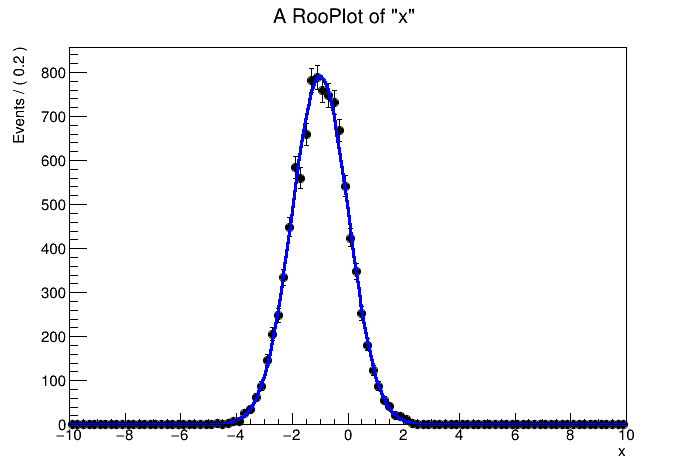

In [3]:
x = ROOT.RooRealVar("x", "x", -10, 10)
x_arr = np.random.normal(-1.0, 1.0, (10000,))
datatest = ROOT.RooDataSet.from_numpy({"x": x_arr}, [x])
mean=ROOT.RooRealVar("mu", "mu", 0., -10., 10)
SIGMA = ROOT.RooRealVar(f"SIGMA", "SIGMA", 1., 0., 3.)

Gau_fit = ROOT.RooGaussian("gau","gau",x,mean,SIGMA)

Gau_fit.fitTo(datatest)#,ROOT.RooFit.Extended(),ROOT.RooFit.NumCPU(7))

c222=ROOT.TCanvas()
Xframe = x.frame()
datatest.plotOn(Xframe)
Gau_fit.plotOn(Xframe)
Xframe.Draw()
c222.Draw('x')

Cell to compute resolution

probPI0=0.8#0, 0.5, 0.8
SAVEMOD="no"#"yes""no"
listmod=["sig","Bd2KstDsDsDs2TauNu","Bd2KstDsDsDs2pipipipi0","Bd2KstDsTauNuDs2TauNu","Bd2KstDsDsDs2pipipipi0pi0","Bd2KstDsstDsDsst2DsgammaDs2Taunu","Bd2KstDsDsDs2TaunuDs2pipipipi0","Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0","Bd2KstDsDsDs2TaunuDs2pipipipi0pi0", "Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0"]
listvar=["B_FD","eff_reco","eff_pred_sel","p_Kst","p_pi_max_tau_1","p_pi_min_tau_1","p_tau_1","p_pi_max_tau_2","p_pi_min_tau_2","p_tau_2","tau1_FD","tau1_PV_FD","tau2_FD","tau2_PV_FD","tau_1_m2pi_max","tau_1_m2pi_min","tau_1_m3pi","tau_2_m2pi_max","tau_2_m2pi_min","tau_2_m3pi"]
listsmearing=["5-1","5-2","5-3","5-4","5-5","5-6","5-7","5-8","10-1","10-2","10-3","10-4","10-5","10-6","10-7","10-8","20-1","20-2","20-3","20-4","20-5","20-6","20-7","20-8","IDEA"]
for i in ["++","--","+-","-+","sel"]:
    listvar.append(f"{i}")

n_sig_expected_dico={}
n_sig_fit_dico={}
sigma_n_sig_fit_dico={}

feature_columns=['B_FD', 'p_Kst', 'p_pi_max_tau_1', 'p_pi_min_tau_1', 'p_tau_1', 'p_pi_max_tau_2', 'p_pi_min_tau_2', 'p_tau_2', 'tau1_FD', 'tau1_PV_FD', 'tau2_FD', 'tau2_PV_FD', 'tau_1_m2pi_max', 'tau_1_m2pi_min', 'tau_1_m3pi', 'tau_2_m2pi_max', 'tau_2_m2pi_min', 'tau_2_m3pi', 'P_tau_1', 'P_tau_2']
model_xgboost_fin = xgb.XGBClassifier()
model_xgboost_fin.load_model("model_XGB.json")
def compute_true_numbers(smearing, listmod, listvar, probPI0,model_xgboost_fin,rand,feature_columns):
    data={}
    for mode in listmod:
        data1={}
        for var in listvar:
            data1[var]=np.loadtxt(f"data_for_sel/{smearing}/{mode}_{var}.txt")
        #adding the p_tau reco variables
        for tau in ["1","2"]:
            data1[f"sel_P_tau_{tau}"]=np.loadtxt(f"data_for_sel/{smearing}/{mode}_P_tau_{tau}_sel.txt")
        for i in ["++","+-","-+","--"]:
            data1[f"{i}_P_tau_1"]=np.loadtxt(f"data_for_sel/{smearing}/{mode}_P_tau_1_{i[0]}.txt")
            data1[f"{i}_P_tau_2"]=np.loadtxt(f"data_for_sel/{smearing}/{mode}_P_tau_2_{i[1]}.txt")       
        data[f"{mode}_{smearing}"]= data1

    #eff to obtain a RP candidate wrt the number of event generated and combination of reco efficiency with neutrino method if needed
    for mode in listmod:
        if ((mode=="sig")):
            maxevents=100000
        else:
            maxevents=400000
            data[f"{mode}_{smearing}"][f"eff_reco"][0]=(data[f"{mode}_{smearing}"][f"eff_reco"][0]+data[f"{mode}_{smearing}"][f"eff_reco"][2]+data[f"{mode}_{smearing}"][f"eff_reco"][4]+data[f"{mode}_{smearing}"][f"eff_reco"][6])/4
            data[f"{mode}_{smearing}"][f"eff_reco"][1]=np.sqrt(data[f"{mode}_{smearing}"][f"eff_reco"][1]**2+data[f"{mode}_{smearing}"][f"eff_reco"][3]**2+data[f"{mode}_{smearing}"][f"eff_reco"][5]**2+data[f"{mode}_{smearing}"][f"eff_reco"][7]**2)/4
        data[f"{mode}_{smearing}"][f"eff_RP_candidates"]=len(data[f"{mode}_{smearing}"][f"--"])/maxevents
        data[f"{mode}_{smearing}"][f"eff_RP_candidates_err"]=np.sqrt(data[f"{mode}_{smearing}"][f"eff_RP_candidates"]*(1-data[f"{mode}_{smearing}"][f"eff_RP_candidates"])/maxevents)
    #print(smearing, mode, data[f"{mode}_{smearing}"][f"eff_RP_candidates"])


    #add of a var to have class (sig or bkg) for each event and the decay mode on the same principle:
    for mode in listmod:
        data[f"{mode}_{smearing}"]["decay_mode"]=np.array([f'{mode}']*len(data[f"{mode}_{smearing}"]["--"]))
        if (mode=="sig"):
            data[f"{mode}_{smearing}"]["class"]=np.array(['sig']*len(data[f"{mode}_{smearing}"]["--"]))
        else:
            data[f"{mode}_{smearing}"]["class"]=np.array(['bkg']*len(data[f"{mode}_{smearing}"]["--"]))
    #print(data[f"sig_{smearing}"]["class"])
    #print(len(data[f"sig_{smearing}"]["class"]))

    #to build all version by concatenate the +/- solution and duplicate 4 times the previous variables
    for mode in listmod:
        data[f"{mode}_{smearing}"][f"all"]=np.concatenate((data[f"{mode}_{smearing}"][f"++"],data[f"{mode}_{smearing}"][f"+-"],data[f"{mode}_{smearing}"][f"-+"],data[f"{mode}_{smearing}"][f"--"]))
        data[f"{mode}_{smearing}"][f"all_P_tau_1"]=np.concatenate((data[f"{mode}_{smearing}"][f"++_P_tau_1"],data[f"{mode}_{smearing}"][f"+-_P_tau_1"],data[f"{mode}_{smearing}"][f"-+_P_tau_1"],data[f"{mode}_{smearing}"][f"--_P_tau_1"]))
        data[f"{mode}_{smearing}"][f"all_P_tau_2"]=np.concatenate((data[f"{mode}_{smearing}"][f"++_P_tau_2"],data[f"{mode}_{smearing}"][f"+-_P_tau_2"],data[f"{mode}_{smearing}"][f"-+_P_tau_2"],data[f"{mode}_{smearing}"][f"--_P_tau_2"]))
        for var in ["class","decay_mode","B_FD","p_Kst","p_pi_max_tau_1","p_pi_min_tau_1","p_tau_1","p_pi_max_tau_2","p_pi_min_tau_2","p_tau_2","tau1_FD","tau1_PV_FD","tau2_FD","tau2_PV_FD","tau_1_m2pi_max","tau_1_m2pi_min","tau_1_m3pi","tau_2_m2pi_max","tau_2_m2pi_min","tau_2_m3pi"]:
            data[f"{mode}_{smearing}"][f"all_{var}"]=np.concatenate((data[f"{mode}_{smearing}"][f"{var}"],data[f"{mode}_{smearing}"][f"{var}"],data[f"{mode}_{smearing}"][f"{var}"],data[f"{mode}_{smearing}"][f"{var}"]))
    #listmod=["sig","Bd2KstDsDsDs2TauNu","Bd2KstDsDsDs2pipipipi0","Bd2KstDsTauNuDs2TauNu","Bd2KstDsDsDs2pipipipi0pi0","Bd2KstDsstDsDsst2DsgammaDs2Taunu","Bd2KstDsDsDs2TaunuDs2pipipipi0","Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0","Bd2KstDsDsDs2TaunuDs2pipipipi0pi0", "Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0"]
    BF_list={"sig":9.57*10**(-11),"Bd2KstDsDsDs2TauNu":5.79*10**(-10),"Bd2KstDsDsDs2pipipipi0":7.35*10**(-10),"Bd2KstDsTauNuDs2TauNu":3.59*10**(-10),"Bd2KstDsDsDs2pipipipi0pi0":5.17*10**(-8),"Bd2KstDsstDsDsst2DsgammaDs2Taunu":1.83*10**(-9),"Bd2KstDsDsDs2TaunuDs2pipipipi0":6.52*10**(-10), "Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0":7.51*10**(-9),"Bd2KstDsDsDs2TaunuDs2pipipipi0pi0":5.47*10**(-9), "Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0":1.63*10**(-7)}
    # "Bd2KstDsstDsDsst2DsgammaDs2Taunu":1.83*10**(-9)*0.935 from BF(Dsstar->Ds gamma)
    #obtain mass in plot window, in cut study window and the associated eff
    for mode in listmod:
        for i in ["sel","all"]:
                data[f"{mode}_{smearing}"][f"{i}_no_0"]=data[f"{mode}_{smearing}"][f"{i}"][data[f"{mode}_{smearing}"][f"{i}"]!=0]
                data[f"{mode}_{smearing}"][f"{i}_in_window"]=((data[f"{mode}_{smearing}"][f"{i}_no_0"]<6)*((data[f"{mode}_{smearing}"][f"{i}_no_0"]>4.6)))
                data[f"{mode}_{smearing}"][f"{i}_eff_plot_window"]=np.count_nonzero(data[f"{mode}_{smearing}"][f"{i}_in_window"])/len(data[f"{mode}_{smearing}"][f"{i}_no_0"])
                #print(data[f"{mode}_{smearing}"][f"{i}_eff_window"])
                data[f"{mode}_{smearing}"][f"{i}_cut_plot_window"]=(data[f"{mode}_{smearing}"][f"{i}"]!=0)*(data[f"{mode}_{smearing}"][f"{i}"]>4.6)*(data[f"{mode}_{smearing}"][f"{i}"]<6)
                data[f"{mode}_{smearing}"][f"{i}_plot"]=data[f"{mode}_{smearing}"][f"{i}"][data[f"{mode}_{smearing}"][f"{i}_cut_plot_window"]]
                data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]=8*(10**12)*BF_list[f"{mode}"]*data[f"{mode}_{smearing}"][f"eff_RP_candidates"]*data[f"{mode}_{smearing}"][f"eff_reco"][0]*data[f"{mode}_{smearing}"][f"{i}_eff_plot_window"]
                data[f"{mode}_{smearing}"][f"{i}_in_cut_window"]=((data[f"{mode}_{smearing}"][f"{i}_no_0"]<5.6)*((data[f"{mode}_{smearing}"][f"{i}_no_0"]>5)))
                data[f"{mode}_{smearing}"][f"{i}_eff_cut_study_window"]=np.count_nonzero(data[f"{mode}_{smearing}"][f"{i}_in_cut_window"])/len(data[f"{mode}_{smearing}"][f"{i}_no_0"])
                #print(data[f"{mode}_{smearing}"][f"{i}_eff_cut_window"])
                data[f"{mode}_{smearing}"][f"{i}_cut_cut_window"]=(data[f"{mode}_{smearing}"][f"{i}"]!=0)*(data[f"{mode}_{smearing}"][f"{i}"]>5)*(data[f"{mode}_{smearing}"][f"{i}"]<5.6)
                data[f"{mode}_{smearing}"][f"{i}_cut_study"]=data[f"{mode}_{smearing}"][f"{i}"][data[f"{mode}_{smearing}"][f"{i}_cut_cut_window"]]
                data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]=8*(10**12)*BF_list[f"{mode}"]*data[f"{mode}_{smearing}"][f"eff_RP_candidates"]*data[f"{mode}_{smearing}"][f"eff_reco"][0]*data[f"{mode}_{smearing}"][f"{i}_eff_cut_study_window"]

    #to obtain cuted variable w.r.t. the cut window study for each of the sol
    for var in ["class","decay_mode","B_FD","p_Kst","p_pi_max_tau_1","p_pi_min_tau_1","p_tau_1","p_pi_max_tau_2","p_pi_min_tau_2","p_tau_2","tau1_FD","tau1_PV_FD","tau2_FD","tau2_PV_FD","tau_1_m2pi_max","tau_1_m2pi_min","tau_1_m3pi","tau_2_m2pi_max","tau_2_m2pi_min","tau_2_m3pi"]:
        for mode in listmod:
            for i in ["sel","all"]:
                if (i=="all"):
                    add_var="all_"
                else:
                    add_var=""
                data[f"{mode}_{smearing}"][f"{i}_cut_study_{var}"]=data[f"{mode}_{smearing}"][f"{add_var}{var}"][data[f"{mode}_{smearing}"][f"{i}_cut_cut_window"]]
                data[f"{mode}_{smearing}"][f"{i}_plot_{var}"]=data[f"{mode}_{smearing}"][f"{add_var}{var}"][data[f"{mode}_{smearing}"][f"{i}_cut_plot_window"]]
                data[f"{mode}_{smearing}"][f"{i}_cut_study_P_tau_1"]=data[f"{mode}_{smearing}"][f"{i}_P_tau_1"][data[f"{mode}_{smearing}"][f"{i}_cut_cut_window"]]
                data[f"{mode}_{smearing}"][f"{i}_plot_P_tau_1"]=data[f"{mode}_{smearing}"][f"{i}_P_tau_1"][data[f"{mode}_{smearing}"][f"{i}_cut_plot_window"]]
                data[f"{mode}_{smearing}"][f"{i}_cut_study_P_tau_2"]=data[f"{mode}_{smearing}"][f"{i}_P_tau_2"][data[f"{mode}_{smearing}"][f"{i}_cut_cut_window"]]
                data[f"{mode}_{smearing}"][f"{i}_plot_P_tau_2"]=data[f"{mode}_{smearing}"][f"{i}_P_tau_2"][data[f"{mode}_{smearing}"][f"{i}_cut_plot_window"]]

    #to obtain weights to normalize each sample in cuts study plots  
    for mode in listmod:
        for i in ["sel","all"]:
            data[f"{mode}_{smearing}"][f"{i}_weights"]=np.ones(len(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau1_FD"]))/len(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau1_FD"])

    for i in ["sel","all"]:
        smearname=smearing
        denom_signi=0
        for mode in listmod:
            denom_signi+=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]
            #print('Expected number of {} in window is {}'.format(mode,data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]))
        significance=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/np.sqrt(denom_signi)
        purity=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/denom_signi
        data[f"sig_{smearing}"][f"{i}_base_signi"]=significance
        print('Base significance on cut window for {} smearing and {} sol: {}'.format(smearname,i,significance))
        print('Base purity on cut window for {} smearing and {} sol: {}'.format(smearname,i,purity))

    probpi0k=probPI0
    rescale1pi0=(1-probpi0k)
    rescale2pi0=(1-probpi0k)**2

    probpi0k=probPI0
    rescale1pi0=(1-probpi0k)
    rescale2pi0=(1-probpi0k)**2

    for i in ["sel"]:
        for mode in listmod:
            if ((mode=='Bd2KstDsDsDs2pipipipi0')|(mode=='Bd2KstDsDsDs2pipipipi0pi0')|(mode=="Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0")):
                data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]*rescale2pi0
                data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]=data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]*rescale2pi0
            elif ((mode=='Bd2KstDsDsDs2TaunuDs2pipipipi0')|(mode=="Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0")|(mode=="Bd2KstDsDsDs2TaunuDs2pipipipi0pi0")):
                data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]*rescale1pi0
                data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]=data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]*rescale1pi0
            else:
                data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]
                data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]=data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]


    for i in ["sel"]:
        smearname=smearing
        denom_signi=0
        for mode in listmod:
            denom_signi+=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]
            #print('Expected number of {} in window is {}'.format(mode,data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]))
        significance=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/np.sqrt(denom_signi)
        purity=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/denom_signi
        data[f"sig_{smearing}"][f"{i}_base_signi"]=significance
        print('Base significance on cut window for {} smearing and {} sol: {}'.format(smearname,i,significance))
        print('Base purity on cut window for {} smearing and {} sol: {}'.format(smearname,i,purity))
    
    for mode in listmod:
        for i in ["sel","all"]:
            #cut on plot
            square_cut=~((data[f"{mode}_{smearing}"][f"{i}_plot_tau_1_m2pi_min"]**2<0.3)&(data[f"{mode}_{smearing}"][f"{i}_plot_tau_1_m2pi_max"]**2<0.5))
            square_cut*=(~((data[f"{mode}_{smearing}"][f"{i}_plot_tau_2_m2pi_min"]**2<0.3)&(data[f"{mode}_{smearing}"][f"{i}_plot_tau_2_m2pi_max"]**2<0.5)))
            new_cut=(data[f"{mode}_{smearing}"][f"{i}_plot_p_Kst"]>1)
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_plot_p_tau_1"]>1)*(data[f"{mode}_{smearing}"][f"{i}_plot_p_tau_2"]>1)#p_3pi cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_plot_p_pi_min_tau_1"]>0.2)*(data[f"{mode}_{smearing}"][f"{i}_plot_p_pi_min_tau_2"]>0.2)#p_2pi min cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_plot_p_pi_max_tau_1"]>0.25)*(data[f"{mode}_{smearing}"][f"{i}_plot_p_pi_max_tau_2"]>0.25)#p_2pi max cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_plot_B_FD"]>0.3)#B FD cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_plot_tau1_FD"]<4)*(data[f"{mode}_{smearing}"][f"{i}_plot_tau2_FD"]<4)#tau FD cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_plot_tau_1_m3pi"]>0.75)*(data[f"{mode}_{smearing}"][f"{i}_plot_tau_2_m3pi"]>0.75)#m_3pi cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_plot_tau_1_m2pi_min"]<1)*(data[f"{mode}_{smearing}"][f"{i}_plot_tau_2_m2pi_min"]<1)#m_2pi min cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_plot_tau_1_m2pi_max"]>0.5)*(data[f"{mode}_{smearing}"][f"{i}_plot_tau_2_m2pi_max"]>0.5)#m_2pi max cut
            new_cut*=square_cut
            data[f"{mode}_{smearing}"][f"{i}_plot_Dalitz_cut"]=new_cut
            data[f"{mode}_{smearing}"][f"{i}_eff_plot_Dalitz_cut"]=np.count_nonzero(data[f"{mode}_{smearing}"][f"{i}_plot_Dalitz_cut"])/len(data[f"{mode}_{smearing}"][f"{i}_plot_tau_1_m2pi_min"])
            data[f"{mode}_{smearing}"][f"{i}_plot"]=data[f"{mode}_{smearing}"][f"{i}_plot"][data[f"{mode}_{smearing}"][f"{i}_plot_Dalitz_cut"]]
            data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]=data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]*data[f"{mode}_{smearing}"][f"{i}_eff_plot_Dalitz_cut"]
            
            #cut on cut study
            """if (i=='sel'):
                print("{} number of events on [5,5.6] before cut: {}".format(mode,data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]))"""
            square_cut=~((data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_1_m2pi_min"]**2<0.3)&(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_1_m2pi_max"]**2<0.5))
            square_cut*=(~((data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_2_m2pi_min"]**2<0.3)&(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_2_m2pi_max"]**2<0.5)))
            new_cut=(data[f"{mode}_{smearing}"][f"{i}_cut_study_p_Kst"]>1)
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_cut_study_p_tau_1"]>1)*(data[f"{mode}_{smearing}"][f"{i}_cut_study_p_tau_2"]>1)#p_3pi cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_cut_study_p_pi_min_tau_1"]>0.2)*(data[f"{mode}_{smearing}"][f"{i}_cut_study_p_pi_min_tau_2"]>0.2)#p_2pi min cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_cut_study_p_pi_max_tau_1"]>0.25)*(data[f"{mode}_{smearing}"][f"{i}_cut_study_p_pi_max_tau_2"]>0.25)#p_2pi max cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_cut_study_B_FD"]>0.3)#B FD cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau1_FD"]<4)*(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau2_FD"]<4)#tau FD cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_1_m3pi"]>0.75)*(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_2_m3pi"]>0.75)#m_3pi cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_1_m2pi_min"]<1)*(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_2_m2pi_min"]<1)#m_2pi min cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_1_m2pi_max"]>0.5)*(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_2_m2pi_max"]>0.5)#m_2pi max cut
            new_cut*=square_cut
            data[f"{mode}_{smearing}"][f"{i}_cut_study_Dalitz_cut"]=new_cut
            data[f"{mode}_{smearing}"][f"{i}_eff_cut_study_Dalitz_cut"]=np.count_nonzero(data[f"{mode}_{smearing}"][f"{i}_cut_study_Dalitz_cut"])/len(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_1_m2pi_min"])
            data[f"{mode}_{smearing}"][f"{i}_cut_study"]=data[f"{mode}_{smearing}"][f"{i}_cut_study"][data[f"{mode}_{smearing}"][f"{i}_cut_study_Dalitz_cut"]]
            data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]*data[f"{mode}_{smearing}"][f"{i}_eff_cut_study_Dalitz_cut"]
            """if (i=='sel'):
                print("{} : {}".format(mode, data[f"{mode}_{smearing}"][f"{i}_eff_cut_study_Dalitz_cut"]))
                print("{} number of events on [5,5.6] after cut: {}".format(mode,data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]))"""

    for var in ["class","decay_mode","B_FD","p_Kst","p_pi_max_tau_1","p_pi_min_tau_1","p_tau_1","p_pi_max_tau_2","p_pi_min_tau_2","p_tau_2","tau1_FD","tau1_PV_FD","tau2_FD","tau2_PV_FD","tau_1_m2pi_max","tau_1_m2pi_min","tau_1_m3pi","tau_2_m2pi_max","tau_2_m2pi_min","tau_2_m3pi","P_tau_1","P_tau_2"]:
        for mode in listmod:
            for i in ["sel","all"]:
                data[f"{mode}_{smearing}"][f"{i}_cut_study_{var}"]=data[f"{mode}_{smearing}"][f"{i}_cut_study_{var}"][data[f"{mode}_{smearing}"][f"{i}_cut_study_Dalitz_cut"]]
                data[f"{mode}_{smearing}"][f"{i}_plot_{var}"]=data[f"{mode}_{smearing}"][f"{i}_plot_{var}"][data[f"{mode}_{smearing}"][f"{i}_plot_Dalitz_cut"]]

    for i in ["sel","all"]:
        smearname=smearing
        denom_signi=0
        for mode in listmod:
            denom_signi+=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]
            #print('Expected number of {} in window is {}'.format(mode,data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]))
        significance=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/np.sqrt(denom_signi)
        purity=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/denom_signi
        data[f"sig_{smearing}"][f"{i}_base_signi"]=significance
        print('Base significance on cut window for {} smearing and {} sol: {}'.format(smearname,i,significance))
        print('Base purity on cut window for {} smearing and {} sol: {}'.format(smearname,i,purity))
            
    for i in ["sel","all"]:
        smearname=smearing
        denom_signinopi0=0
        for mode in listmod:
            if ((mode!="Bd2KstDsDsDs2pipipipi0")&(mode!="Bd2KstDsDsDs2pipipipi0pi0")&(mode!="Bd2KstDsDsDs2TaunuDs2pipipipi0")&(mode!="Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0")&(mode!="Bd2KstDsDsDs2TaunuDs2pipipipi0pi0")&(mode!="Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0")):
                denom_signinopi0+=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]
            #print('Expected number of {} in window is {}'.format(mode,data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]))
        significancenopi0=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/np.sqrt(denom_signinopi0)
        puritynopi0=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/denom_signinopi0
        data[f"sig_{smearing}"][f"{i}_base_signi_no_pi0"]=significancenopi0
        print('Base significance without pi0 bkgs on cut window for {} smearing and {} sol: {}'.format(smearname,i,significancenopi0))
        print('Base purity without pi0 bkgs on cut window for {} smearing and {} sol: {}'.format(smearname,i,puritynopi0))
    
    
    
    
    sol='sel'
    window='plot'
    data_bis={}
    list_var=["class","decay_mode","B_FD","p_Kst","p_pi_max_tau_1","p_pi_min_tau_1","p_tau_1","p_pi_max_tau_2","p_pi_min_tau_2","p_tau_2","tau1_FD","tau1_PV_FD","tau2_FD","tau2_PV_FD","tau_1_m2pi_max","tau_1_m2pi_min","tau_1_m3pi","tau_2_m2pi_max","tau_2_m2pi_min","tau_2_m3pi","P_tau_1","P_tau_2"]

    dfplot = pd.DataFrame()
    for mode in listmod:
        data_bis1={}
        data_bis1[f'mass']=data[f"{mode}_{smearing}"][f'{sol}_{window}']
        data_bis1['eff_reco']=np.array([data[f"{mode}_{smearing}"][f"eff_reco"][0]]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
        data_bis1['eff_RP_candidates']=np.array([data[f"{mode}_{smearing}"][f"eff_RP_candidates"]]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
        data_bis1['eff_in_window']=np.array([data[f"{mode}_{smearing}"][f"{sol}_eff_{window}_window"]]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
        data_bis1['eff_Dalitz_cut']=np.array([data[f"{mode}_{smearing}"][f"{i}_eff_{window}_Dalitz_cut"]]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
        data_bis1['BF']=np.array([BF_list[f"{mode}"]]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
        if (mode=='sig'):
            data_bis1['class_num']=np.array([1]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
        else:
            data_bis1['class_num']=np.array([0]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
        print(mode, len(data_bis1[f'mass']))
        for var in list_var:
            data_bis1[f'{var}']=data[f"{mode}_{smearing}"][f"{sol}_{window}_{var}"]
        data_bis[f"{mode}"]=data_bis1
        dfplot=pd.concat([dfplot,pd.DataFrame.from_dict(data_bis[f"{mode}"])])
    dfplot.reset_index(drop=True, inplace=True)

    dfplotcut=dfplot
    dfplotcut['class_pred']=model_xgboost_fin.predict_proba(dfplotcut.loc[:,feature_columns])[:,1]

    i='sel'
    denom_purity=0
    for mode in listmod:
        data[f"{mode}_{smearing}"][f"{i}_plot_eff_XGB"]=len(dfplotcut[(dfplotcut['decay_mode']==f'{mode}')&(dfplotcut['class_pred']>0.5)])/len(dfplotcut[dfplotcut['decay_mode']==f'{mode}'])
        data[f"{mode}_{smearing}"][f"{i}_plot_true_number_after_XGB"]=data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]*data[f"{mode}_{smearing}"][f"{i}_plot_eff_XGB"]
        denom_purity+=data[f"{mode}_{smearing}"][f"{i}_plot_true_number_after_XGB"]
        print("{} eff XGB cut : {:.3f}, true number before | after cut : {:.3f} | {:.3f}".format(mode, data[f"{mode}_{smearing}"][f"{i}_plot_eff_XGB"], data[f"{mode}_{smearing}"][f"{i}_plot_true_number"],data[f"{mode}_{smearing}"][f"{i}_plot_true_number_after_XGB"]))
        data[f"{mode}_{smearing}"][f"{i}_plot_after_XGB"]=(dfplotcut['mass'][(dfplotcut['decay_mode']==f'{mode}')&(dfplotcut['class_pred']>0.5)]).values.tolist()
    purity=data[f"sig_{smearing}"][f"{i}_plot_true_number_after_XGB"]/denom_purity
    print(f"Purity after XGB cut on plot window : {purity}")


    mass_high=6.
    mass_low=5.
    mass = ROOT.RooRealVar("mass", "mass", mass_low, mass_high)
    bins=int((mass_high-mass_low)/0.03)
    npsigmass=np.array(data[f"sig_{smearing}"][f"sel_plot_after_XGB"])

    signal_mass = ROOT.RooDataSet.from_numpy(data={"mass": npsigmass}, variables=[mass])
    
    c11=ROOT.TCanvas()
    Mframe = mass.frame(bins)
    signal_mass.plotOn(Mframe)
    Mframe.Draw()
    c11.Draw('mass')
    c11.SaveAs(f'XGBfit/{smearing}_signal_mass.pdf')
    
    #np.savetxt('data1.txt',X=npsigmass)
    low = 4.6
    high = 6

    rand+=1

    #signal fit
    #crystal ball parameters
    mu=ROOT.RooRealVar(f"mu_{rand}", f"mu_{rand}", lp.B_0.mass/1000., low, high)
    sigma = ROOT.RooRealVar(f"sigma_{rand}", f"sigma_{rand}", 0.6, 0., 1.)
    alphaR = ROOT.RooRealVar(f"alphaR_{rand}", f"alphaR_{rand}", 0.5, 0., 5.)
    nR = ROOT.RooRealVar(f"nR_{rand}", f"nR_{rand}", 10., 0., 200.)
    alphaL = ROOT.RooRealVar(f"alphaL_{rand}", f"alphaL_{rand}", 0.5, 0., 5.)
    nL = ROOT.RooRealVar(f"nL_{rand}", f"nL_{rand}", 10., 0., 200.)
    # Core gaussian parameters
    sigmaG1 = ROOT.RooRealVar(f"sigmaG1_{rand}", f"sigmaG1_{rand}", 0.1, 0., 1)
    # Fractions
    frac = ROOT.RooRealVar(f"frac_{rand}", f"frac_{rand}", 0.5, 0., 1.)

    #signal model
    CB = ROOT.RooCrystalBall(f"CB_{rand}",f"CB_{rand}",x=mass,x0=mu,sigmaLR=sigma,alphaR=alphaR, nR=nR,alphaL=alphaL, nL=nL )
    Gau = ROOT.RooGaussian(f"gau_{rand}",f"gau_{rand}",_x=mass,_mean=mu,_sigma=sigmaG1)
    sig_fit= ROOT.RooAddPdf( f"sig_fit_{rand}",f"sig_fit_{rand}",CB, Gau,frac)

    minimiz=ROOT.RooFit.Minimizer("Minuit2","migrad")
    sig_fit.fitTo(signal_mass,minimiz)#,ROOT.RooFit.Extended(),ROOT.RooFit.NumCPU(7))
    c22=ROOT.TCanvas()
    Mframe = mass.frame(bins)
    signal_mass.plotOn(Mframe)
    sig_fit.plotOn(Mframe)
    Mframe.Draw()
    c22.Draw('mass')
    c22.SaveAs(f'XGBfit/{smearing}_signal_fit_result.pdf')

    weight = ROOT.RooRealVar("weight", "weight", 0., 100000.)

    npsigbkgmass=np.array([])
    npsigbkgweight=np.array([])
    npbkgmass=np.array([])#array to determine number of bkg on fit window
    for sigbkgmode in ["sig","Bd2KstDsDsDs2TauNu","Bd2KstDsDsDs2pipipipi0","Bd2KstDsTauNuDs2TauNu","Bd2KstDsDsDs2pipipipi0pi0","Bd2KstDsstDsDsst2DsgammaDs2Taunu","Bd2KstDsDsDs2TaunuDs2pipipipi0","Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0","Bd2KstDsDsDs2TaunuDs2pipipipi0pi0", "Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0"]:
        if (sigbkgmode!="sig"):
            npbkgmass=np.concatenate((npbkgmass,np.array(data[f"{sigbkgmode}_{smearing}"][f"sel_plot_after_XGB"])),axis=None)
        npsigbkgmass=np.concatenate((npsigbkgmass,np.array(data[f"{sigbkgmode}_{smearing}"][f"sel_plot_after_XGB"])),axis=None)
        npsigbkgweight=np.concatenate((npsigbkgweight,(np.array(data[f"{sigbkgmode}_{smearing}"][f"sel_plot_after_XGB"])*0+data[f"{sigbkgmode}_{smearing}"][f"sel_plot_true_number_after_XGB"]/len(data[f"{sigbkgmode}_{smearing}"][f"sel_plot_after_XGB"]))),axis=None)
    sigbkg_mass = ROOT.RooDataSet.from_numpy(data={"mass": npsigbkgmass, "weight": npsigbkgweight}, variables=[mass, weight], weight_name="weight")
    #np.savetxt('data2.txt',X=np.stack((npsigbkgmass,npsigbkgweight)))

    #fix signal model parameters
    mu.setConstant()
    sigma.setConstant()
    alphaR.setConstant()
    nR.setConstant()
    alphaL.setConstant()
    nL.setConstant()
    sigmaG1.setConstant()
    frac.setConstant()
    #background model
    c_exp1=ROOT.RooRealVar(f"c_exp1_{rand}", f"c_exp1_{rand}", -1., -10., 0.)#-7.63421
    #c_exp1.setConstant()
    c_exp2=ROOT.RooRealVar(f"c_exp2_{rand}", f"c_exp2_{rand}", -1., -10., 0.)
    frac_expo=ROOT.RooRealVar(f"frac_expo_{rand}", f"frac_expo_{rand}", 0.5, 0., 1.)
    expo1=ROOT.RooExponential(f"expo1_{rand}",f"expo1_{rand}",_x=mass,_c=c_exp1)
    expo2=ROOT.RooExponential(f"expo2_{rand}",f"expo2_{rand}",_x=mass,_c=c_exp2)
    bkg_fit=ROOT.RooAddPdf( f"bkg_fit_{rand}",f"bkg_fit_{rand}",expo1, expo2,frac_expo)
    #yield
    nsig0=data[f"sig_{smearing}"][f"sel_plot_true_number"]
    nbkg0=data[f"Bd2KstDsDsDs2TauNu_{smearing}"][f"sel_plot_true_number"]+data[f"Bd2KstDsDsDs2pipipipi0_{smearing}"][f"sel_plot_true_number"]+data[f"Bd2KstDsTauNuDs2TauNu_{smearing}"][f"sel_plot_true_number"]+data[f"Bd2KstDsDsDs2pipipipi0pi0_{smearing}"][f"sel_plot_true_number"]+data[f"Bd2KstDsstDsDsst2DsgammaDs2Taunu_{smearing}"][f"sel_plot_true_number"]+data[f"Bd2KstDsDsDs2TaunuDs2pipipipi0_{smearing}"][f"sel_plot_true_number"]+data[f"Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0_{smearing}"][f"sel_plot_true_number"]+data[f"Bd2KstDsDsDs2TaunuDs2pipipipi0pi0_{smearing}"][f"sel_plot_true_number"]+data[f"Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0_{smearing}"][f"sel_plot_true_number"]
    nsig=ROOT.RooRealVar(f"nSig_{rand}",f"nSig_{rand}",nsig0,0.,10000.)
    nbkg=ROOT.RooRealVar(f"nBkg_{rand}",f"nBkg_{rand}",nbkg0,0,1000000.)
    #total model
    sigbkg_fit=ROOT.RooAddPdf("sigbkg_fit","sigbkg_fit",ROOT.RooArgList(sig_fit,bkg_fit),ROOT.RooArgList(nsig,nbkg))

    #mass.setRange('fitrange',5.0,6.0)
    minimiz=ROOT.RooFit.Minimizer("Minuit2","migrad")
    sigbkg_fit.fitTo(sigbkg_mass,minimiz)#Range=('fitrange')

    #plot_sig=ROOT.RooExtendPdf(f'sig_plot_{rand}', f'sig_plot_{rand}', sig_fit, nsig)
    #plot_bkg=ROOT.RooExtendPdf(f'bkg_plot_{rand}', f'bkg_plot_{rand}', bkg_fit, nbkg)
    c222=ROOT.TCanvas()
    Mframe = mass.frame(bins)
    sigbkg_mass.plotOn(Mframe)
    sigbkg_fit.plotOn(Mframe)
    sigbkg_fit.plotOn(Mframe, LineColor='r',Components=ROOT.RooArgSet(sig_fit))
    sigbkg_fit.plotOn(Mframe, LineColor='m',Components=ROOT.RooArgSet(bkg_fit))
    Mframe.Draw()
    c222.Draw('mass')
    c222.SaveAs(f'XGBfit/{smearing}_total_fit_result.pdf')

    nbsig_expected=0
    for mode in ["sig"]:
        nbsig_expected+=data[f"{mode}_{smearing}"][f"sel_plot_true_number_after_XGB"]*(len(np.array(data[f"{mode}_{smearing}"][f"sel_plot_after_XGB"])[(np.array(data[f"{mode}_{smearing}"][f"sel_plot_after_XGB"])>mass_low)*(np.array(data[f"{mode}_{smearing}"][f"sel_plot_after_XGB"])<mass_high)])/len(np.array(data[f"{mode}_{smearing}"][f"sel_plot_after_XGB"])))
    print(nbsig_expected)
    nbbkg_expected=0
    for mode in ["Bd2KstDsDsDs2TauNu","Bd2KstDsDsDs2pipipipi0","Bd2KstDsTauNuDs2TauNu","Bd2KstDsDsDs2pipipipi0pi0","Bd2KstDsstDsDsst2DsgammaDs2Taunu","Bd2KstDsDsDs2TaunuDs2pipipipi0","Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0","Bd2KstDsDsDs2TaunuDs2pipipipi0pi0", "Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0"]:
        nbbkg_expected+=data[f"{mode}_{smearing}"][f"sel_plot_true_number_after_XGB"]*(len(np.array(data[f"{mode}_{smearing}"][f"sel_plot_after_XGB"])[(np.array(data[f"{mode}_{smearing}"][f"sel_plot_after_XGB"])>mass_low)*(np.array(data[f"{mode}_{smearing}"][f"sel_plot_after_XGB"])<mass_high)])/len(np.array(data[f"{mode}_{smearing}"][f"sel_plot_after_XGB"])))
    print(nbbkg_expected)

    print(nsig)
    print(nbkg)

    print(nsig.getVal()+nbkg.getVal())
    print(nbsig_expected+nbbkg_expected)
    print(nsig.getError())
    print(nbkg.getError())

    #saving the value for precision on measurement
    n_sig_expected_dico[f'{smearing}']=nbsig_expected
    n_sig_fit_dico[f'{smearing}']=nsig.getVal()
    sigma_n_sig_fit_dico[f'{smearing}']=nsig.getError()
    
    np.savetxt(f"yield_fit/{smearing}_n_sig_expected.txt",X=np.array([nbsig_expected]))
    np.savetxt(f"yield_fit/{smearing}_n_sig_fit.txt",X=np.array([nsig.getVal()]))
    np.savetxt(f"yield_fit/{smearing}_sigma_n_sig_fit.txt",X=np.array([nsig.getError()]))

Map to save initial parameters of the fit that lead to a succesfull fit (to be able to relaunch everything quickly if needed):

In [57]:
dico_start_param={
    "IDEA_d0z0_50":{"sigma":0.1, "alphaL":0.5, "alphaR":0.5, "cexp1":-1.5, "cexp2":-1.5},
    "IDEA_d0z0_67":{"sigma":0.3, "alphaL":0.5, "alphaR":0.5, "cexp1":-1.5, "cexp2":-1.5},
    "IDEA_d0z0_83":{"sigma":0.3, "alphaL":0.5, "alphaR":0.5, "cexp1":-1.2, "cexp2":-1.2},
    "IDEA_omega_50":{"sigma":0.4, "alphaL":0.7, "alphaR":0.7, "cexp1":-1.5, "cexp2":-1.5},
    "IDEA":{"sigma":0.5, "alphaL":1., "alphaR":1., "cexp1":-1.2, "cexp2":-1.2},

    "5-1":{"sigma":0.2, "alphaL":0.5, "alphaR":0.5, "cexp1":-1., "cexp2":-1.},
    "5-2":{"sigma":0.2, "alphaL":0.5, "alphaR":0.5, "cexp1":-1., "cexp2":-1.},
    "5-3":{"sigma":0.2, "alphaL":0.5, "alphaR":0.5, "cexp1":-1.5, "cexp2":-1.5},
    "5-4":{"sigma":0.6, "alphaL":1.1, "alphaR":1.1, "cexp1":-1.5, "cexp2":-1.5},
    "5-5":{"sigma":0.6, "alphaL":1.1, "alphaR":1.1, "cexp1":-1.5, "cexp2":-1.5},
    "5-6":{"sigma":0.8, "alphaL":0.8, "alphaR":0.8, "cexp1":-1.5, "cexp2":-1.5},
    "5-7":{"sigma":1., "alphaL":1.5, "alphaR":1.5, "cexp1":-1.5, "cexp2":-1.5},
    "5-8":{"sigma":1.9, "alphaL":1., "alphaR":1., "cexp1":-1.5, "cexp2":-1.5},

    "10-1":{"sigma":0.3, "alphaL":0.9, "alphaR":0.9, "cexp1":-1.5, "cexp2":-1.5},
    "10-2":{"sigma":0.3, "alphaL":0.9, "alphaR":0.9, "cexp1":-1.5, "cexp2":-1.5},
    "10-3":{"sigma":0.5, "alphaL":0.9, "alphaR":0.9, "cexp1":-1.5, "cexp2":-1.5},
    "10-4":{"sigma":0.5, "alphaL":0.9, "alphaR":0.9, "cexp1":-1.5, "cexp2":-1.5},
    "10-5":{"sigma":0.5, "alphaL":0.9, "alphaR":0.9, "cexp1":-1.5, "cexp2":-1.5},
    "10-6":{"sigma":0.8, "alphaL":0.8, "alphaR":0.8, "cexp1":-1.5, "cexp2":-1.5},
    "10-7":{"sigma":0.6, "alphaL":1., "alphaR":1., "cexp1":-1.5, "cexp2":-1.5},
    "10-8":{"sigma":2., "alphaL":1., "alphaR":1., "cexp1":-1.5, "cexp2":-1.5},

    "20-1":{"sigma":1., "alphaL":0.5, "alphaR":0.5, "cexp1":-1.2, "cexp2":-1.2},
    "20-2":{"sigma":1., "alphaL":1., "alphaR":1., "cexp1":-1.5, "cexp2":-1.5},
    "20-3":{"sigma":1., "alphaL":1.5, "alphaR":1.5, "cexp1":-1.5, "cexp2":-1.5},
    "20-4":{"sigma":2., "alphaL":0.7, "alphaR":0.7, "cexp1":-1.5, "cexp2":-1.5},
    "20-5":{"sigma":2., "alphaL":0.7, "alphaR":0.7, "cexp1":-1.5, "cexp2":-1.5},
    "20-6":{"sigma":2., "alphaL":0.7, "alphaR":0.7, "cexp1":-1.5, "cexp2":-1.5},
    "20-7":{"sigma":2., "alphaL":0.7, "alphaR":0.7, "cexp1":-1.5, "cexp2":-1.5},
    "20-8":{"sigma":2., "alphaL":1., "alphaR":1., "cexp1":-1., "cexp2":-1.}
}

Cell to study different lumi

In [58]:
probPI0=0.8#0, 0.5, 0.8
SAVEMOD="no"#"yes""no"
listmod=["sig","Bd2KstDsDsDs2TauNu","Bd2KstDsDsDs2pipipipi0","Bd2KstDsTauNuDs2TauNu","Bd2KstDsDsDs2pipipipi0pi0","Bd2KstDsstDsDsst2DsgammaDs2Taunu","Bd2KstDsDsDs2TaunuDs2pipipipi0","Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0","Bd2KstDsDsDs2TaunuDs2pipipipi0pi0", "Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0"]
listvar=["B_FD","eff_reco","eff_pred_sel","p_Kst","p_pi_max_tau_1","p_pi_min_tau_1","p_tau_1","p_pi_max_tau_2","p_pi_min_tau_2","p_tau_2","tau1_FD","tau1_PV_FD","tau2_FD","tau2_PV_FD","tau_1_m2pi_max","tau_1_m2pi_min","tau_1_m3pi","tau_2_m2pi_max","tau_2_m2pi_min","tau_2_m3pi"]
listsmearing=["5-1","5-2","5-3","5-4","5-5","5-6","5-7","5-8","10-1","10-2","10-3","10-4","10-5","10-6","10-7","10-8","20-1","20-2","20-3","20-4","20-5","20-6","20-7","20-8","IDEA"]
for i in ["++","--","+-","-+","sel"]:
    listvar.append(f"{i}")

n_sig_expected_dico={}
n_sig_fit_dico={}
sigma_n_sig_fit_dico={}

feature_columns=['B_FD', 'p_Kst', 'p_pi_max_tau_1', 'p_pi_min_tau_1', 'p_tau_1', 'p_pi_max_tau_2', 'p_pi_min_tau_2', 'p_tau_2', 'tau1_FD', 'tau1_PV_FD', 'tau2_FD', 'tau2_PV_FD', 'tau_1_m2pi_max', 'tau_1_m2pi_min', 'tau_1_m3pi', 'tau_2_m2pi_max', 'tau_2_m2pi_min', 'tau_2_m3pi', 'P_tau_1', 'P_tau_2']
model_xgboost_fin = xgb.XGBClassifier()
model_xgboost_fin.load_model("model_XGB.json")

eff_vertexing=0.8#conservative choice
def compute_true_numbers_other_yield(smearing, listmod, listvar, probPI0,model_xgboost_fin,rand,feature_columns,mode_yield):
    print(mode_yield)
    if (mode_yield==""):
        mode_yield_txt=""
    else:
        mode_yield_txt=f"_{mode_yield}"
    data={}
    for mode in listmod:
        data1={}
        for var in listvar:
            data1[var]=np.loadtxt(f"data_for_sel/{smearing}/{mode}_{var}.txt")
        #adding the p_tau reco variables
        for tau in ["1","2"]:
            data1[f"sel_P_tau_{tau}"]=np.loadtxt(f"data_for_sel/{smearing}/{mode}_P_tau_{tau}_sel.txt")
        for i in ["++","+-","-+","--"]:
            data1[f"{i}_P_tau_1"]=np.loadtxt(f"data_for_sel/{smearing}/{mode}_P_tau_1_{i[0]}.txt")
            data1[f"{i}_P_tau_2"]=np.loadtxt(f"data_for_sel/{smearing}/{mode}_P_tau_2_{i[1]}.txt")       
        data[f"{mode}_{smearing}"]= data1

    #eff to obtain a RP candidate wrt the number of event generated and combination of reco efficiency with neutrino method if needed
    for mode in listmod:
        if ((mode=="sig")):
            maxevents=100000
        else:
            maxevents=400000
            data[f"{mode}_{smearing}"][f"eff_reco"][0]=(data[f"{mode}_{smearing}"][f"eff_reco"][0]+data[f"{mode}_{smearing}"][f"eff_reco"][2]+data[f"{mode}_{smearing}"][f"eff_reco"][4]+data[f"{mode}_{smearing}"][f"eff_reco"][6])/4
            data[f"{mode}_{smearing}"][f"eff_reco"][1]=np.sqrt(data[f"{mode}_{smearing}"][f"eff_reco"][1]**2+data[f"{mode}_{smearing}"][f"eff_reco"][3]**2+data[f"{mode}_{smearing}"][f"eff_reco"][5]**2+data[f"{mode}_{smearing}"][f"eff_reco"][7]**2)/4
        data[f"{mode}_{smearing}"][f"eff_RP_candidates"]=len(data[f"{mode}_{smearing}"][f"--"])/maxevents
        data[f"{mode}_{smearing}"][f"eff_RP_candidates_err"]=np.sqrt(data[f"{mode}_{smearing}"][f"eff_RP_candidates"]*(1-data[f"{mode}_{smearing}"][f"eff_RP_candidates"])/maxevents)
    #print(smearing, mode, data[f"{mode}_{smearing}"][f"eff_RP_candidates"])


    #add of a var to have class (sig or bkg) for each event and the decay mode on the same principle:
    for mode in listmod:
        data[f"{mode}_{smearing}"]["decay_mode"]=np.array([f'{mode}']*len(data[f"{mode}_{smearing}"]["--"]))
        if (mode=="sig"):
            data[f"{mode}_{smearing}"]["class"]=np.array(['sig']*len(data[f"{mode}_{smearing}"]["--"]))
        else:
            data[f"{mode}_{smearing}"]["class"]=np.array(['bkg']*len(data[f"{mode}_{smearing}"]["--"]))
    #print(data[f"sig_{smearing}"]["class"])
    #print(len(data[f"sig_{smearing}"]["class"]))

    #to build all version by concatenate the +/- solution and duplicate 4 times the previous variables
    for mode in listmod:
        data[f"{mode}_{smearing}"][f"all"]=np.concatenate((data[f"{mode}_{smearing}"][f"++"],data[f"{mode}_{smearing}"][f"+-"],data[f"{mode}_{smearing}"][f"-+"],data[f"{mode}_{smearing}"][f"--"]))
        data[f"{mode}_{smearing}"][f"all_P_tau_1"]=np.concatenate((data[f"{mode}_{smearing}"][f"++_P_tau_1"],data[f"{mode}_{smearing}"][f"+-_P_tau_1"],data[f"{mode}_{smearing}"][f"-+_P_tau_1"],data[f"{mode}_{smearing}"][f"--_P_tau_1"]))
        data[f"{mode}_{smearing}"][f"all_P_tau_2"]=np.concatenate((data[f"{mode}_{smearing}"][f"++_P_tau_2"],data[f"{mode}_{smearing}"][f"+-_P_tau_2"],data[f"{mode}_{smearing}"][f"-+_P_tau_2"],data[f"{mode}_{smearing}"][f"--_P_tau_2"]))
        for var in ["class","decay_mode","B_FD","p_Kst","p_pi_max_tau_1","p_pi_min_tau_1","p_tau_1","p_pi_max_tau_2","p_pi_min_tau_2","p_tau_2","tau1_FD","tau1_PV_FD","tau2_FD","tau2_PV_FD","tau_1_m2pi_max","tau_1_m2pi_min","tau_1_m3pi","tau_2_m2pi_max","tau_2_m2pi_min","tau_2_m3pi"]:
            data[f"{mode}_{smearing}"][f"all_{var}"]=np.concatenate((data[f"{mode}_{smearing}"][f"{var}"],data[f"{mode}_{smearing}"][f"{var}"],data[f"{mode}_{smearing}"][f"{var}"],data[f"{mode}_{smearing}"][f"{var}"]))
    #listmod=["sig","Bd2KstDsDsDs2TauNu","Bd2KstDsDsDs2pipipipi0","Bd2KstDsTauNuDs2TauNu","Bd2KstDsDsDs2pipipipi0pi0","Bd2KstDsstDsDsst2DsgammaDs2Taunu","Bd2KstDsDsDs2TaunuDs2pipipipi0","Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0","Bd2KstDsDsDs2TaunuDs2pipipipi0pi0", "Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0"]
    BF_list={"sig":9.57*10**(-11),"Bd2KstDsDsDs2TauNu":1.14*10**(-10),"Bd2KstDsDsDs2pipipipi0":1.45*10**(-10),"Bd2KstDsTauNuDs2TauNu":3.59*10**(-10),"Bd2KstDsDsDs2pipipipi0pi0":1.02*10**(-8),"Bd2KstDsstDsDsst2DsgammaDs2Taunu":3.60*10**(-10),"Bd2KstDsDsDs2TaunuDs2pipipipi0":1.28*10**(-10), "Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0":7.51*10**(-9),"Bd2KstDsDsDs2TaunuDs2pipipipi0pi0":1.08*10**(-9), "Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0":3.22*10**(-8)}
    # "Bd2KstDsstDsDsst2DsgammaDs2Taunu":1.83*10**(-9)*0.935 from BF(Dsstar->Ds gamma)
    #obtain mass in plot window, in cut study window and the associated eff
    for mode in listmod:
        for i in ["sel","all"]:
                data[f"{mode}_{smearing}"][f"{i}_no_0"]=data[f"{mode}_{smearing}"][f"{i}"][data[f"{mode}_{smearing}"][f"{i}"]!=0]
                data[f"{mode}_{smearing}"][f"{i}_in_window"]=((data[f"{mode}_{smearing}"][f"{i}_no_0"]<6)*((data[f"{mode}_{smearing}"][f"{i}_no_0"]>4.6)))
                data[f"{mode}_{smearing}"][f"{i}_eff_plot_window"]=np.count_nonzero(data[f"{mode}_{smearing}"][f"{i}_in_window"])/len(data[f"{mode}_{smearing}"][f"{i}_no_0"])
                #print(data[f"{mode}_{smearing}"][f"{i}_eff_window"])
                data[f"{mode}_{smearing}"][f"{i}_cut_plot_window"]=(data[f"{mode}_{smearing}"][f"{i}"]!=0)*(data[f"{mode}_{smearing}"][f"{i}"]>4.6)*(data[f"{mode}_{smearing}"][f"{i}"]<6)
                data[f"{mode}_{smearing}"][f"{i}_plot"]=data[f"{mode}_{smearing}"][f"{i}"][data[f"{mode}_{smearing}"][f"{i}_cut_plot_window"]]
                data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]=6*(10**12)*BF_list[f"{mode}"]*data[f"{mode}_{smearing}"][f"eff_RP_candidates"]*data[f"{mode}_{smearing}"][f"eff_reco"][0]*data[f"{mode}_{smearing}"][f"{i}_eff_plot_window"]*eff_vertexing
                data[f"{mode}_{smearing}"][f"{i}_in_cut_window"]=((data[f"{mode}_{smearing}"][f"{i}_no_0"]<5.6)*((data[f"{mode}_{smearing}"][f"{i}_no_0"]>5)))
                data[f"{mode}_{smearing}"][f"{i}_eff_cut_study_window"]=np.count_nonzero(data[f"{mode}_{smearing}"][f"{i}_in_cut_window"])/len(data[f"{mode}_{smearing}"][f"{i}_no_0"])
                #print(data[f"{mode}_{smearing}"][f"{i}_eff_cut_window"])
                data[f"{mode}_{smearing}"][f"{i}_cut_cut_window"]=(data[f"{mode}_{smearing}"][f"{i}"]!=0)*(data[f"{mode}_{smearing}"][f"{i}"]>5)*(data[f"{mode}_{smearing}"][f"{i}"]<5.6)
                data[f"{mode}_{smearing}"][f"{i}_cut_study"]=data[f"{mode}_{smearing}"][f"{i}"][data[f"{mode}_{smearing}"][f"{i}_cut_cut_window"]]
                data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]=6*(10**12)*BF_list[f"{mode}"]*data[f"{mode}_{smearing}"][f"eff_RP_candidates"]*data[f"{mode}_{smearing}"][f"eff_reco"][0]*data[f"{mode}_{smearing}"][f"{i}_eff_cut_study_window"]*eff_vertexing

    #to obtain cuted variable w.r.t. the cut window study for each of the sol
    for var in ["class","decay_mode","B_FD","p_Kst","p_pi_max_tau_1","p_pi_min_tau_1","p_tau_1","p_pi_max_tau_2","p_pi_min_tau_2","p_tau_2","tau1_FD","tau1_PV_FD","tau2_FD","tau2_PV_FD","tau_1_m2pi_max","tau_1_m2pi_min","tau_1_m3pi","tau_2_m2pi_max","tau_2_m2pi_min","tau_2_m3pi"]:
        for mode in listmod:
            for i in ["sel","all"]:
                if (i=="all"):
                    add_var="all_"
                else:
                    add_var=""
                data[f"{mode}_{smearing}"][f"{i}_cut_study_{var}"]=data[f"{mode}_{smearing}"][f"{add_var}{var}"][data[f"{mode}_{smearing}"][f"{i}_cut_cut_window"]]
                data[f"{mode}_{smearing}"][f"{i}_plot_{var}"]=data[f"{mode}_{smearing}"][f"{add_var}{var}"][data[f"{mode}_{smearing}"][f"{i}_cut_plot_window"]]
                data[f"{mode}_{smearing}"][f"{i}_cut_study_P_tau_1"]=data[f"{mode}_{smearing}"][f"{i}_P_tau_1"][data[f"{mode}_{smearing}"][f"{i}_cut_cut_window"]]
                data[f"{mode}_{smearing}"][f"{i}_plot_P_tau_1"]=data[f"{mode}_{smearing}"][f"{i}_P_tau_1"][data[f"{mode}_{smearing}"][f"{i}_cut_plot_window"]]
                data[f"{mode}_{smearing}"][f"{i}_cut_study_P_tau_2"]=data[f"{mode}_{smearing}"][f"{i}_P_tau_2"][data[f"{mode}_{smearing}"][f"{i}_cut_cut_window"]]
                data[f"{mode}_{smearing}"][f"{i}_plot_P_tau_2"]=data[f"{mode}_{smearing}"][f"{i}_P_tau_2"][data[f"{mode}_{smearing}"][f"{i}_cut_plot_window"]]

    #to obtain weights to normalize each sample in cuts study plots  
    for mode in listmod:
        for i in ["sel","all"]:
            data[f"{mode}_{smearing}"][f"{i}_weights"]=np.ones(len(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau1_FD"]))/len(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau1_FD"])

    for i in ["sel","all"]:
        smearname=smearing
        denom_signi=0
        for mode in listmod:
            denom_signi+=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]
            #print('Expected number of {} in window is {}'.format(mode,data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]))
        significance=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/np.sqrt(denom_signi)
        purity=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/denom_signi
        data[f"sig_{smearing}"][f"{i}_base_signi"]=significance
        print('Base significance on cut window for {} smearing and {} sol: {}'.format(smearname,i,significance))
        print('Base purity on cut window for {} smearing and {} sol: {}'.format(smearname,i,purity))

    probpi0k=probPI0
    rescale1pi0=(1-probpi0k)
    rescale2pi0=(1-probpi0k)**2

    probpi0k=probPI0
    rescale1pi0=(1-probpi0k)
    rescale2pi0=(1-probpi0k)**2

    for i in ["sel"]:
        for mode in listmod:
            if ((mode=='Bd2KstDsDsDs2pipipipi0')|(mode=='Bd2KstDsDsDs2pipipipi0pi0')|(mode=="Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0")):
                data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]*rescale2pi0
                data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]=data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]*rescale2pi0
            elif ((mode=='Bd2KstDsDsDs2TaunuDs2pipipipi0')|(mode=="Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0")|(mode=="Bd2KstDsDsDs2TaunuDs2pipipipi0pi0")):
                data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]*rescale1pi0
                data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]=data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]*rescale1pi0
            else:
                data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]
                data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]=data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]


    for i in ["sel"]:
        smearname=smearing
        denom_signi=0
        for mode in listmod:
            denom_signi+=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]
            #print('Expected number of {} in window is {}'.format(mode,data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]))
        significance=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/np.sqrt(denom_signi)
        purity=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/denom_signi
        data[f"sig_{smearing}"][f"{i}_base_signi"]=significance
        print('Base significance on cut window for {} smearing and {} sol: {}'.format(smearname,i,significance))
        print('Base purity on cut window for {} smearing and {} sol: {}'.format(smearname,i,purity))
    
    for mode in listmod:
        for i in ["sel","all"]:
            #cut on plot
            square_cut=~((data[f"{mode}_{smearing}"][f"{i}_plot_tau_1_m2pi_min"]**2<0.3)&(data[f"{mode}_{smearing}"][f"{i}_plot_tau_1_m2pi_max"]**2<0.5))
            square_cut*=(~((data[f"{mode}_{smearing}"][f"{i}_plot_tau_2_m2pi_min"]**2<0.3)&(data[f"{mode}_{smearing}"][f"{i}_plot_tau_2_m2pi_max"]**2<0.5)))
            new_cut=(data[f"{mode}_{smearing}"][f"{i}_plot_p_Kst"]>1)
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_plot_p_tau_1"]>1)*(data[f"{mode}_{smearing}"][f"{i}_plot_p_tau_2"]>1)#p_3pi cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_plot_p_pi_min_tau_1"]>0.2)*(data[f"{mode}_{smearing}"][f"{i}_plot_p_pi_min_tau_2"]>0.2)#p_2pi min cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_plot_p_pi_max_tau_1"]>0.25)*(data[f"{mode}_{smearing}"][f"{i}_plot_p_pi_max_tau_2"]>0.25)#p_2pi max cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_plot_B_FD"]>0.3)#B FD cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_plot_tau1_FD"]<4)*(data[f"{mode}_{smearing}"][f"{i}_plot_tau2_FD"]<4)#tau FD cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_plot_tau_1_m3pi"]>0.75)*(data[f"{mode}_{smearing}"][f"{i}_plot_tau_2_m3pi"]>0.75)#m_3pi cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_plot_tau_1_m2pi_min"]<1)*(data[f"{mode}_{smearing}"][f"{i}_plot_tau_2_m2pi_min"]<1)#m_2pi min cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_plot_tau_1_m2pi_max"]>0.5)*(data[f"{mode}_{smearing}"][f"{i}_plot_tau_2_m2pi_max"]>0.5)#m_2pi max cut
            new_cut*=square_cut
            data[f"{mode}_{smearing}"][f"{i}_plot_Dalitz_cut"]=new_cut
            data[f"{mode}_{smearing}"][f"{i}_eff_plot_Dalitz_cut"]=np.count_nonzero(data[f"{mode}_{smearing}"][f"{i}_plot_Dalitz_cut"])/len(data[f"{mode}_{smearing}"][f"{i}_plot_tau_1_m2pi_min"])
            data[f"{mode}_{smearing}"][f"{i}_plot"]=data[f"{mode}_{smearing}"][f"{i}_plot"][data[f"{mode}_{smearing}"][f"{i}_plot_Dalitz_cut"]]
            data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]=data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]*data[f"{mode}_{smearing}"][f"{i}_eff_plot_Dalitz_cut"]
            
            #cut on cut study
            """if (i=='sel'):
                print("{} number of events on [5,5.6] before cut: {}".format(mode,data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]))"""
            square_cut=~((data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_1_m2pi_min"]**2<0.3)&(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_1_m2pi_max"]**2<0.5))
            square_cut*=(~((data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_2_m2pi_min"]**2<0.3)&(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_2_m2pi_max"]**2<0.5)))
            new_cut=(data[f"{mode}_{smearing}"][f"{i}_cut_study_p_Kst"]>1)
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_cut_study_p_tau_1"]>1)*(data[f"{mode}_{smearing}"][f"{i}_cut_study_p_tau_2"]>1)#p_3pi cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_cut_study_p_pi_min_tau_1"]>0.2)*(data[f"{mode}_{smearing}"][f"{i}_cut_study_p_pi_min_tau_2"]>0.2)#p_2pi min cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_cut_study_p_pi_max_tau_1"]>0.25)*(data[f"{mode}_{smearing}"][f"{i}_cut_study_p_pi_max_tau_2"]>0.25)#p_2pi max cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_cut_study_B_FD"]>0.3)#B FD cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau1_FD"]<4)*(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau2_FD"]<4)#tau FD cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_1_m3pi"]>0.75)*(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_2_m3pi"]>0.75)#m_3pi cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_1_m2pi_min"]<1)*(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_2_m2pi_min"]<1)#m_2pi min cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_1_m2pi_max"]>0.5)*(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_2_m2pi_max"]>0.5)#m_2pi max cut
            new_cut*=square_cut
            data[f"{mode}_{smearing}"][f"{i}_cut_study_Dalitz_cut"]=new_cut
            data[f"{mode}_{smearing}"][f"{i}_eff_cut_study_Dalitz_cut"]=np.count_nonzero(data[f"{mode}_{smearing}"][f"{i}_cut_study_Dalitz_cut"])/len(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_1_m2pi_min"])
            data[f"{mode}_{smearing}"][f"{i}_cut_study"]=data[f"{mode}_{smearing}"][f"{i}_cut_study"][data[f"{mode}_{smearing}"][f"{i}_cut_study_Dalitz_cut"]]
            data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]*data[f"{mode}_{smearing}"][f"{i}_eff_cut_study_Dalitz_cut"]
            """if (i=='sel'):
                print("{} : {}".format(mode, data[f"{mode}_{smearing}"][f"{i}_eff_cut_study_Dalitz_cut"]))
                print("{} number of events on [5,5.6] after cut: {}".format(mode,data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]))"""

    for var in ["class","decay_mode","B_FD","p_Kst","p_pi_max_tau_1","p_pi_min_tau_1","p_tau_1","p_pi_max_tau_2","p_pi_min_tau_2","p_tau_2","tau1_FD","tau1_PV_FD","tau2_FD","tau2_PV_FD","tau_1_m2pi_max","tau_1_m2pi_min","tau_1_m3pi","tau_2_m2pi_max","tau_2_m2pi_min","tau_2_m3pi","P_tau_1","P_tau_2"]:
        for mode in listmod:
            for i in ["sel","all"]:
                data[f"{mode}_{smearing}"][f"{i}_cut_study_{var}"]=data[f"{mode}_{smearing}"][f"{i}_cut_study_{var}"][data[f"{mode}_{smearing}"][f"{i}_cut_study_Dalitz_cut"]]
                data[f"{mode}_{smearing}"][f"{i}_plot_{var}"]=data[f"{mode}_{smearing}"][f"{i}_plot_{var}"][data[f"{mode}_{smearing}"][f"{i}_plot_Dalitz_cut"]]

    for i in ["sel","all"]:
        smearname=smearing
        denom_signi=0
        for mode in listmod:
            denom_signi+=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]
            #print('Expected number of {} in window is {}'.format(mode,data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]))
        significance=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/np.sqrt(denom_signi)
        purity=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/denom_signi
        data[f"sig_{smearing}"][f"{i}_base_signi"]=significance
        print('Base significance on cut window for {} smearing and {} sol: {}'.format(smearname,i,significance))
        print('Base purity on cut window for {} smearing and {} sol: {}'.format(smearname,i,purity))
            
    for i in ["sel","all"]:
        smearname=smearing
        denom_signinopi0=0
        for mode in listmod:
            if ((mode!="Bd2KstDsDsDs2pipipipi0")&(mode!="Bd2KstDsDsDs2pipipipi0pi0")&(mode!="Bd2KstDsDsDs2TaunuDs2pipipipi0")&(mode!="Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0")&(mode!="Bd2KstDsDsDs2TaunuDs2pipipipi0pi0")&(mode!="Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0")):
                denom_signinopi0+=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]
            #print('Expected number of {} in window is {}'.format(mode,data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]))
        significancenopi0=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/np.sqrt(denom_signinopi0)
        puritynopi0=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/denom_signinopi0
        data[f"sig_{smearing}"][f"{i}_base_signi_no_pi0"]=significancenopi0
        print('Base significance without pi0 bkgs on cut window for {} smearing and {} sol: {}'.format(smearname,i,significancenopi0))
        print('Base purity without pi0 bkgs on cut window for {} smearing and {} sol: {}'.format(smearname,i,puritynopi0))
      
    sol='sel'
    window='plot'
    data_bis={}
    list_var=["class","decay_mode","B_FD","p_Kst","p_pi_max_tau_1","p_pi_min_tau_1","p_tau_1","p_pi_max_tau_2","p_pi_min_tau_2","p_tau_2","tau1_FD","tau1_PV_FD","tau2_FD","tau2_PV_FD","tau_1_m2pi_max","tau_1_m2pi_min","tau_1_m3pi","tau_2_m2pi_max","tau_2_m2pi_min","tau_2_m3pi","P_tau_1","P_tau_2"]

    dfplot = pd.DataFrame()
    for mode in listmod:
        data_bis1={}
        data_bis1[f'mass']=data[f"{mode}_{smearing}"][f'{sol}_{window}']
        data_bis1['eff_reco']=np.array([data[f"{mode}_{smearing}"][f"eff_reco"][0]]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
        data_bis1['eff_RP_candidates']=np.array([data[f"{mode}_{smearing}"][f"eff_RP_candidates"]]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
        data_bis1['eff_in_window']=np.array([data[f"{mode}_{smearing}"][f"{sol}_eff_{window}_window"]]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
        data_bis1['eff_Dalitz_cut']=np.array([data[f"{mode}_{smearing}"][f"{i}_eff_{window}_Dalitz_cut"]]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
        data_bis1['BF']=np.array([BF_list[f"{mode}"]]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
        if (mode=='sig'):
            data_bis1['class_num']=np.array([1]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
        else:
            data_bis1['class_num']=np.array([0]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
        print(mode, len(data_bis1[f'mass']))
        for var in list_var:
            data_bis1[f'{var}']=data[f"{mode}_{smearing}"][f"{sol}_{window}_{var}"]
        data_bis[f"{mode}"]=data_bis1
        dfplot=pd.concat([dfplot,pd.DataFrame.from_dict(data_bis[f"{mode}"])])
    dfplot.reset_index(drop=True, inplace=True)

    dfplotcut=dfplot
    dfplotcut['class_pred']=model_xgboost_fin.predict_proba(dfplotcut.loc[:,feature_columns])[:,1]

    i='sel'
    denom_purity=0
    for mode in listmod:
        data[f"{mode}_{smearing}"][f"{i}_plot_eff_XGB"]=len(dfplotcut[(dfplotcut['decay_mode']==f'{mode}')&(dfplotcut['class_pred']>0.5)])/len(dfplotcut[dfplotcut['decay_mode']==f'{mode}'])
        data[f"{mode}_{smearing}"][f"{i}_plot_true_number_after_XGB"]=data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]*data[f"{mode}_{smearing}"][f"{i}_plot_eff_XGB"]
        denom_purity+=data[f"{mode}_{smearing}"][f"{i}_plot_true_number_after_XGB"]
        print("{} eff XGB cut : {:.3f}, true number before | after cut : {:.3f} | {:.3f}".format(mode, data[f"{mode}_{smearing}"][f"{i}_plot_eff_XGB"], data[f"{mode}_{smearing}"][f"{i}_plot_true_number"],data[f"{mode}_{smearing}"][f"{i}_plot_true_number_after_XGB"]))
        data[f"{mode}_{smearing}"][f"{i}_plot_after_XGB"]=(dfplotcut['mass'][(dfplotcut['decay_mode']==f'{mode}')&(dfplotcut['class_pred']>0.5)]).values.tolist()
    purity=data[f"sig_{smearing}"][f"{i}_plot_true_number_after_XGB"]/denom_purity
    print(f"Purity after XGB cut on plot window : {purity}")


    mass_high=6.
    mass_low=5.
    mass = ROOT.RooRealVar("mass", "mass", mass_low, mass_high)
    bins=int((mass_high-mass_low)/0.03)
    npsigmass=np.array(data[f"sig_{smearing}"][f"sel_plot_after_XGB"])

    signal_mass = ROOT.RooDataSet.from_numpy(data={"mass": npsigmass}, variables=[mass])
    
    c11=ROOT.TCanvas()
    Mframe = mass.frame(bins)
    signal_mass.plotOn(Mframe)
    Mframe.Draw()
    c11.Draw('mass')
    c11.SaveAs(f'XGBfit{mode_yield_txt}/{smearing}_signal_mass.pdf')
    
    #np.savetxt('data1.txt',X=npsigmass)
    low = 4.6
    high = 6

    rand+=1

    #signal fit
    #crystal ball parameters
    mu=ROOT.RooRealVar(f"mu_{rand}", f"mu_{rand}", lp.B_0.mass/1000., low, high)
    sigma = ROOT.RooRealVar(f"sigma_{rand}", f"sigma_{rand}", dico_start_param[smearing]["sigma"], 0., 10.)
    alphaR = ROOT.RooRealVar(f"alphaR_{rand}", f"alphaR_{rand}",dico_start_param[smearing]["alphaR"], 0., 5.)
    nR = ROOT.RooRealVar(f"nR_{rand}", f"nR_{rand}", 10., 0., 200.)
    alphaL = ROOT.RooRealVar(f"alphaL_{rand}", f"alphaL_{rand}",dico_start_param[smearing]["alphaL"], 0., 5.)
    nL = ROOT.RooRealVar(f"nL_{rand}", f"nL_{rand}", 10., 0., 200.)
    # Core gaussian parameters
    sigmaG1 = ROOT.RooRealVar(f"sigmaG1_{rand}", f"sigmaG1_{rand}", 0.1, 0., 1)
    # Fractions
    frac = ROOT.RooRealVar(f"frac_{rand}", f"frac_{rand}", 0.5, 0., 1.)

    #signal model
    CB = ROOT.RooCrystalBall(f"CB_{rand}",f"CB_{rand}",x=mass,x0=mu,sigmaLR=sigma,alphaR=alphaR, nR=nR,alphaL=alphaL, nL=nL )
    Gau = ROOT.RooGaussian(f"gau_{rand}",f"gau_{rand}",_x=mass,_mean=mu,_sigma=sigmaG1)
    sig_fit= ROOT.RooAddPdf( f"sig_fit_{rand}",f"sig_fit_{rand}",CB, Gau,frac)
    
    minimiz=ROOT.RooFit.Minimizer("Minuit2","migrad")
    sig_fit.fitTo(signal_mass,minimiz)#,ROOT.RooFit.Extended(),ROOT.RooFit.NumCPU(7))
    c22=ROOT.TCanvas()
    Mframe = mass.frame(bins)
    signal_mass.plotOn(Mframe)
    sig_fit.plotOn(Mframe)
    Mframe.Draw()
    c22.Draw('mass')
    c22.SaveAs(f'XGBfit{mode_yield_txt}/{smearing}_signal_fit_result.pdf')

    weight = ROOT.RooRealVar("weight", "weight", 0., 100000.)

    npsigbkgmass=np.array([])
    npsigbkgweight=np.array([])
    npbkgmass=np.array([])#array to determine number of bkg on fit window
    for sigbkgmode in ["sig","Bd2KstDsDsDs2TauNu","Bd2KstDsDsDs2pipipipi0","Bd2KstDsTauNuDs2TauNu","Bd2KstDsDsDs2pipipipi0pi0","Bd2KstDsstDsDsst2DsgammaDs2Taunu","Bd2KstDsDsDs2TaunuDs2pipipipi0","Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0","Bd2KstDsDsDs2TaunuDs2pipipipi0pi0", "Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0"]:
        if (sigbkgmode!="sig"):
            npbkgmass=np.concatenate((npbkgmass,np.array(data[f"{sigbkgmode}_{smearing}"][f"sel_plot_after_XGB"])),axis=None)
        npsigbkgmass=np.concatenate((npsigbkgmass,np.array(data[f"{sigbkgmode}_{smearing}"][f"sel_plot_after_XGB"])),axis=None)
        npsigbkgweight=np.concatenate((npsigbkgweight,(np.array(data[f"{sigbkgmode}_{smearing}"][f"sel_plot_after_XGB"])*0+data[f"{sigbkgmode}_{smearing}"][f"sel_plot_true_number_after_XGB"]/len(data[f"{sigbkgmode}_{smearing}"][f"sel_plot_after_XGB"]))),axis=None)
    if (mode_yield=="div_5"):
        npsigbkgweight/=5#to study different lumi
    elif (mode_yield=="time_5"):
        npsigbkgweight*=5
    sigbkg_mass = ROOT.RooDataSet.from_numpy(data={"mass": npsigbkgmass, "weight": npsigbkgweight}, variables=[mass, weight], weight_name="weight")
    #np.savetxt('data2.txt',X=np.stack((npsigbkgmass,npsigbkgweight)))

    #fix signal model parameters
    mu.setConstant()
    sigma.setConstant()
    alphaR.setConstant()
    nR.setConstant()
    alphaL.setConstant()
    nL.setConstant()
    sigmaG1.setConstant()
    frac.setConstant()
    #background model
    c_exp1=ROOT.RooRealVar(f"c_exp1_{rand}", f"c_exp1_{rand}", dico_start_param[smearing]["cexp1"], -10., 0.)#-7.63421
    #c_exp1.setConstant()
    c_exp2=ROOT.RooRealVar(f"c_exp2_{rand}", f"c_exp2_{rand}", dico_start_param[smearing]["cexp2"], -10., 0.)
    frac_expo=ROOT.RooRealVar(f"frac_expo_{rand}", f"frac_expo_{rand}", 0.5, 0., 1.)
    expo1=ROOT.RooExponential(f"expo1_{rand}",f"expo1_{rand}",_x=mass,_c=c_exp1)
    expo2=ROOT.RooExponential(f"expo2_{rand}",f"expo2_{rand}",_x=mass,_c=c_exp2)
    bkg_fit=ROOT.RooAddPdf( f"bkg_fit_{rand}",f"bkg_fit_{rand}",expo1, expo2,frac_expo)
    #yield
    nsig0=data[f"sig_{smearing}"][f"sel_plot_true_number"]
    nbkg0=data[f"Bd2KstDsDsDs2TauNu_{smearing}"][f"sel_plot_true_number"]+data[f"Bd2KstDsDsDs2pipipipi0_{smearing}"][f"sel_plot_true_number"]+data[f"Bd2KstDsTauNuDs2TauNu_{smearing}"][f"sel_plot_true_number"]+data[f"Bd2KstDsDsDs2pipipipi0pi0_{smearing}"][f"sel_plot_true_number"]+data[f"Bd2KstDsstDsDsst2DsgammaDs2Taunu_{smearing}"][f"sel_plot_true_number"]+data[f"Bd2KstDsDsDs2TaunuDs2pipipipi0_{smearing}"][f"sel_plot_true_number"]+data[f"Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0_{smearing}"][f"sel_plot_true_number"]+data[f"Bd2KstDsDsDs2TaunuDs2pipipipi0pi0_{smearing}"][f"sel_plot_true_number"]+data[f"Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0_{smearing}"][f"sel_plot_true_number"]
    if (mode_yield=="div_5"):
        nsig0/=5#to study different lumi
        nbkg0/=5#to study different lumi
    elif (mode_yield=="time_5"):
        nsig0*=5#to study different lumi
        nbkg0*=5#to study different lumi
    nsig=ROOT.RooRealVar(f"nSig_{rand}",f"nSig_{rand}",nsig0,0.,10000.)
    nbkg=ROOT.RooRealVar(f"nBkg_{rand}",f"nBkg_{rand}",nbkg0,0,1000000.)
    #total model
    sigbkg_fit=ROOT.RooAddPdf("sigbkg_fit","sigbkg_fit",ROOT.RooArgList(sig_fit,bkg_fit),ROOT.RooArgList(nsig,nbkg))

    #mass.setRange('fitrange',5.0,6.0)
    minimiz=ROOT.RooFit.Minimizer("Minuit2","migrad")
    sigbkg_fit.fitTo(sigbkg_mass,minimiz)#Range=('fitrange')

    #plot_sig=ROOT.RooExtendPdf(f'sig_plot_{rand}', f'sig_plot_{rand}', sig_fit, nsig)
    #plot_bkg=ROOT.RooExtendPdf(f'bkg_plot_{rand}', f'bkg_plot_{rand}', bkg_fit, nbkg)
    c222=ROOT.TCanvas()
    Mframe = mass.frame(bins)
    sigbkg_mass.plotOn(Mframe, DataError="Poisson")
    sigbkg_fit.plotOn(Mframe)
    sigbkg_fit.plotOn(Mframe, LineColor='r',Components=ROOT.RooArgSet(sig_fit))
    sigbkg_fit.plotOn(Mframe, LineColor='m',Components=ROOT.RooArgSet(bkg_fit))
    Mframe.Draw()
    c222.Draw('mass')
    c222.SaveAs(f'XGBfit{mode_yield_txt}/{smearing}_total_fit_result.pdf')

    nbsig_expected=0
    for mode in ["sig"]:
        nbsig_expected+=data[f"{mode}_{smearing}"][f"sel_plot_true_number_after_XGB"]*(len(np.array(data[f"{mode}_{smearing}"][f"sel_plot_after_XGB"])[(np.array(data[f"{mode}_{smearing}"][f"sel_plot_after_XGB"])>mass_low)*(np.array(data[f"{mode}_{smearing}"][f"sel_plot_after_XGB"])<mass_high)])/len(np.array(data[f"{mode}_{smearing}"][f"sel_plot_after_XGB"])))
    nbbkg_expected=0
    for mode in ["Bd2KstDsDsDs2TauNu","Bd2KstDsDsDs2pipipipi0","Bd2KstDsTauNuDs2TauNu","Bd2KstDsDsDs2pipipipi0pi0","Bd2KstDsstDsDsst2DsgammaDs2Taunu","Bd2KstDsDsDs2TaunuDs2pipipipi0","Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0","Bd2KstDsDsDs2TaunuDs2pipipipi0pi0", "Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0"]:
        nbbkg_expected+=data[f"{mode}_{smearing}"][f"sel_plot_true_number_after_XGB"]*(len(np.array(data[f"{mode}_{smearing}"][f"sel_plot_after_XGB"])[(np.array(data[f"{mode}_{smearing}"][f"sel_plot_after_XGB"])>mass_low)*(np.array(data[f"{mode}_{smearing}"][f"sel_plot_after_XGB"])<mass_high)])/len(np.array(data[f"{mode}_{smearing}"][f"sel_plot_after_XGB"])))
    if (mode_yield=="div_5"):
        nbsig_expected/=5#to study different lumi
        nbbkg_expected/=5#to study different lumi
    elif (mode_yield=="time_5"):
        nbsig_expected*=5#to study different lumi
        nbbkg_expected*=5#to study different lumi
    print(nbsig_expected)
    print(nbbkg_expected)

    print(nsig)
    print(nbkg)

    print(nsig.getVal()+nbkg.getVal())
    print(nbsig_expected+nbbkg_expected)
    print(nsig.getError())
    print(nbkg.getError())

    #saving the value for precision on measurement
    n_sig_expected_dico[f'{smearing}']=nbsig_expected
    n_sig_fit_dico[f'{smearing}']=nsig.getVal()
    sigma_n_sig_fit_dico[f'{smearing}']=nsig.getError()
    
    np.savetxt(f"yield_fit{mode_yield_txt}/{smearing}_n_sig_expected.txt",X=np.array([nbsig_expected]))
    np.savetxt(f"yield_fit{mode_yield_txt}/{smearing}_n_sig_fit.txt",X=np.array([nsig.getVal()]))
    np.savetxt(f"yield_fit{mode_yield_txt}/{smearing}_sigma_n_sig_fit.txt",X=np.array([nsig.getError()]))

    #generate a toy and redo fit on it, to have fit plot rescaled with adequate uncertainties
    nb_sig_fit_window=int(np.round(nbsig_expected))
    nb_bkg_fit_window=int(np.round(nbbkg_expected))

    print(nb_sig_fit_window, nb_bkg_fit_window)

    signal_mass_toy = sig_fit.generate(mass,nb_sig_fit_window)
    ROOT.SetOwnership(signal_mass_toy, True) # because generate returns an owning pointer
    sigbkg_mass_toy = bkg_fit.generate(mass,nb_bkg_fit_window)
    ROOT.SetOwnership(sigbkg_mass_toy, True) # because generate returns an owning pointer

    sigbkg_mass_toy.append(signal_mass_toy)

    rand+=1
    #signal fit
    #crystal ball parameters
    mu_toy=ROOT.RooRealVar(f"mu_toy_{rand}", f"mu_toy_{rand}", mu.getVal(), low, high)
    sigma_toy = ROOT.RooRealVar(f"sigma_toy_{rand}", f"sigma_toy_{rand}", sigma.getVal(), 0., 10.)
    alphaR_toy = ROOT.RooRealVar(f"alphaR_toy_{rand}", f"alphaR_toy_{rand}", alphaR.getVal(), 0., 5.)
    nR_toy = ROOT.RooRealVar(f"nR_toy_{rand}", f"nR_toy_{rand}", nR.getVal(), 0., 200.)
    alphaL_toy = ROOT.RooRealVar(f"alphaL_toy_{rand}", f"alphaL_toy_{rand}", alphaL.getVal(), 0., 5.)
    nL_toy = ROOT.RooRealVar(f"nL_toy_{rand}", f"nL_toy_{rand}", nL.getVal(), 0., 200.)
    # Core gaussian parameters
    sigmaG1_toy = ROOT.RooRealVar(f"sigmaG1_toy_{rand}", f"sigmaG1_toy_{rand}", sigmaG1.getVal(), 0., 1)
    # Fractions
    frac_toy = ROOT.RooRealVar(f"frac_toy_{rand}", f"frac_toy_{rand}", frac.getVal(), 0., 1.)
    #signal model
    CB_toy = ROOT.RooCrystalBall(f"CB_toy_{rand}",f"CB_toy_{rand}",x=mass,x0=mu_toy,sigmaLR=sigma_toy,alphaR=alphaR_toy, nR=nR_toy,alphaL=alphaL_toy, nL=nL_toy )
    Gau_toy = ROOT.RooGaussian(f"gau_toy_{rand}",f"gau_toy_{rand}",_x=mass,_mean=mu_toy,_sigma=sigmaG1_toy)
    sig_fit_toy= ROOT.RooAddPdf( f"sig_fit_toy_{rand}",f"sig_fit_toy_{rand}",CB_toy, Gau_toy,frac_toy)
    #background model
    c_exp1_toy=ROOT.RooRealVar(f"c_exp1_toy_{rand}", f"c_exp1_toy_{rand}", c_exp1.getVal(), -10., 0.)#-7.63421
    #c_exp1.setConstant()
    c_exp2_toy=ROOT.RooRealVar(f"c_exp2_toy_{rand}", f"c_exp2_toy_{rand}", c_exp2.getVal(), -10., 0.)
    frac_expo_toy=ROOT.RooRealVar(f"frac_expo_toy_{rand}", f"frac_expo_toy_{rand}", frac_expo.getVal(), 0., 1.)
    expo1_toy=ROOT.RooExponential(f"expo1_toy_{rand}",f"expo1_toy_{rand}",_x=mass,_c=c_exp1_toy)
    expo2_toy=ROOT.RooExponential(f"expo2_toy_{rand}",f"expo2_toy_{rand}",_x=mass,_c=c_exp2_toy)
    bkg_fit_toy=ROOT.RooAddPdf( f"bkg_fit_{rand}",f"bkg_fit_{rand}",expo1_toy, expo2_toy,frac_expo_toy)
    #yield
    nsig_toy=ROOT.RooRealVar(f"nSig_toy_{rand}",f"nSig_toy_{rand}",nsig0,0.,10000.)
    nbkg_toy=ROOT.RooRealVar(f"nBkg_toy_{rand}",f"nBkg_toy_{rand}",nbkg0,0,1000000.)
    #total model
    sigbkg_fit_toy=ROOT.RooAddPdf("sigbkg_fit","sigbkg_fit",ROOT.RooArgList(sig_fit_toy,bkg_fit_toy),ROOT.RooArgList(nsig_toy,nbkg_toy))

    mu_toy.setConstant()
    sigma_toy.setConstant()
    alphaR_toy.setConstant()
    nR_toy.setConstant()
    alphaL_toy.setConstant()
    nL_toy.setConstant()
    sigmaG1_toy.setConstant()
    frac_toy.setConstant()
    c_exp1_toy.setConstant()
    c_exp2_toy.setConstant()
    frac_expo_toy.setConstant()

    c_exp1_toy.setConstant(False)
    c_exp2_toy.setConstant(False)
    frac_expo_toy.setConstant(False)
    #mu_toy.setConstant(False)
    sigma_toy.setConstant(False)



    """#total model
    sigbkg_fit_toy=ROOT.RooAddPdf("sigbkg_fit_toy","sigbkg_fit_toy",ROOT.RooArgList(sig_fit,bkg_fit),ROOT.RooArgList(nsig,nbkg))"""

    #mass.setRange('fitrange',5.0,6.0)
    minimiz=ROOT.RooFit.Minimizer("Minuit2","migrad")
    sigbkg_fit_toy.fitTo(sigbkg_mass_toy,minimiz)#Range=('fitrange')

    #plot_sig=ROOT.RooExtendPdf(f'sig_plot_{rand}', f'sig_plot_{rand}', sig_fit, nsig)
    #plot_bkg=ROOT.RooExtendPdf(f'bkg_plot_{rand}', f'bkg_plot_{rand}', bkg_fit, nbkg)
    c2222=ROOT.TCanvas()
    Mframe = mass.frame(bins)
    sigbkg_mass_toy.plotOn(Mframe)
    sigbkg_fit_toy.plotOn(Mframe)
    sigbkg_fit_toy.plotOn(Mframe, LineColor='r',Components=ROOT.RooArgSet(sig_fit_toy))
    sigbkg_fit_toy.plotOn(Mframe, LineColor='m',Components=ROOT.RooArgSet(bkg_fit_toy))
    Mframe.Draw()
    c2222.Draw('mass')
    c2222.SaveAs(f'XGBfit{mode_yield_txt}/{smearing}_fit_toy.pdf')

list_smearings=["5-1","5-2","5-3","5-4","5-5","5-6","5-7","5-8",
                "10-1","10-2","10-3","10-4","10-5","10-6","10-7","10-8",
                "20-1","20-2","20-3","20-4","20-5","20-6","20-7","20-8",
                "IDEA", "IDEA_omega_50", "IDEA_d0z0_83", "IDEA_d0z0_67", "IDEA_d0z0_50"]

for smearing in list_smearings:
    compute_true_numbers_other_yield(smearing, listmod, listvar, probPI0,model_xgboost_fin,rand,feature_columns,"")
    compute_true_numbers_other_yield(smearing, listmod, listvar, probPI0,model_xgboost_fin,rand,feature_columns,"div_5")
    compute_true_numbers_other_yield(smearing, listmod, listvar, probPI0,model_xgboost_fin,rand,feature_columns,"time_5")
    

In [59]:
smearing="20-1"
compute_true_numbers_other_yield(smearing, listmod, listvar, probPI0,model_xgboost_fin,rand,feature_columns,"")


Base significance on cut window for 20-1 smearing and sel sol: 1.0387952192745495
Base purity on cut window for 20-1 smearing and sel sol: 0.005559145588456661
Base significance on cut window for 20-1 smearing and all sol: 0.6824375751867463
Base purity on cut window for 20-1 smearing and all sol: 0.0031213559398965154
Base significance on cut window for 20-1 smearing and sel sol: 3.7475259872526054
Base purity on cut window for 20-1 smearing and sel sol: 0.07234982245492369
Base significance on cut window for 20-1 smearing and sel sol: 5.25119230635808
Base purity on cut window for 20-1 smearing and sel sol: 0.2024867299097589
Base significance on cut window for 20-1 smearing and all sol: 1.3231897078343224
Base purity on cut window for 20-1 smearing and all sol: 0.01677042867578001
Base significance without pi0 bkgs on cut window for 20-1 smearing and sel sol: 7.219648045271658
Base purity without pi0 bkgs on cut window for 20-1 smearing and sel sol: 0.38274786197080013
Base signifi

Info in <TCanvas::Print>: pdf file XGBfit/20-1_signal_mass.pdf has been created
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =      -15842.22312 Edm =       1435820.523 NCalls =     33
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : -23528.52426
  Edm           : 267.7108888
  Internal parameters:
     -0.927295218
     -0.927295218
                0
   -0.02906123332
     -1.360915115
     -1.283065763
     -1.196846914
     -1.432351091
  Internal gradient  :
      227.8518602
      2113.614194
     -1447.320705
      9046.086861
     -37.26464226
      1532.498848
      903.5824297
     -9707.042238
  Internal covariance matrix:
  0.00011111058              0              0              0              0              0              0              0
              0  3.9464079e-05              0              0              0              0              0              0
              0              0  0.00020493075              0            

In [27]:
compute_true_numbers_other_yield(smearing, listmod, listvar, probPI0,model_xgboost_fin,rand,feature_columns,"div_5")

div_5
Base significance on cut window for 5-8 smearing and sel sol: 0.4872394686404854
Base purity on cut window for 5-8 smearing and sel sol: 0.002811047035502096
Base significance on cut window for 5-8 smearing and all sol: 0.3613595348492844
Base purity on cut window for 5-8 smearing and all sol: 0.0018990037411724104
Base significance on cut window for 5-8 smearing and sel sol: 1.8038957305811447
Base purity on cut window for 5-8 smearing and sel sol: 0.038530624850732734
Base significance on cut window for 5-8 smearing and sel sol: 2.5348550668785106
Base purity on cut window for 5-8 smearing and sel sol: 0.11029741704906922
Base significance on cut window for 5-8 smearing and all sol: 0.7176756100957498
Base purity on cut window for 5-8 smearing and all sol: 0.010795021720905046
Base significance without pi0 bkgs on cut window for 5-8 smearing and sel sol: 3.5870933350110827
Base purity without pi0 bkgs on cut window for 5-8 smearing and sel sol: 0.22087391546482948
Base signific

Info in <TCanvas::Print>: pdf file XGBfit_div_5/5-8_signal_mass.pdf has been created
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =      -4036.035909 Edm =       553.7846548 NCalls =     33
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : -4644.258047
  Edm           : 59.0815178
  Internal parameters:
    -0.6435011088
    -0.6435011088
                0
   -0.02906123332
     -1.480132534
     -1.353403086
     -0.927295218
     -1.288605155
  Internal gradient  :
      16.37032202
      206.6558933
     -86.78200756
     -129.8518313
       12.4935115
       10.6754129
      1109.303753
     -653.6003417
  Internal covariance matrix:
    0.016133749              0              0              0              0              0              0              0
              0  0.00054287619              0              0              0              0              0              0
              0              0  0.00095474541              0        

In [28]:
compute_true_numbers_other_yield(smearing, listmod, listvar, probPI0,model_xgboost_fin,rand,feature_columns,"time_5")

time_5
Base significance on cut window for 5-8 smearing and sel sol: 0.4872394686404854
Base purity on cut window for 5-8 smearing and sel sol: 0.002811047035502096
Base significance on cut window for 5-8 smearing and all sol: 0.3613595348492844
Base purity on cut window for 5-8 smearing and all sol: 0.0018990037411724104
Base significance on cut window for 5-8 smearing and sel sol: 1.8038957305811447
Base purity on cut window for 5-8 smearing and sel sol: 0.038530624850732734
Base significance on cut window for 5-8 smearing and sel sol: 2.5348550668785106
Base purity on cut window for 5-8 smearing and sel sol: 0.11029741704906922
Base significance on cut window for 5-8 smearing and all sol: 0.7176756100957498
Base purity on cut window for 5-8 smearing and all sol: 0.010795021720905046
Base significance without pi0 bkgs on cut window for 5-8 smearing and sel sol: 3.5870933350110827
Base purity without pi0 bkgs on cut window for 5-8 smearing and sel sol: 0.22087391546482948
Base signifi

Info in <TCanvas::Print>: pdf file XGBfit_time_5/5-8_signal_mass.pdf has been created
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =      -4036.035909 Edm =       553.7846548 NCalls =     33
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : -4644.258047
  Edm           : 59.0815178
  Internal parameters:
    -0.6435011088
    -0.6435011088
                0
   -0.02906123332
     -1.480132534
     -1.353403086
     -0.927295218
     -1.288605155
  Internal gradient  :
      16.37032202
      206.6558933
     -86.78200756
     -129.8518313
       12.4935115
       10.6754129
      1109.303753
     -653.6003417
  Internal covariance matrix:
    0.016133749              0              0              0              0              0              0              0
              0  0.00054287619              0              0              0              0              0              0
              0              0  0.00095474541              0       

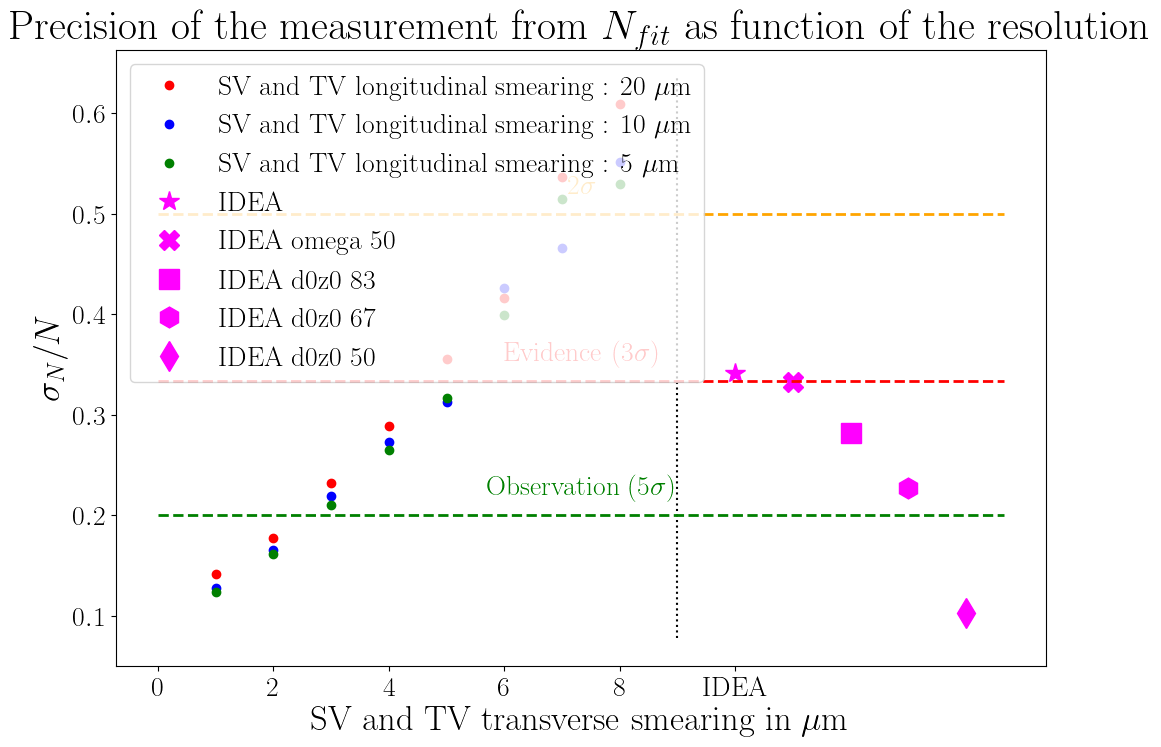

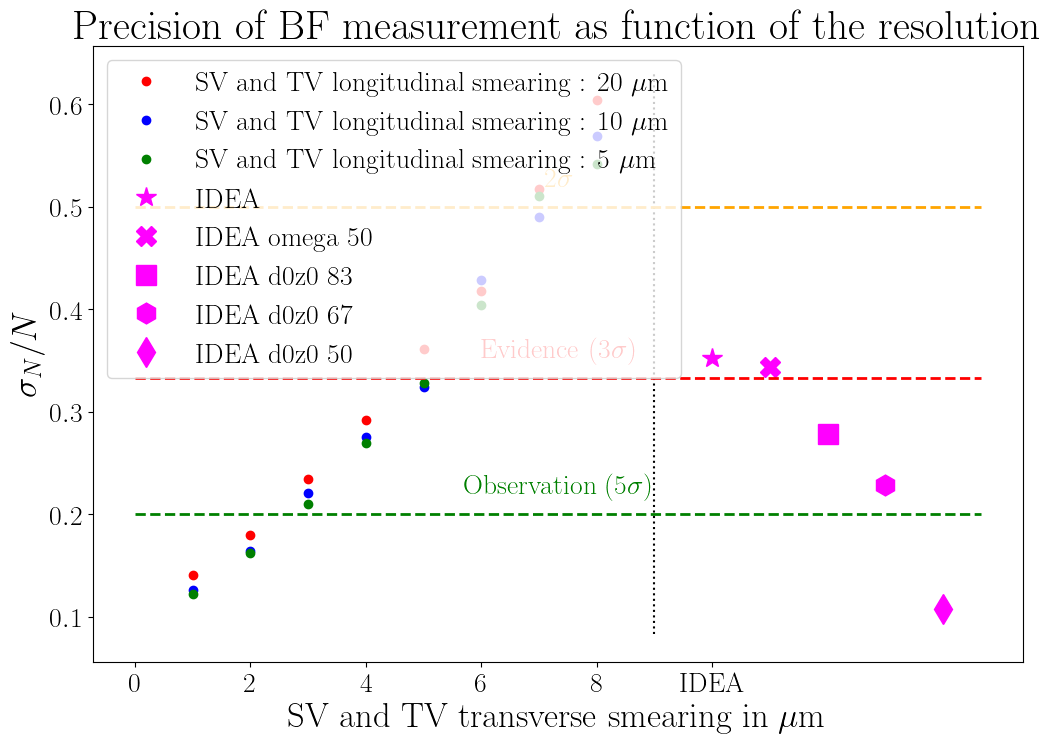

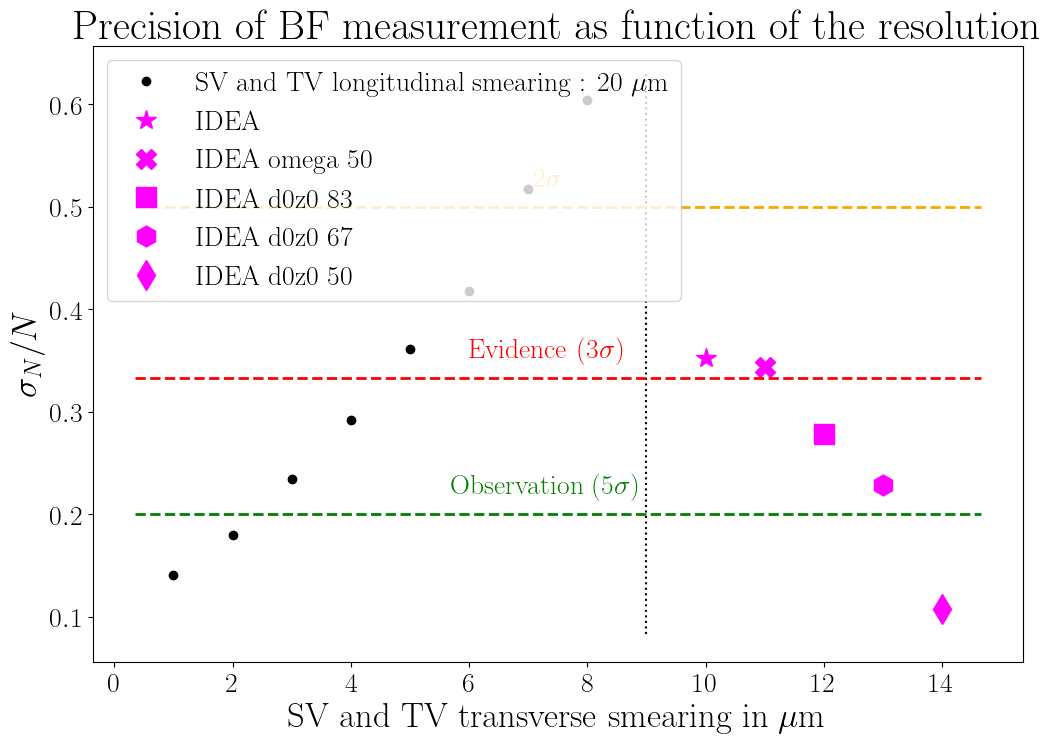

In [61]:
n_sig_fit_20=np.array([])
n_sig_expec_20=np.array([])
sigma_n_sig_fit_20=np.array([])
n_sig_fit_10=np.array([])
n_sig_expec_10=np.array([])
sigma_n_sig_fit_10=np.array([])
n_sig_fit_5=np.array([])
n_sig_expec_5=np.array([])
sigma_n_sig_fit_5=np.array([])

transverse_smearing=[1,2,3,4,5,6,7,8]
for Ts in transverse_smearing:
    n_sig_fit_20=np.append(n_sig_fit_20,np.loadtxt(f'yield_fit/20-{Ts}_n_sig_fit.txt'))
    n_sig_expec_20=np.append(n_sig_expec_20,np.loadtxt(f'yield_fit/20-{Ts}_n_sig_expected.txt'))
    sigma_n_sig_fit_20=np.append(sigma_n_sig_fit_20,np.loadtxt(f'yield_fit/20-{Ts}_sigma_n_sig_fit.txt'))
    n_sig_fit_10=np.append(n_sig_fit_10,np.loadtxt(f'yield_fit/10-{Ts}_n_sig_fit.txt'))
    n_sig_expec_10=np.append(n_sig_expec_10,np.loadtxt(f'yield_fit/10-{Ts}_n_sig_expected.txt'))
    sigma_n_sig_fit_10=np.append(sigma_n_sig_fit_10,np.loadtxt(f'yield_fit/10-{Ts}_sigma_n_sig_fit.txt'))
    n_sig_fit_5=np.append(n_sig_fit_5,np.loadtxt(f'yield_fit/5-{Ts}_n_sig_fit.txt'))
    n_sig_expec_5=np.append(n_sig_expec_5,np.loadtxt(f'yield_fit/5-{Ts}_n_sig_expected.txt'))
    sigma_n_sig_fit_5=np.append(sigma_n_sig_fit_5,np.loadtxt(f'yield_fit/5-{Ts}_sigma_n_sig_fit.txt'))

n_sig_fit_IDEA=np.loadtxt(f'yield_fit/IDEA_n_sig_fit.txt')
n_sig_expec_IDEA=np.loadtxt(f'yield_fit/IDEA_n_sig_expected.txt')
sigma_n_sig_fit_IDEA=np.loadtxt(f'yield_fit/IDEA_sigma_n_sig_fit.txt')
n_sig_fit_IDEA_omega_50=np.loadtxt(f'yield_fit/IDEA_omega_50_n_sig_fit.txt')
n_sig_expec_IDEA_omega_50=np.loadtxt(f'yield_fit/IDEA_omega_50_n_sig_expected.txt')
sigma_n_sig_fit_IDEA_omega_50=np.loadtxt(f'yield_fit/IDEA_omega_50_sigma_n_sig_fit.txt')
n_sig_fit_IDEA_d0z0_83=np.loadtxt(f'yield_fit/IDEA_d0z0_83_n_sig_fit.txt')
n_sig_expec_IDEA_d0z0_83=np.loadtxt(f'yield_fit/IDEA_d0z0_83_n_sig_expected.txt')
sigma_n_sig_fit_IDEA_d0z0_83=np.loadtxt(f'yield_fit/IDEA_d0z0_83_sigma_n_sig_fit.txt')
n_sig_fit_IDEA_d0z0_67=np.loadtxt(f'yield_fit/IDEA_d0z0_67_n_sig_fit.txt')
n_sig_expec_IDEA_d0z0_67=np.loadtxt(f'yield_fit/IDEA_d0z0_67_n_sig_expected.txt')
sigma_n_sig_fit_IDEA_d0z0_67=np.loadtxt(f'yield_fit/IDEA_d0z0_67_sigma_n_sig_fit.txt')
n_sig_fit_IDEA_d0z0_50=np.loadtxt(f'yield_fit/IDEA_d0z0_50_n_sig_fit.txt')
n_sig_expec_IDEA_d0z0_50=np.loadtxt(f'yield_fit/IDEA_d0z0_50_n_sig_expected.txt')
sigma_n_sig_fit_IDEA_d0z0_50=np.loadtxt(f'yield_fit/IDEA_d0z0_50_sigma_n_sig_fit.txt')

precision_fit_20=sigma_n_sig_fit_20/n_sig_fit_20
precision_expec_20=sigma_n_sig_fit_20/n_sig_expec_20
precision_fit_10=sigma_n_sig_fit_10/n_sig_fit_10
precision_expec_10=sigma_n_sig_fit_10/n_sig_expec_10
precision_fit_5=sigma_n_sig_fit_5/n_sig_fit_5
precision_expec_5=sigma_n_sig_fit_5/n_sig_expec_5

precision_fit_IDEA=sigma_n_sig_fit_IDEA/n_sig_fit_IDEA
precision_expec_IDEA=sigma_n_sig_fit_IDEA/n_sig_expec_IDEA
precision_fit_IDEA_omega_50=sigma_n_sig_fit_IDEA_omega_50/n_sig_fit_IDEA_omega_50
precision_expec_IDEA_omega_50=sigma_n_sig_fit_IDEA_omega_50/n_sig_expec_IDEA_omega_50
precision_fit_IDEA_d0z0_83=sigma_n_sig_fit_IDEA_d0z0_83/n_sig_fit_IDEA_d0z0_83
precision_expec_IDEA_d0z0_83=sigma_n_sig_fit_IDEA_d0z0_83/n_sig_expec_IDEA_d0z0_83
precision_fit_IDEA_d0z0_67=sigma_n_sig_fit_IDEA_d0z0_67/n_sig_fit_IDEA_d0z0_67
precision_expec_IDEA_d0z0_67=sigma_n_sig_fit_IDEA_d0z0_67/n_sig_expec_IDEA_d0z0_67
precision_fit_IDEA_d0z0_50=sigma_n_sig_fit_IDEA_d0z0_50/n_sig_fit_IDEA_d0z0_50
precision_expec_IDEA_d0z0_50=sigma_n_sig_fit_IDEA_d0z0_50/n_sig_expec_IDEA_d0z0_50

plt.figure(figsize=(12,8))
plt.title('Precision of the measurement from $N_{fit}$ as function of the resolution')
plt.plot(transverse_smearing, precision_fit_20, 'or', label=f'SV and TV longitudinal smearing : 20 $\mu$m')
plt.plot(transverse_smearing, precision_fit_10, 'ob', label=f'SV and TV longitudinal smearing : 10 $\mu$m')
plt.plot(transverse_smearing, precision_fit_5, 'og', label=f'SV and TV longitudinal smearing : 5 $\mu$m')
plt.plot(10, precision_fit_IDEA, '*', color='magenta',markersize=15, label='IDEA')
plt.plot(11, precision_fit_IDEA_omega_50, 'X', color='magenta',markersize=15, label='IDEA omega 50')
plt.plot(12, precision_fit_IDEA_d0z0_83, 's', color='magenta',markersize=15, label='IDEA d0z0 83')
plt.plot(13, precision_fit_IDEA_d0z0_67, 'h', color='magenta',markersize=15, label='IDEA d0z0 67')
plt.plot(14, precision_fit_IDEA_d0z0_50, 'd', color='magenta',markersize=15, label='IDEA d0z0 50')
ymin, ymax = plt.ylim()
plt.vlines(9,ymin=ymin, ymax=ymax, color='black', linestyle='dotted')
plt.xticks([0,2,4,6,8,10],['0','2','4','6','8','IDEA'])
xmin, xmax = plt.xlim()
plt.hlines(y=1./2.,xmin=xmin, xmax=xmax,color='orange',linestyle='--',lw=2)
plt.text(7.1,1./2+0.02,'2$\\sigma$', color='orange', size=20.)
plt.hlines(y=1./3.,xmin=xmin, xmax=xmax,color='red',linestyle='--',lw=2)
plt.text(6.,1./3+0.02,'Evidence (3$\\sigma$)', color='red', size=20.)
plt.hlines(y=1./5.,xmin=xmin, xmax=xmax,color='green',linestyle='--',lw=2)
plt.text(5.7,1./5+0.02,'Observation (5$\\sigma$)', color='green', size=20.)
plt.xlabel('SV and TV transverse smearing in $\mu$m')
plt.ylabel('$\\sigma_{N}/N$')
plt.legend(loc='upper left')

plt.figure(figsize=(12,8))
plt.title('Precision of BF measurement as function of the resolution')
plt.plot(transverse_smearing, precision_expec_20, 'or', label=f'SV and TV longitudinal smearing : 20 $\mu$m')
plt.plot(transverse_smearing, precision_expec_10, 'ob', label=f'SV and TV longitudinal smearing : 10 $\mu$m')
plt.plot(transverse_smearing, precision_expec_5, 'og', label=f'SV and TV longitudinal smearing : 5 $\mu$m')
plt.plot(10, precision_expec_IDEA, '*', color='magenta',markersize=15, label='IDEA')
plt.plot(11, precision_expec_IDEA_omega_50, 'X', color='magenta',markersize=15, label='IDEA omega 50')
plt.plot(12, precision_expec_IDEA_d0z0_83, 's', color='magenta',markersize=15, label='IDEA d0z0 83')
plt.plot(13, precision_expec_IDEA_d0z0_67, 'h', color='magenta',markersize=15, label='IDEA d0z0 67')
plt.plot(14, precision_expec_IDEA_d0z0_50, 'd', color='magenta',markersize=15, label='IDEA d0z0 50')
ymin, ymax = plt.ylim()
plt.vlines(9,ymin=ymin, ymax=ymax, color='black', linestyle='dotted')
plt.xticks([0,2,4,6,8,10],['0','2','4','6','8','IDEA'])
xmin, xmax = plt.xlim()
plt.hlines(y=1./2.,xmin=xmin, xmax=xmax,color='orange',linestyle='--',lw=2)
plt.text(7.1,1./2+0.02,'2$\\sigma$', color='orange', size=20.)
plt.hlines(y=1./3.,xmin=xmin, xmax=xmax,color='red',linestyle='--',lw=2)
plt.text(6.,1./3+0.02,'Evidence (3$\\sigma$)', color='red', size=20.)
plt.hlines(y=1./5.,xmin=xmin, xmax=xmax,color='green',linestyle='--',lw=2)
plt.text(5.7,1./5+0.02,'Observation (5$\\sigma$)', color='green', size=20.)
plt.xlabel('SV and TV transverse smearing in $\mu$m')
plt.ylabel('$\\sigma_{N}/N$')
plt.legend(loc='upper left')

plt.figure(figsize=(12,8))
plt.title('Precision of BF measurement as function of the resolution')
plt.plot(transverse_smearing, precision_expec_20, 'o', color='black', label=f'SV and TV longitudinal smearing : 20 $\mu$m')
plt.plot(10, precision_expec_IDEA, '*', color='magenta',markersize=15, label='IDEA')
plt.plot(11, precision_expec_IDEA_omega_50, 'X', color='magenta',markersize=15, label='IDEA omega 50')
plt.plot(12, precision_expec_IDEA_d0z0_83, 's', color='magenta',markersize=15, label='IDEA d0z0 83')
plt.plot(13, precision_expec_IDEA_d0z0_67, 'h', color='magenta',markersize=15, label='IDEA d0z0 67')
plt.plot(14, precision_expec_IDEA_d0z0_50, 'd', color='magenta',markersize=15, label='IDEA d0z0 50')
ymin, ymax = plt.ylim()
plt.vlines(9,ymin=ymin, ymax=ymax, color='black', linestyle='dotted')
#plt.xticks([0,2,4,6,8,10],['0','2','4','6','8','IDEA'])
xmin, xmax = plt.xlim()
plt.hlines(y=1./2.,xmin=xmin, xmax=xmax,color='orange',linestyle='--',lw=2)
plt.text(7.1,1./2+0.02,'2$\\sigma$', color='orange', size=20.)
plt.hlines(y=1./3.,xmin=xmin, xmax=xmax,color='red',linestyle='--',lw=2)
plt.text(6.,1./3+0.02,'Evidence (3$\\sigma$)', color='red', size=20.)
plt.hlines(y=1./5.,xmin=xmin, xmax=xmax,color='green',linestyle='--',lw=2)
plt.text(5.7,1./5+0.02,'Observation (5$\\sigma$)', color='green', size=20.)
plt.xlabel('SV and TV transverse smearing in $\mu$m')
plt.ylabel('$\\sigma_{N}/N$')
plt.legend(loc='upper left')

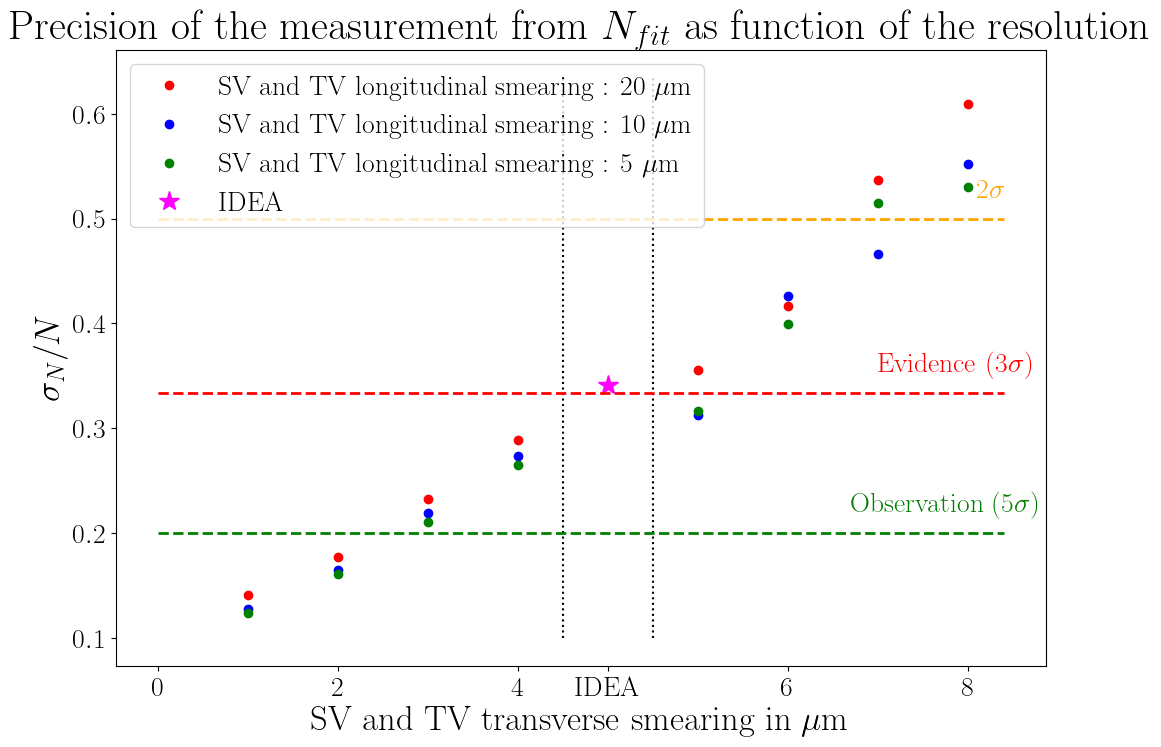

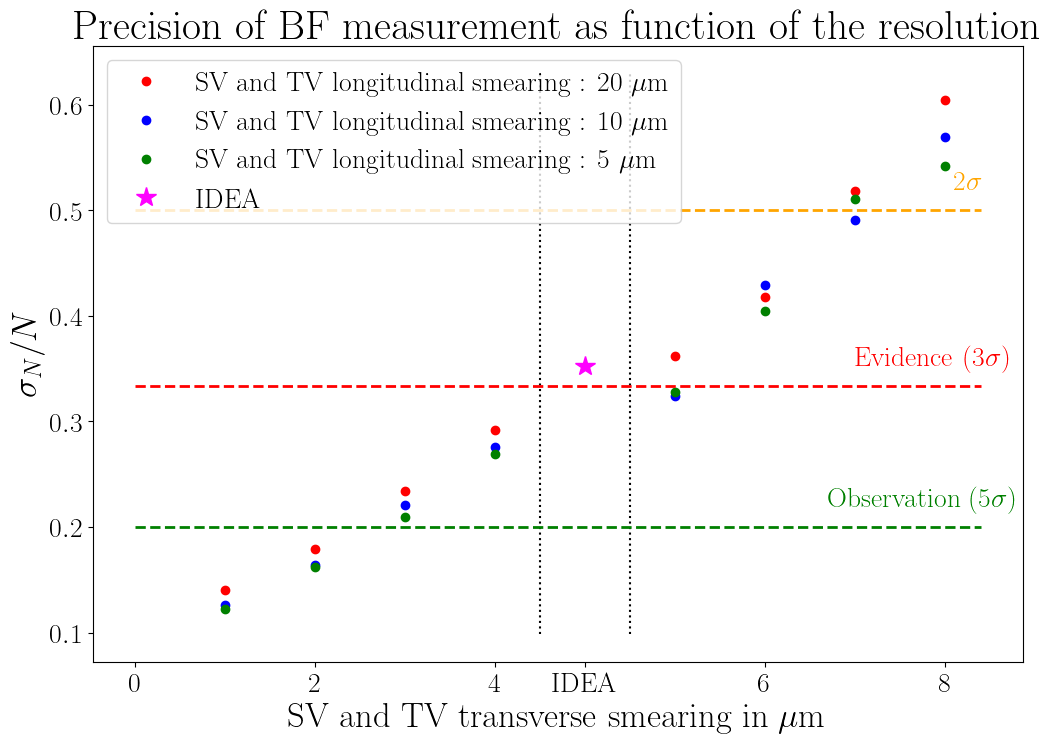

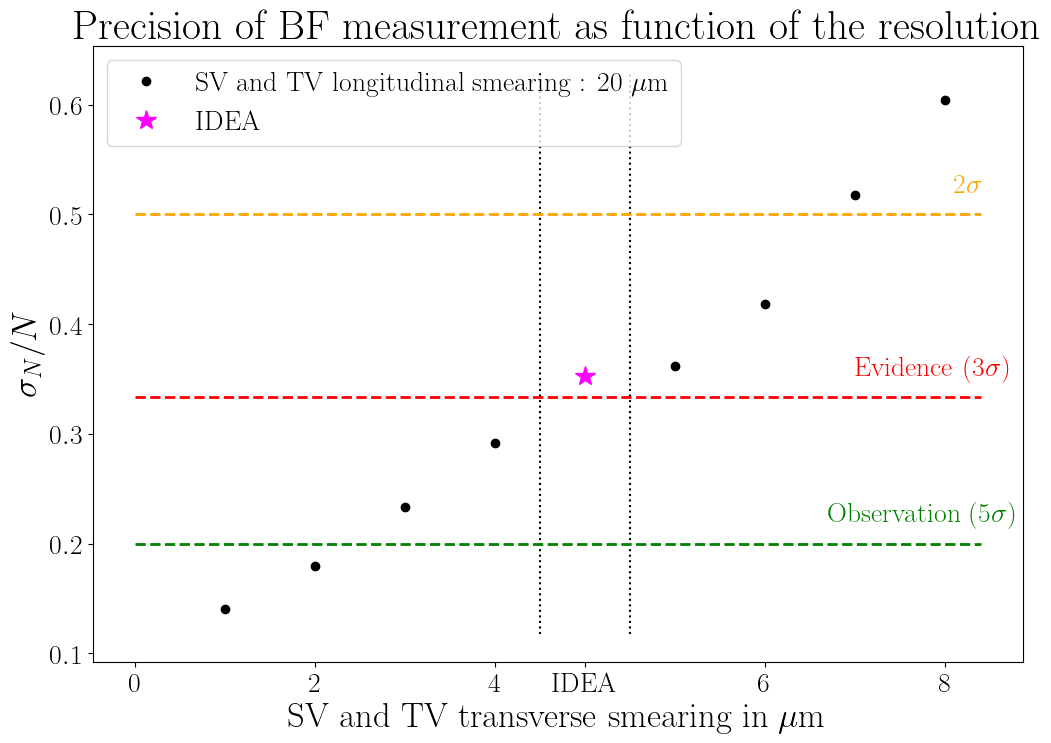

In [62]:
transverse_smearing_modify=transverse_smearing.copy()
transverse_smearing_modify[-1]=9
transverse_smearing_modify[-2]=8
transverse_smearing_modify[-3]=7
transverse_smearing_modify[-4]=6

tranverse_smearing_modify=[2,3,5,7,10,11,12,13]
tranverse_smearing_modify_IDEA=[1,4,6,8,9]
prec_fit_IDEA=[precision_fit_IDEA_d0z0_50,precision_fit_IDEA_d0z0_67,precision_fit_IDEA_d0z0_83,precision_fit_IDEA_omega_50,precision_fit_IDEA]
prec_expec_IDEA=[precision_expec_IDEA_d0z0_50,precision_expec_IDEA_d0z0_67,precision_expec_IDEA_d0z0_83,precision_expec_IDEA_omega_50,precision_expec_IDEA]

plt.figure(figsize=(12,8))
plt.title('Precision of the measurement from $N_{fit}$ as function of the resolution')
plt.plot(transverse_smearing_modify, precision_fit_20, 'or', label=f'SV and TV longitudinal smearing : 20 $\mu$m')
plt.plot(transverse_smearing_modify, precision_fit_10, 'ob', label=f'SV and TV longitudinal smearing : 10 $\mu$m')
plt.plot(transverse_smearing_modify, precision_fit_5, 'og', label=f'SV and TV longitudinal smearing : 5 $\mu$m')
plt.plot(5, precision_fit_IDEA, '*', color='magenta',markersize=15, label='IDEA')
ymin, ymax = plt.ylim()
plt.vlines(4.5,ymin=ymin, ymax=ymax, color='black', linestyle='dotted')
plt.vlines(5.5,ymin=ymin, ymax=ymax, color='black', linestyle='dotted')
#plt.xticks([0,2,4,6,7,9])
plt.xticks([0,2,4,5,7,9],['0','2','4','IDEA','6','8'])
xmin, xmax = plt.xlim()
plt.hlines(y=1./2.,xmin=xmin, xmax=xmax,color='orange',linestyle='--',lw=2)
plt.text(9.1,1./2+0.02,'2$\\sigma$', color='orange', size=20.)
plt.hlines(y=1./3.,xmin=xmin, xmax=xmax,color='red',linestyle='--',lw=2)
plt.text(8.,1./3+0.02,'Evidence (3$\\sigma$)', color='red', size=20.)
plt.hlines(y=1./5.,xmin=xmin, xmax=xmax,color='green',linestyle='--',lw=2)
plt.text(7.7,1./5+0.02,'Observation (5$\\sigma$)', color='green', size=20.)
plt.xlabel('SV and TV transverse smearing in $\mu$m')
plt.ylabel('$\\sigma_{N}/N$')
plt.legend(loc='upper left')

plt.figure(figsize=(12,8))
plt.title('Precision of BF measurement as function of the resolution')
plt.plot(transverse_smearing_modify, precision_expec_20, 'or', label=f'SV and TV longitudinal smearing : 20 $\mu$m')
plt.plot(transverse_smearing_modify, precision_expec_10, 'ob', label=f'SV and TV longitudinal smearing : 10 $\mu$m')
plt.plot(transverse_smearing_modify, precision_expec_5, 'og', label=f'SV and TV longitudinal smearing : 5 $\mu$m')
plt.plot(5, precision_expec_IDEA, '*', color='magenta',markersize=15, label='IDEA')
ymin, ymax = plt.ylim()
plt.vlines(4.5,ymin=ymin, ymax=ymax, color='black', linestyle='dotted')
plt.vlines(5.5,ymin=ymin, ymax=ymax, color='black', linestyle='dotted')
#plt.xticks([0,2,4,6,7,9])
plt.xticks([0,2,4,5,7,9],['0','2','4','IDEA','6','8'])
xmin, xmax = plt.xlim()
plt.hlines(y=1./2.,xmin=xmin, xmax=xmax,color='orange',linestyle='--',lw=2)
plt.text(9.1,1./2+0.02,'2$\\sigma$', color='orange', size=20.)
plt.hlines(y=1./3.,xmin=xmin, xmax=xmax,color='red',linestyle='--',lw=2)
plt.text(8.,1./3+0.02,'Evidence (3$\\sigma$)', color='red', size=20.)
plt.hlines(y=1./5.,xmin=xmin, xmax=xmax,color='green',linestyle='--',lw=2)
plt.text(7.7,1./5+0.02,'Observation (5$\\sigma$)', color='green', size=20.)
plt.xlabel('SV and TV transverse smearing in $\mu$m')
plt.ylabel('$\\sigma_{N}/N$')
plt.legend(loc='upper left')


plt.figure(figsize=(12,8))
plt.title('Precision of BF measurement as function of the resolution')
plt.plot(transverse_smearing_modify, precision_expec_20, 'o', color='black', label=f'SV and TV longitudinal smearing : 20 $\mu$m')
plt.plot(5, precision_expec_IDEA, '*', color='magenta',markersize=15, label='IDEA')
ymin, ymax = plt.ylim()
plt.vlines(4.5,ymin=ymin, ymax=ymax, color='black', linestyle='dotted')
plt.vlines(5.5,ymin=ymin, ymax=ymax, color='black', linestyle='dotted')
#plt.xticks([0,2,4,6,7,9])
plt.xticks([0,2,4,5,7,9],['0','2','4','IDEA','6','8'])
xmin, xmax = plt.xlim()
plt.hlines(y=1./2.,xmin=xmin, xmax=xmax,color='orange',linestyle='--',lw=2)
plt.text(9.1,1./2+0.02,'2$\\sigma$', color='orange', size=20.)
plt.hlines(y=1./3.,xmin=xmin, xmax=xmax,color='red',linestyle='--',lw=2)
plt.text(8.,1./3+0.02,'Evidence (3$\\sigma$)', color='red', size=20.)
plt.hlines(y=1./5.,xmin=xmin, xmax=xmax,color='green',linestyle='--',lw=2)
plt.text(7.7,1./5+0.02,'Observation (5$\\sigma$)', color='green', size=20.)
plt.xlabel('SV and TV transverse smearing in $\mu$m')
plt.ylabel('$\\sigma_{N}/N$')
plt.legend(loc='upper left')

/var/folders/hc/7r1d6y954cscdrl_dhs2jt_w0000gn/T/ipykernel_2282/843193314.py:23: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([L20_line, L10_line, L5_line],     # The line objects
/var/folders/hc/7r1d6y954cscdrl_dhs2jt_w0000gn/T/ipykernel_2282/843193314.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([L20_line, L10_line, L5_line],     # The line objects
/var/folders/hc/7r1d6y954cscdrl_dhs2jt_w0000gn/T/ipykernel_2282/843193314.py:87: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([L20_line],     # The line objects


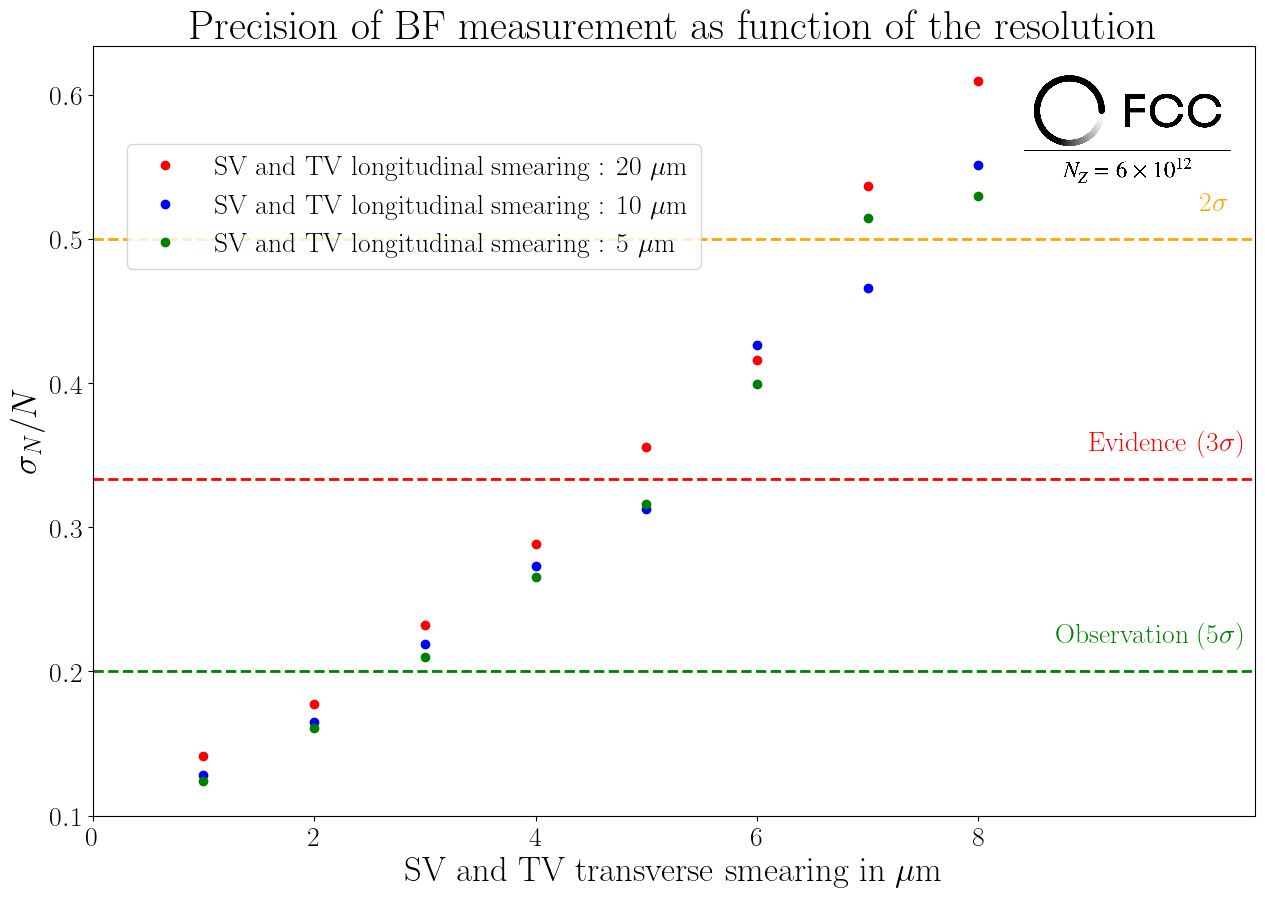

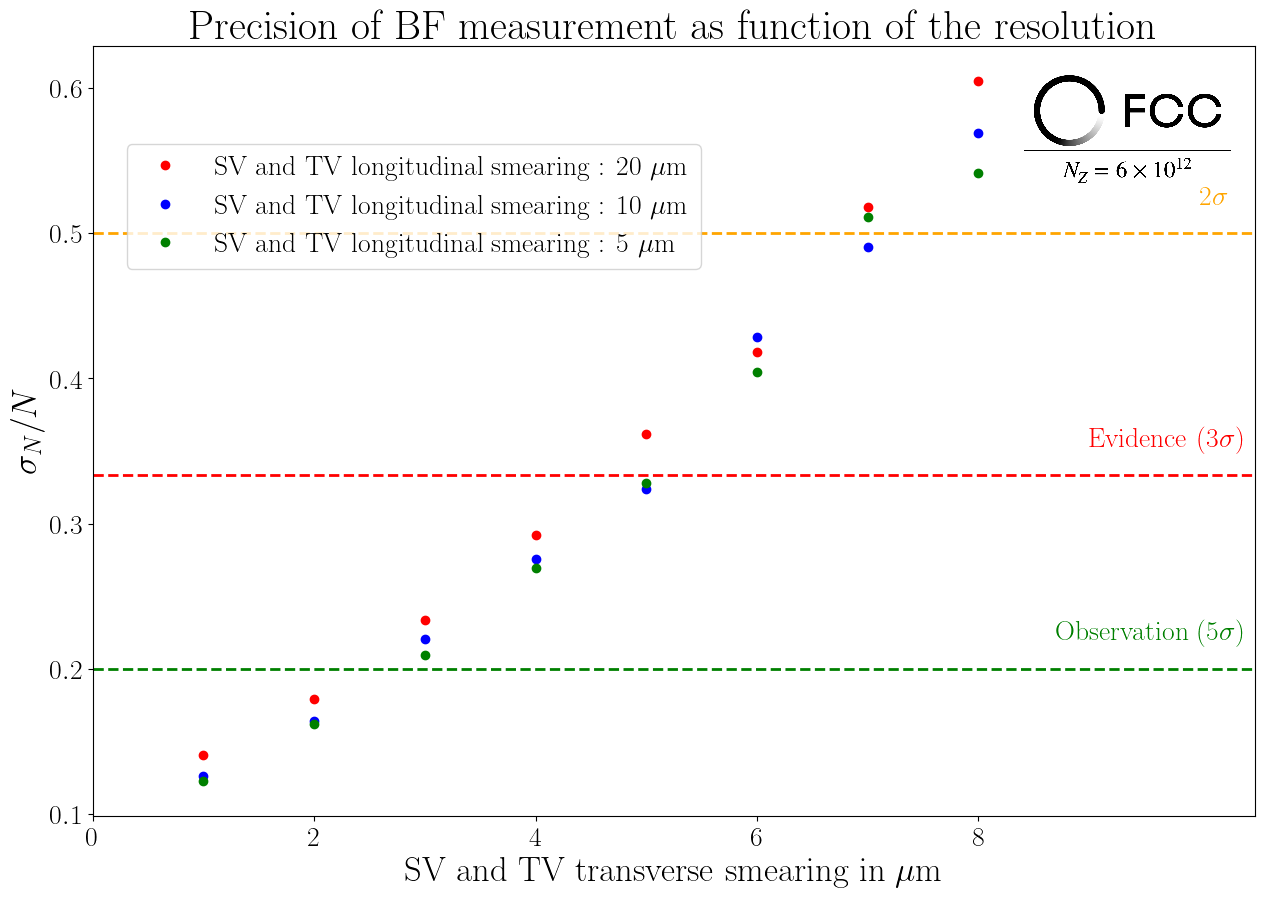

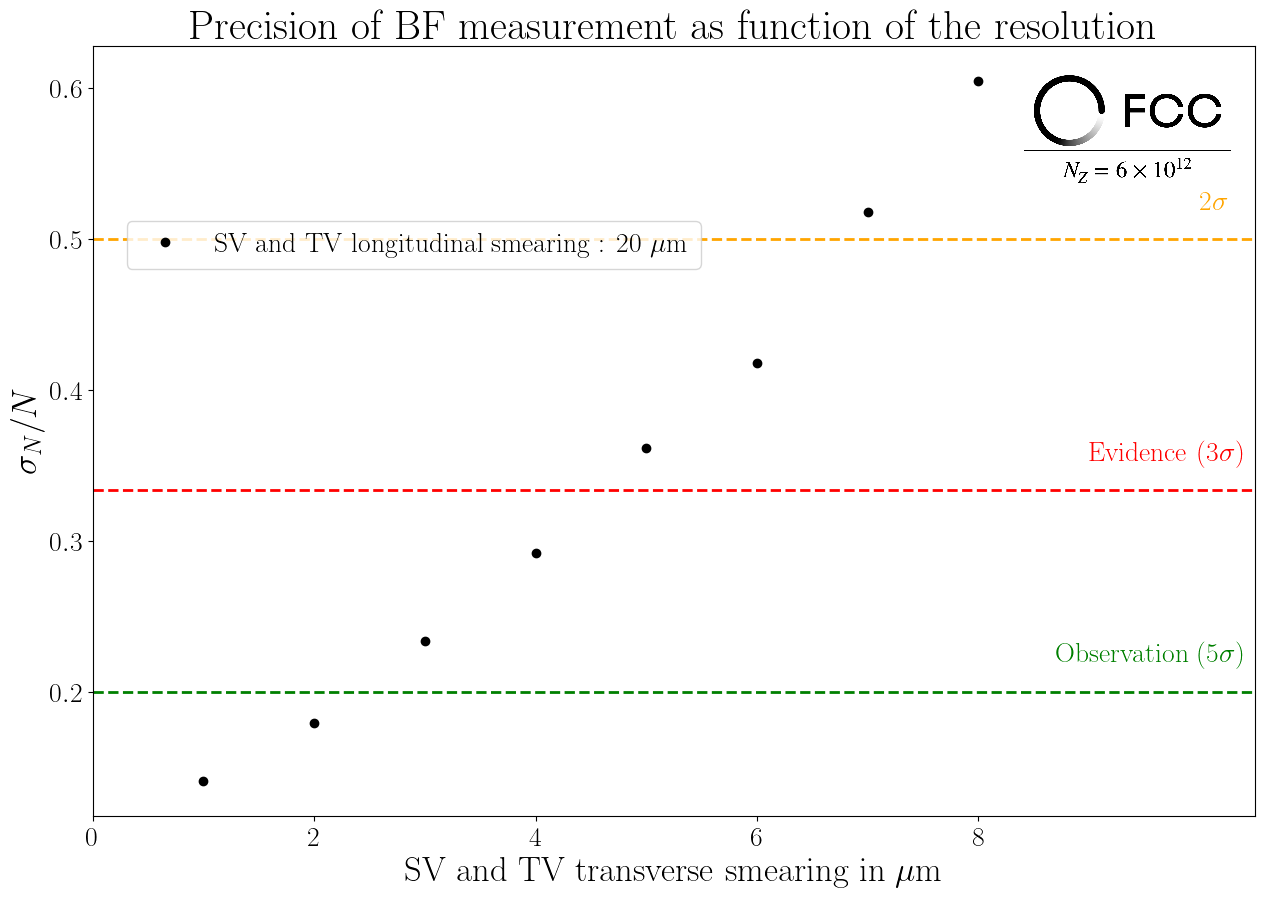

In [63]:
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(111, label="1")
L20_line=ax.plot(transverse_smearing, precision_fit_20, 'o', color='red', label=f'SV and TV longitudinal smearing : 20 $\mu$m')
L10_line=ax.plot(transverse_smearing, precision_fit_10, 'o', color='blue', label=f'SV and TV longitudinal smearing : 10 $\mu$m')
L5_line=ax.plot(transverse_smearing, precision_fit_5, 'o', color='green', label=f'SV and TV longitudinal smearing : 5 $\mu$m')
ax.set_xlabel('SV and TV transverse smearing in $\mu$m')
ax.set_ylabel('$\\sigma_{N}/N$')
ax.set_xticks([0,2,4,6,8])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
ax.tick_params(axis='x', colors="black")
ax.tick_params(axis='y', colors="black")
ax.set_xlim(0.,10.5)
xmin, xmax = ax.get_xlim()
ax.hlines(y=1./2.,xmin=xmin, xmax=xmax,color='orange',linestyle='--',lw=2)
ax.text(10.,1./2+0.02,'2$\\sigma$', color='orange', size=20.)
ax.hlines(y=1./3.,xmin=xmin, xmax=xmax,color='red',linestyle='--',lw=2)
ax.text(9.,1./3+0.02,'Evidence (3$\\sigma$)', color='red', size=20.)
ax.hlines(y=1./5.,xmin=xmin, xmax=xmax,color='green',linestyle='--',lw=2)
ax.text(8.7,1./5+0.02,'Observation (5$\\sigma$)', color='green', size=20.)
ax.set_title("Precision of BF measurement as function of the resolution")
# Create the legend
line_labels=["SV and TV longitudinal smearing : 20 $\mu$m","SV and TV longitudinal smearing : 10 $\mu$m","SV and TV longitudinal smearing : 5 $\mu$m"]
fig.legend([L20_line, L10_line, L5_line],     # The line objects
           labels=line_labels,   # The labels for each line
           loc=(0.1,0.7),   # Position of legend
           )
x_im=0.83
y_im=0.82
imagebox = OffsetImage(im, zoom = 0.1)
imagebox.image.axes = ax
ab = AnnotationBbox(imagebox, (x_im + 0.06, y_im + 0.072), xycoords='axes fraction', frameon = False)
ax.add_artist(ab)

fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(111, label="1")
L20_line=ax.plot(transverse_smearing, precision_expec_20, 'o', color='red', label=f'SV and TV longitudinal smearing : 20 $\mu$m')
L10_line=ax.plot(transverse_smearing, precision_expec_10, 'o', color='blue', label=f'SV and TV longitudinal smearing : 10 $\mu$m')
L5_line=ax.plot(transverse_smearing, precision_expec_5, 'o', color='green', label=f'SV and TV longitudinal smearing : 5 $\mu$m')
ax.set_xlabel('SV and TV transverse smearing in $\mu$m')
ax.set_ylabel('$\\sigma_{N}/N$')
ax.set_xticks([0,2,4,6,8])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
ax.tick_params(axis='x', colors="black")
ax.tick_params(axis='y', colors="black")
ax.set_xlim(0.,10.5)
xmin, xmax = ax.get_xlim()
ax.hlines(y=1./2.,xmin=xmin, xmax=xmax,color='orange',linestyle='--',lw=2)
ax.text(10.,1./2+0.02,'2$\\sigma$', color='orange', size=20.)
ax.hlines(y=1./3.,xmin=xmin, xmax=xmax,color='red',linestyle='--',lw=2)
ax.text(9.,1./3+0.02,'Evidence (3$\\sigma$)', color='red', size=20.)
ax.hlines(y=1./5.,xmin=xmin, xmax=xmax,color='green',linestyle='--',lw=2)
ax.text(8.7,1./5+0.02,'Observation (5$\\sigma$)', color='green', size=20.)
ax.set_title("Precision of BF measurement as function of the resolution")
# Create the legend
line_labels=["SV and TV longitudinal smearing : 20 $\mu$m","SV and TV longitudinal smearing : 10 $\mu$m","SV and TV longitudinal smearing : 5 $\mu$m"]
fig.legend([L20_line, L10_line, L5_line],     # The line objects
           labels=line_labels,   # The labels for each line
           loc=(0.1,0.7),   # Position of legend
           )
x_im=0.83
y_im=0.82
imagebox = OffsetImage(im, zoom = 0.1)
imagebox.image.axes = ax
ab = AnnotationBbox(imagebox, (x_im + 0.06, y_im + 0.072), xycoords='axes fraction', frameon = False)
ax.add_artist(ab)

fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(111, label="1")
L20_line=ax.plot(transverse_smearing, precision_expec_20, 'o', color='black', label=f'SV and TV longitudinal smearing : 20 $\mu$m')
ax.set_xlabel('SV and TV transverse smearing in $\mu$m')
ax.set_ylabel('$\\sigma_{N}/N$')
ax.set_xticks([0,2,4,6,8])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
ax.tick_params(axis='x', colors="black")
ax.tick_params(axis='y', colors="black")
ax.set_xlim(0.,10.5)
xmin, xmax = ax.get_xlim()
ax.hlines(y=1./2.,xmin=xmin, xmax=xmax,color='orange',linestyle='--',lw=2)
ax.text(10.,1./2+0.02,'2$\\sigma$', color='orange', size=20.)
ax.hlines(y=1./3.,xmin=xmin, xmax=xmax,color='red',linestyle='--',lw=2)
ax.text(9.,1./3+0.02,'Evidence (3$\\sigma$)', color='red', size=20.)
ax.hlines(y=1./5.,xmin=xmin, xmax=xmax,color='green',linestyle='--',lw=2)
ax.text(8.7,1./5+0.02,'Observation (5$\\sigma$)', color='green', size=20.)
ax.set_title("Precision of BF measurement as function of the resolution")
# Create the legend
line_labels=["SV and TV longitudinal smearing : 20 $\mu$m"]
fig.legend([L20_line],     # The line objects
           labels=line_labels,   # The labels for each line
           loc=(0.1,0.7),   # Position of legend
           )
x_im=0.83
y_im=0.82
imagebox = OffsetImage(im, zoom = 0.1)
imagebox.image.axes = ax
ab = AnnotationBbox(imagebox, (x_im + 0.06, y_im + 0.072), xycoords='axes fraction', frameon = False)
ax.add_artist(ab);

/var/folders/hc/7r1d6y954cscdrl_dhs2jt_w0000gn/T/ipykernel_2282/3516926412.py:37: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([L20_line, L10_line, L5_line, IDEA_line, IDEA_baseline],     # The line objects
/var/folders/hc/7r1d6y954cscdrl_dhs2jt_w0000gn/T/ipykernel_2282/3516926412.py:79: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([L20_line, L10_line, L5_line, IDEA_line, IDEA_baseline],     # The line objects
/var/folders/hc/7r1d6y954cscdrl_dhs2jt_w0000gn/T/ipykernel_2282/3516926412.py:120: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([L20_line, IDEA_line, IDEA_baseline],     # The line objects


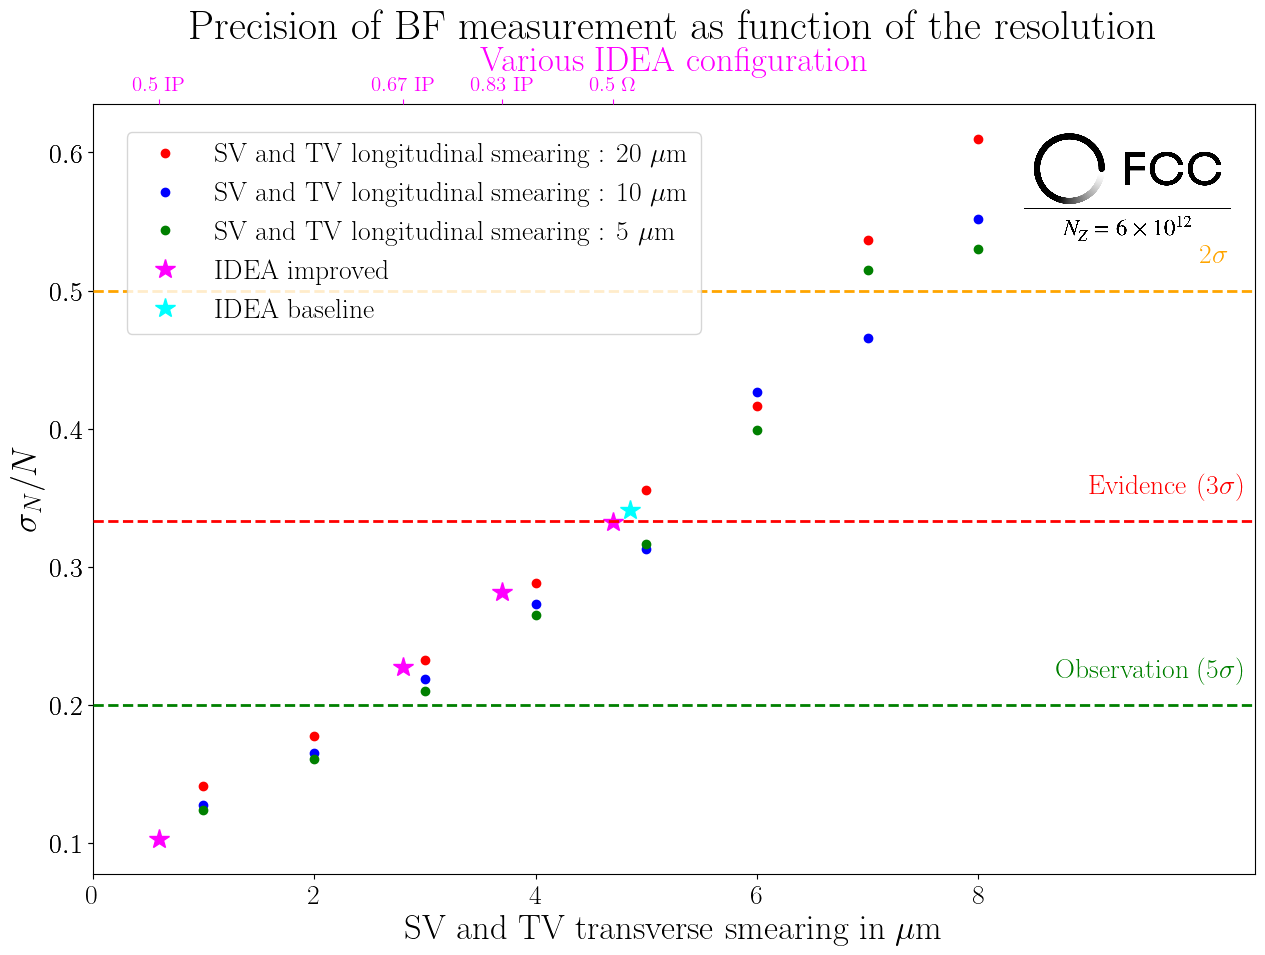

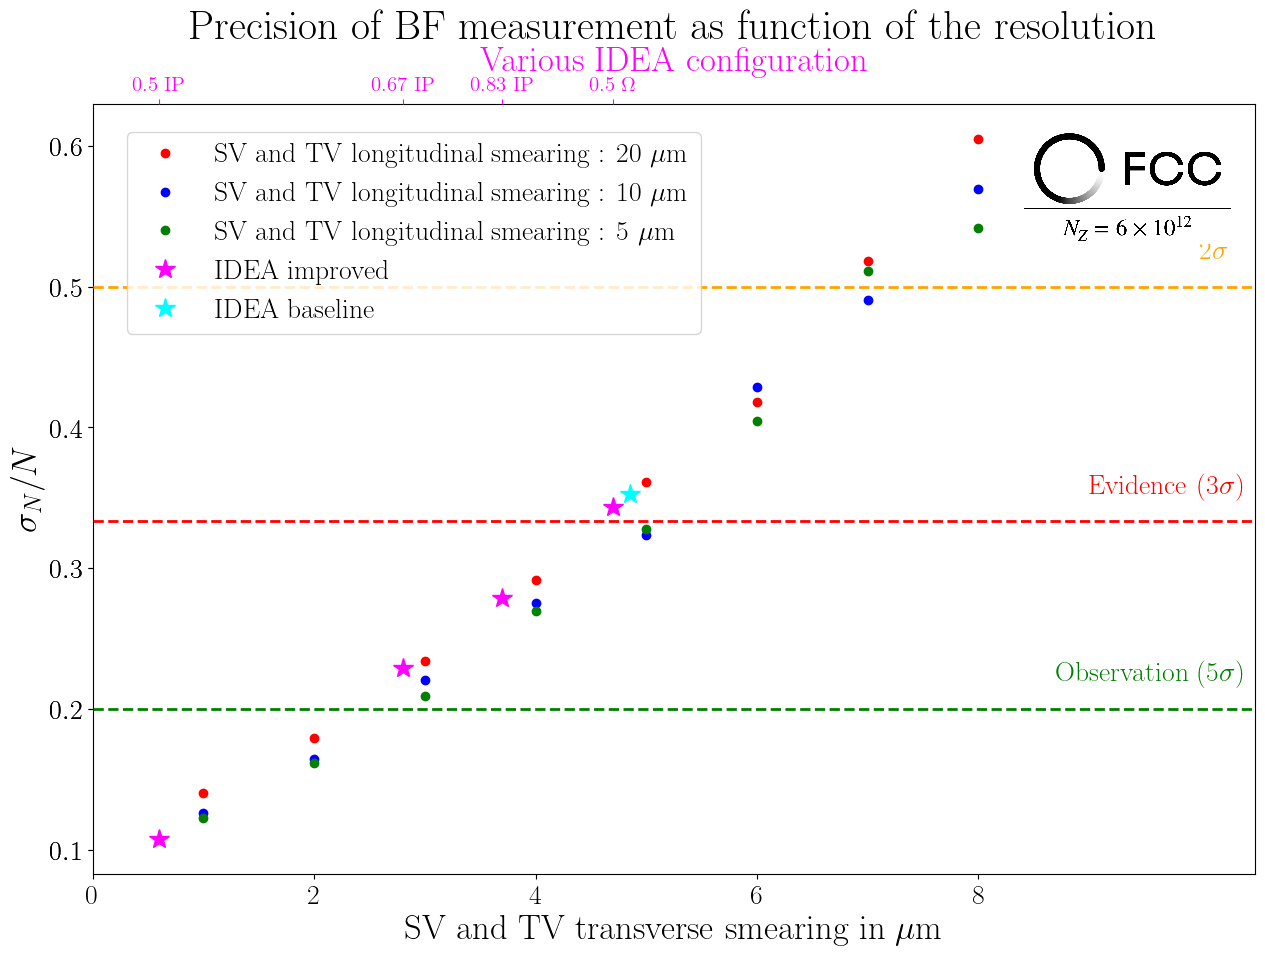

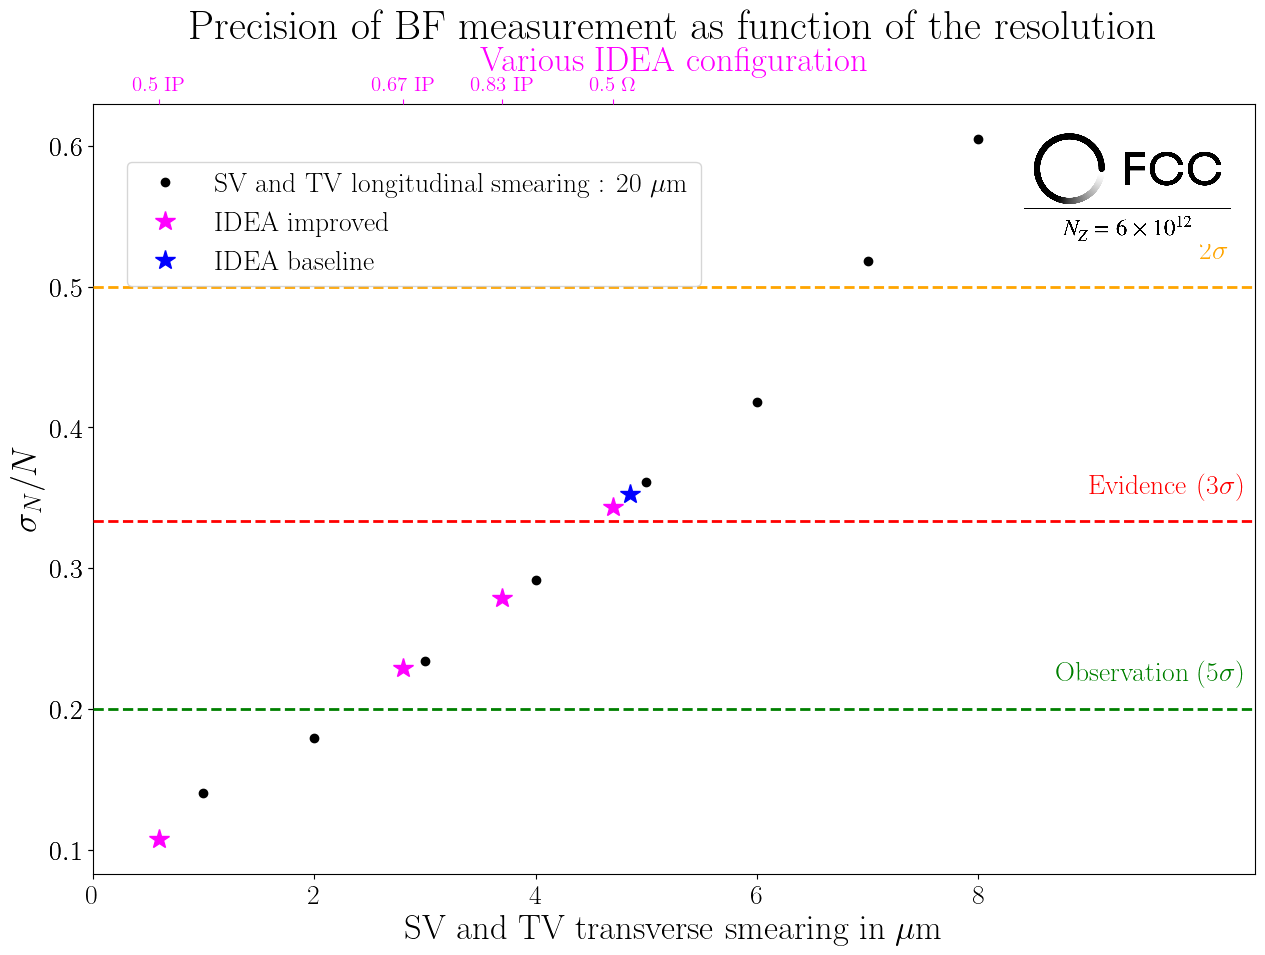

In [64]:
transverse_smearing_modify_IDEA=[0.5,2.8,3.9,4.7]
prec_fit_IDEA=[precision_fit_IDEA_d0z0_50,precision_fit_IDEA_d0z0_67,precision_fit_IDEA_d0z0_83,precision_fit_IDEA_omega_50]
prec_expec_IDEA=[precision_expec_IDEA_d0z0_50,precision_expec_IDEA_d0z0_67,precision_expec_IDEA_d0z0_83,precision_expec_IDEA_omega_50]
transverse_smearing_modify_IDEA=[0.6,2.8,3.7,4.7]

fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False,sharey=ax)
L20_line=ax.plot(transverse_smearing, precision_fit_20, 'o', color='red', label=f'SV and TV longitudinal smearing : 20 $\mu$m')
L10_line=ax.plot(transverse_smearing, precision_fit_10, 'o', color='blue', label=f'SV and TV longitudinal smearing : 10 $\mu$m')
L5_line=ax.plot(transverse_smearing, precision_fit_5, 'o', color='green', label=f'SV and TV longitudinal smearing : 5 $\mu$m')
ax.set_xlabel('SV and TV transverse smearing in $\mu$m')
ax.set_ylabel('$\\sigma_{N}/N$')
ax.set_xticks([0,2,4,6,8])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
ax.tick_params(axis='x', colors="black")
ax.tick_params(axis='y', colors="black")
ax.set_xlim(0.,10.5)
IDEA_line=ax2.plot(transverse_smearing_modify_IDEA, prec_fit_IDEA, '*', color='magenta', markersize=15, label='IDEA improved')
IDEA_baseline=ax2.plot(4.85, precision_fit_IDEA, '*', color='cyan', markersize=15, label='IDEA baseline')
ax2.xaxis.tick_top()
ax2.set_xticks(transverse_smearing_modify_IDEA,['0.5 IP','0.67 IP','0.83 IP','0.5 $\\Omega$'])
ax2.set_xlabel('Various IDEA configuration', color="magenta")     
ax2.xaxis.set_label_position('top') 
ax2.tick_params(axis='x', colors="magenta",labelsize=15)
ax2.set_xlim(0.,10.5)
xmin, xmax = ax2.get_xlim()
ax2.hlines(y=1./2.,xmin=xmin, xmax=xmax,color='orange',linestyle='--',lw=2)
ax2.text(10.,1./2+0.02,'2$\\sigma$', color='orange', size=20.)
ax2.hlines(y=1./3.,xmin=xmin, xmax=xmax,color='red',linestyle='--',lw=2)
ax2.text(9.,1./3+0.02,'Evidence (3$\\sigma$)', color='red', size=20.)
ax2.hlines(y=1./5.,xmin=xmin, xmax=xmax,color='green',linestyle='--',lw=2)
ax2.text(8.7,1./5+0.02,'Observation (5$\\sigma$)', color='green', size=20.)
ax2.set_title("Precision of BF measurement as function of the resolution")
# Create the legend
line_labels=["SV and TV longitudinal smearing : 20 $\mu$m","SV and TV longitudinal smearing : 10 $\mu$m","SV and TV longitudinal smearing : 5 $\mu$m","IDEA improved","IDEA baseline"]
fig.legend([L20_line, L10_line, L5_line, IDEA_line, IDEA_baseline],     # The line objects
           labels=line_labels,   # The labels for each line
           loc=(0.1,0.65),   # Position of legend
           )
x_im=0.83
y_im=0.82
imagebox = OffsetImage(im, zoom = 0.1)
imagebox.image.axes = ax2
ab = AnnotationBbox(imagebox, (x_im + 0.06, y_im + 0.072), xycoords='axes fraction', frameon = False)
ax2.add_artist(ab)

fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False,sharey=ax)
L20_line=ax.plot(transverse_smearing, precision_expec_20, 'o', color='red', label=f'SV and TV longitudinal smearing : 20 $\mu$m')
L10_line=ax.plot(transverse_smearing, precision_expec_10, 'o', color='blue', label=f'SV and TV longitudinal smearing : 10 $\mu$m')
L5_line=ax.plot(transverse_smearing, precision_expec_5, 'o', color='green', label=f'SV and TV longitudinal smearing : 5 $\mu$m')
ax.set_xlabel('SV and TV transverse smearing in $\mu$m')
ax.set_ylabel('$\\sigma_{N}/N$')
ax.set_xticks([0,2,4,6,8])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
ax.tick_params(axis='x', colors="black")
ax.tick_params(axis='y', colors="black")
ax.set_xlim(0.,10.5)
IDEA_line=ax2.plot(transverse_smearing_modify_IDEA, prec_expec_IDEA, '*', color='magenta', markersize=15, label='IDEA improved')
IDEA_baseline=ax2.plot(4.85, precision_expec_IDEA, '*', color='cyan', markersize=15, label='IDEA baseline')
ax2.xaxis.tick_top()
ax2.set_xticks(transverse_smearing_modify_IDEA,['0.5 IP','0.67 IP','0.83 IP','0.5 $\\Omega$'])
ax2.set_xlabel('Various IDEA configuration', color="magenta")     
ax2.xaxis.set_label_position('top') 
ax2.tick_params(axis='x', colors="magenta",labelsize=15)
ax2.set_xlim(0.,10.5)
xmin, xmax = ax2.get_xlim()
ax2.hlines(y=1./2.,xmin=xmin, xmax=xmax,color='orange',linestyle='--',lw=2)
ax2.text(10.,1./2+0.02,'2$\\sigma$', color='orange', size=20.)
ax2.hlines(y=1./3.,xmin=xmin, xmax=xmax,color='red',linestyle='--',lw=2)
ax2.text(9.,1./3+0.02,'Evidence (3$\\sigma$)', color='red', size=20.)
ax2.hlines(y=1./5.,xmin=xmin, xmax=xmax,color='green',linestyle='--',lw=2)
ax2.text(8.7,1./5+0.02,'Observation (5$\\sigma$)', color='green', size=20.)
ax2.set_title("Precision of BF measurement as function of the resolution")
# Create the legend
line_labels=["SV and TV longitudinal smearing : 20 $\mu$m","SV and TV longitudinal smearing : 10 $\mu$m","SV and TV longitudinal smearing : 5 $\mu$m","IDEA improved","IDEA baseline"]
fig.legend([L20_line, L10_line, L5_line, IDEA_line, IDEA_baseline],     # The line objects
           labels=line_labels,   # The labels for each line
           loc=(0.1,0.65),   # Position of legend
           )
x_im=0.83
y_im=0.82
imagebox = OffsetImage(im, zoom = 0.1)
imagebox.image.axes = ax2
ab = AnnotationBbox(imagebox, (x_im + 0.06, y_im + 0.072), xycoords='axes fraction', frameon = False)
ax2.add_artist(ab)

fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False,sharey=ax)
L20_line=ax.plot(transverse_smearing, precision_expec_20, 'o', color='black', label=f'SV and TV longitudinal smearing : 20 $\mu$m')
ax.set_xlabel('SV and TV transverse smearing in $\mu$m')
ax.set_ylabel('$\\sigma_{N}/N$')
ax.set_xticks([0,2,4,6,8])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
ax.tick_params(axis='x', colors="black")
ax.tick_params(axis='y', colors="black")
ax.set_xlim(0.,10.5)
IDEA_line=ax2.plot(transverse_smearing_modify_IDEA, prec_expec_IDEA, '*', color='magenta', markersize=15, label='IDEA improved')
IDEA_baseline=ax2.plot(4.85, precision_expec_IDEA, '*', color='blue', markersize=15, label='IDEA baseline')
ax2.xaxis.tick_top()
ax2.set_xticks(transverse_smearing_modify_IDEA,['0.5 IP','0.67 IP','0.83 IP','0.5 $\\Omega$'])
ax2.set_xlabel('Various IDEA configuration', color="magenta")
#ax2.set_xlabel('Various IDEA configuration (placed at interpolated position w.r.t. the others)', color="magenta") 
ax2.xaxis.set_label_position('top') 
ax2.tick_params(axis='x', colors="magenta",labelsize=15)
ax2.set_xlim(0.,10.5)
xmin, xmax = ax2.get_xlim()
ax2.hlines(y=1./2.,xmin=xmin, xmax=xmax,color='orange',linestyle='--',lw=2)
ax2.text(10.,1./2+0.02,'2$\\sigma$', color='orange', size=20.)
ax2.hlines(y=1./3.,xmin=xmin, xmax=xmax,color='red',linestyle='--',lw=2)
ax2.text(9.,1./3+0.02,'Evidence (3$\\sigma$)', color='red', size=20.)
ax2.hlines(y=1./5.,xmin=xmin, xmax=xmax,color='green',linestyle='--',lw=2)
ax2.text(8.7,1./5+0.02,'Observation (5$\\sigma$)', color='green', size=20.)
ax2.set_title("Precision of BF measurement as function of the resolution")
# Create the legend
line_labels=["SV and TV longitudinal smearing : 20 $\mu$m","IDEA improved","IDEA baseline"]
fig.legend([L20_line, IDEA_line, IDEA_baseline],     # The line objects
           labels=line_labels,   # The labels for each line
           loc=(0.1,0.7),   # Position of legend
           )
x_im=0.83
y_im=0.82
imagebox = OffsetImage(im, zoom = 0.1)
imagebox.image.axes = ax2
ab = AnnotationBbox(imagebox, (x_im + 0.06, y_im + 0.072), xycoords='axes fraction', frameon = False)
ax2.add_artist(ab);

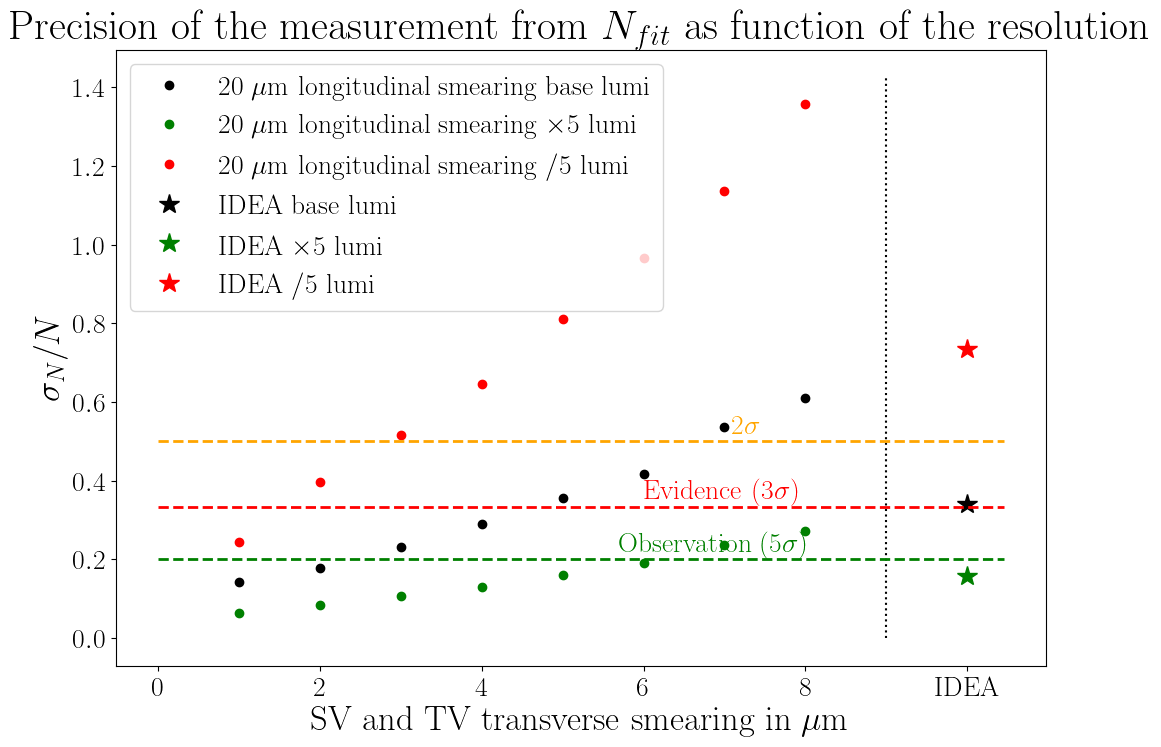

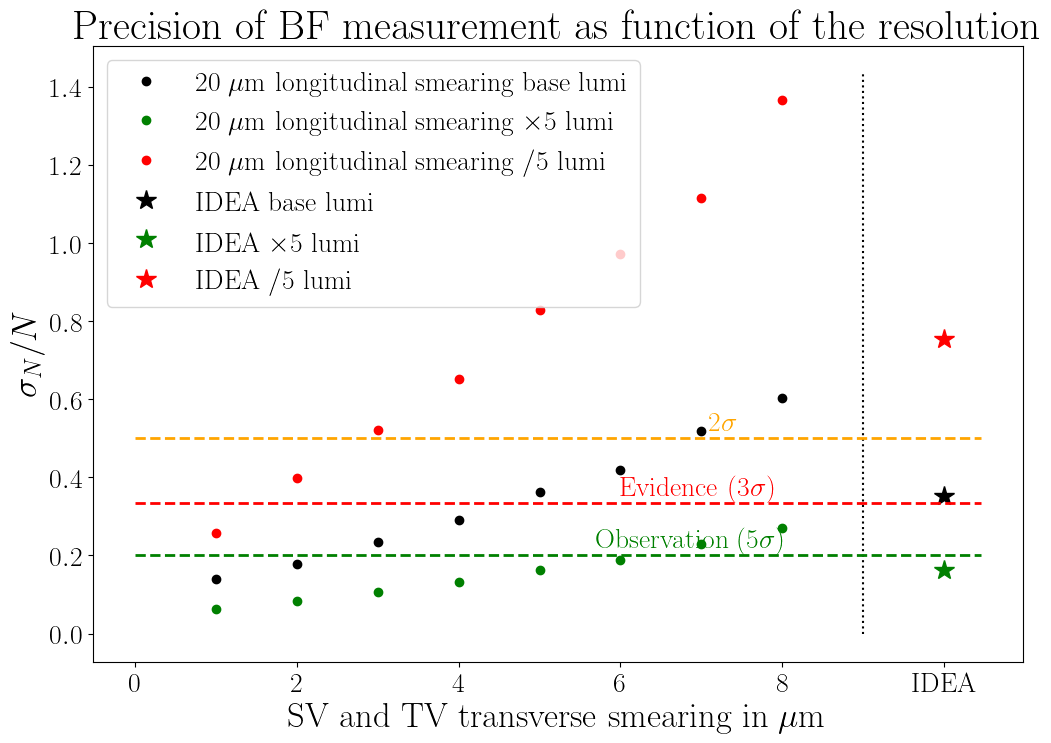

In [65]:
n_sig_fit_20=np.array([])
n_sig_expec_20=np.array([])
sigma_n_sig_fit_20=np.array([])
n_sig_fit_time_5=np.array([])
n_sig_expec_time_5=np.array([])
sigma_n_sig_fit_time_5=np.array([])
n_sig_fit_div_5=np.array([])
n_sig_expec_div_5=np.array([])
sigma_n_sig_fit_div_5=np.array([])

transverse_smearing=[1,2,3,4,5,6,7,8]
for Ts in transverse_smearing:
    n_sig_fit_20=np.append(n_sig_fit_20,np.loadtxt(f'yield_fit/20-{Ts}_n_sig_fit.txt'))
    n_sig_expec_20=np.append(n_sig_expec_20,np.loadtxt(f'yield_fit/20-{Ts}_n_sig_expected.txt'))
    sigma_n_sig_fit_20=np.append(sigma_n_sig_fit_20,np.loadtxt(f'yield_fit/20-{Ts}_sigma_n_sig_fit.txt'))
    n_sig_fit_time_5=np.append(n_sig_fit_time_5,np.loadtxt(f'yield_fit_time_5/20-{Ts}_n_sig_fit.txt'))
    n_sig_expec_time_5=np.append(n_sig_expec_time_5,np.loadtxt(f'yield_fit_time_5/20-{Ts}_n_sig_expected.txt'))
    sigma_n_sig_fit_time_5=np.append(sigma_n_sig_fit_time_5,np.loadtxt(f'yield_fit_time_5/20-{Ts}_sigma_n_sig_fit.txt'))
    n_sig_fit_div_5=np.append(n_sig_fit_div_5,np.loadtxt(f'yield_fit_div_5/20-{Ts}_n_sig_fit.txt'))
    n_sig_expec_div_5=np.append(n_sig_expec_div_5,np.loadtxt(f'yield_fit_div_5/20-{Ts}_n_sig_expected.txt'))
    sigma_n_sig_fit_div_5=np.append(sigma_n_sig_fit_div_5,np.loadtxt(f'yield_fit_div_5/20-{Ts}_sigma_n_sig_fit.txt'))

n_sig_fit_IDEA=np.loadtxt(f'yield_fit/IDEA_n_sig_fit.txt')
n_sig_expec_IDEA=np.loadtxt(f'yield_fit/IDEA_n_sig_expected.txt')
sigma_n_sig_fit_IDEA=np.loadtxt(f'yield_fit/IDEA_sigma_n_sig_fit.txt')
n_sig_fit_IDEA_time_5=np.loadtxt(f'yield_fit_time_5/IDEA_n_sig_fit.txt')
n_sig_expec_IDEA_time_5=np.loadtxt(f'yield_fit_time_5/IDEA_n_sig_expected.txt')
sigma_n_sig_fit_IDEA_time_5=np.loadtxt(f'yield_fit_time_5/IDEA_sigma_n_sig_fit.txt')
n_sig_fit_IDEA_div_5=np.loadtxt(f'yield_fit_div_5/IDEA_n_sig_fit.txt')
n_sig_expec_IDEA_div_5=np.loadtxt(f'yield_fit_div_5/IDEA_n_sig_expected.txt')
sigma_n_sig_fit_IDEA_div_5=np.loadtxt(f'yield_fit_div_5/IDEA_sigma_n_sig_fit.txt')

precision_fit_20=sigma_n_sig_fit_20/n_sig_fit_20
precision_expec_20=sigma_n_sig_fit_20/n_sig_expec_20
precision_fit_time_5=sigma_n_sig_fit_time_5/n_sig_fit_time_5
precision_expec_time_5=sigma_n_sig_fit_time_5/n_sig_expec_time_5
precision_fit_div_5=sigma_n_sig_fit_div_5/n_sig_fit_div_5
precision_expec_div_5=sigma_n_sig_fit_div_5/n_sig_expec_div_5

precision_fit_IDEA=sigma_n_sig_fit_IDEA/n_sig_fit_IDEA
precision_expec_IDEA=sigma_n_sig_fit_IDEA/n_sig_expec_IDEA
precision_fit_IDEA_time_5=sigma_n_sig_fit_IDEA_time_5/n_sig_fit_IDEA_time_5
precision_expec_IDEA_time_5=sigma_n_sig_fit_IDEA_time_5/n_sig_expec_IDEA_time_5
precision_fit_IDEA_div_5=sigma_n_sig_fit_IDEA_div_5/n_sig_fit_IDEA_div_5
precision_expec_IDEA_div_5=sigma_n_sig_fit_IDEA_div_5/n_sig_expec_IDEA_div_5

plt.figure(figsize=(12,8))
plt.title('Precision of the measurement from $N_{fit}$ as function of the resolution')
plt.plot(transverse_smearing, precision_fit_20, 'o', color='black', label=f'20 $\mu$m longitudinal smearing base lumi')
plt.plot(transverse_smearing, precision_fit_time_5, 'og', label=f'20 $\mu$m longitudinal smearing $\\times 5$ lumi')
plt.plot(transverse_smearing, precision_fit_div_5, 'or', label=f'20 $\mu$m longitudinal smearing $/5$ lumi')
plt.plot(10, precision_fit_IDEA, '*', color='black',markersize=15, label=f'IDEA base lumi')
plt.plot(10, precision_fit_IDEA_time_5, '*', color='green',markersize=15, label=f'IDEA $\\times 5$ lumi')
plt.plot(10, precision_fit_IDEA_div_5, '*', color='red',markersize=15, label=f'IDEA $/5$ lumi')
ymin, ymax = plt.ylim()
plt.vlines(9,ymin=ymin, ymax=ymax, color='black', linestyle='dotted')
plt.xticks([0,2,4,6,8,10],['0','2','4','6','8','IDEA'])
xmin, xmax = plt.xlim()
plt.hlines(y=1./2.,xmin=xmin, xmax=xmax,color='orange',linestyle='--',lw=2)
plt.text(7.1,1./2+0.02,'2$\\sigma$', color='orange', size=20.)
plt.hlines(y=1./3.,xmin=xmin, xmax=xmax,color='red',linestyle='--',lw=2)
plt.text(6.,1./3+0.02,'Evidence (3$\\sigma$)', color='red', size=20.)
plt.hlines(y=1./5.,xmin=xmin, xmax=xmax,color='green',linestyle='--',lw=2)
plt.text(5.7,1./5+0.02,'Observation (5$\\sigma$)', color='green', size=20.)
plt.xlabel('SV and TV transverse smearing in $\mu$m')
plt.ylabel('$\\sigma_{N}/N$')
plt.legend(loc='upper left')

plt.figure(figsize=(12,8))
plt.title('Precision of BF measurement as function of the resolution')
plt.plot(transverse_smearing, precision_expec_20, 'o', color='black', label=f'20 $\mu$m longitudinal smearing base lumi')
plt.plot(transverse_smearing, precision_expec_time_5, 'og', label=f'20 $\mu$m longitudinal smearing $\\times 5$ lumi')
plt.plot(transverse_smearing, precision_expec_div_5, 'or', label=f'20 $\mu$m longitudinal smearing $/5$ lumi')
plt.plot(10, precision_expec_IDEA, '*', color='black',markersize=15, label=f'IDEA base lumi')
plt.plot(10, precision_expec_IDEA_time_5, '*', color='green',markersize=15, label=f'IDEA $\\times 5$ lumi')
plt.plot(10, precision_expec_IDEA_div_5, '*', color='red',markersize=15, label=f'IDEA $/5$ lumi')
ymin, ymax = plt.ylim()
plt.vlines(9,ymin=ymin, ymax=ymax, color='black', linestyle='dotted')
plt.xticks([0,2,4,6,8,10],['0','2','4','6','8','IDEA'])
xmin, xmax = plt.xlim()
plt.hlines(y=1./2.,xmin=xmin, xmax=xmax,color='orange',linestyle='--',lw=2)
plt.text(7.1,1./2+0.02,'2$\\sigma$', color='orange', size=20.)
plt.hlines(y=1./3.,xmin=xmin, xmax=xmax,color='red',linestyle='--',lw=2)
plt.text(6.,1./3+0.02,'Evidence (3$\\sigma$)', color='red', size=20.)
plt.hlines(y=1./5.,xmin=xmin, xmax=xmax,color='green',linestyle='--',lw=2)
plt.text(5.7,1./5+0.02,'Observation (5$\\sigma$)', color='green', size=20.)
plt.xlabel('SV and TV transverse smearing in $\mu$m')
plt.ylabel('$\\sigma_{N}/N$')
plt.legend(loc='upper left')

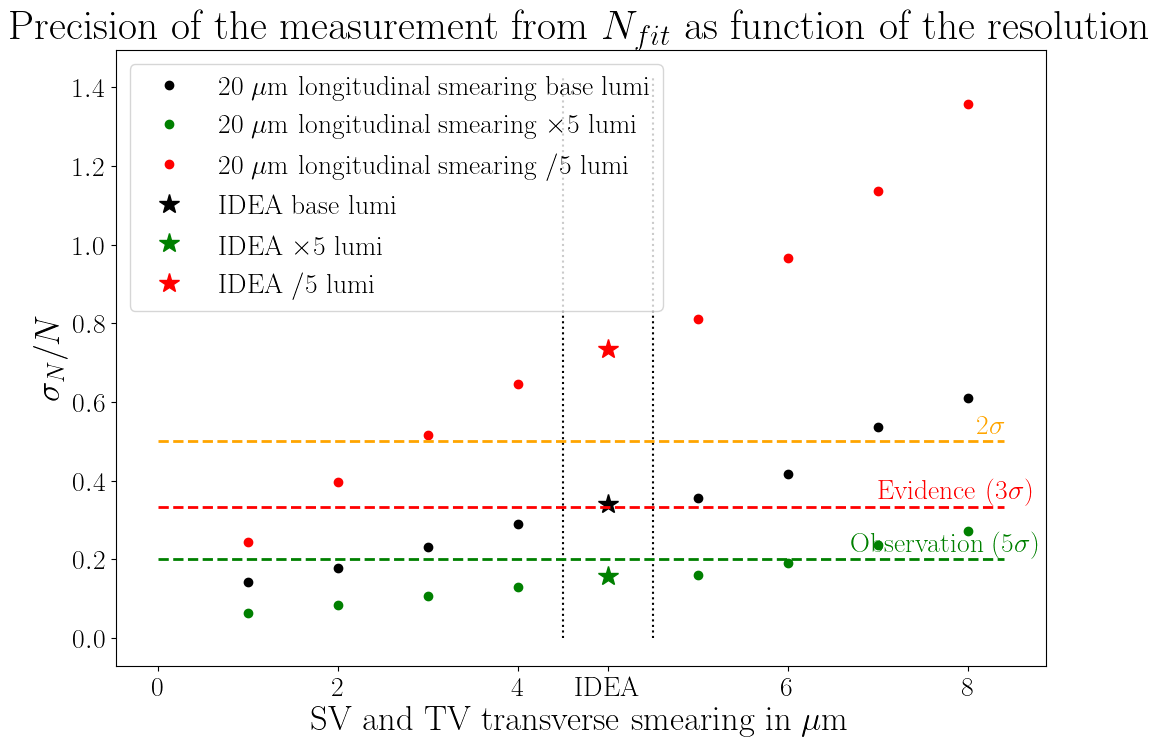

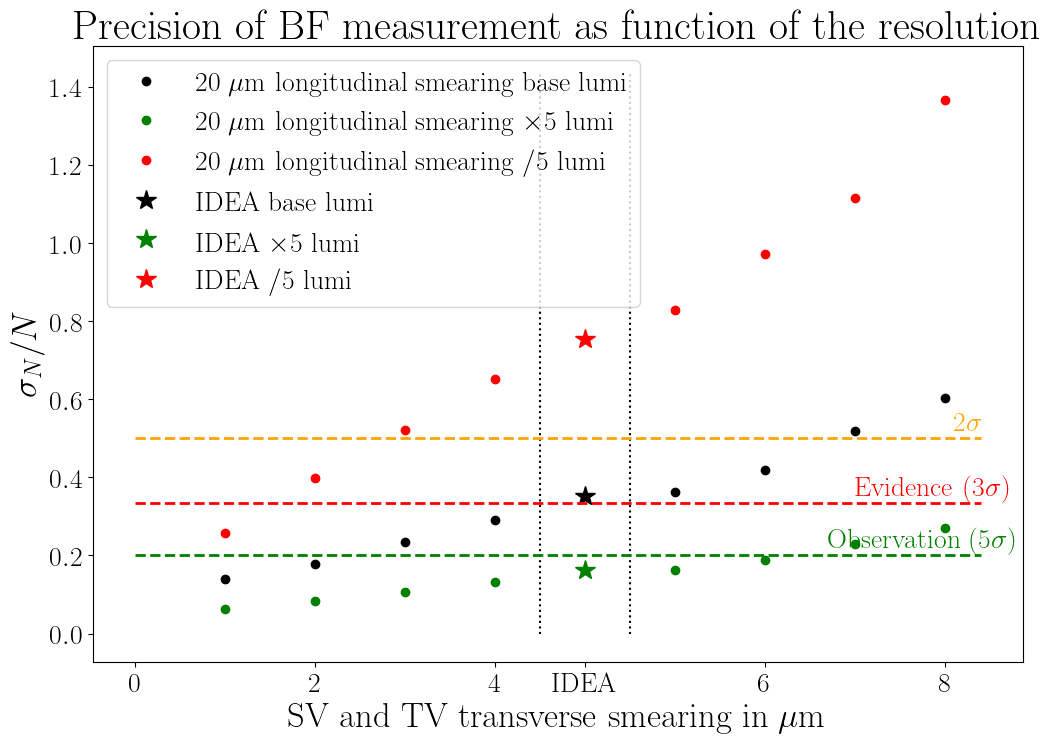

In [66]:
transverse_smearing_modify=transverse_smearing.copy()
transverse_smearing_modify[-1]=9
transverse_smearing_modify[-2]=8
transverse_smearing_modify[-3]=7
transverse_smearing_modify[-4]=6

plt.figure(figsize=(12,8))
plt.title('Precision of the measurement from $N_{fit}$ as function of the resolution')
plt.plot(transverse_smearing_modify, precision_fit_20, 'o', color='black', label=f'20 $\mu$m longitudinal smearing base lumi')
plt.plot(transverse_smearing_modify, precision_fit_time_5, 'og', label=f'20 $\mu$m longitudinal smearing $\\times 5$ lumi')
plt.plot(transverse_smearing_modify, precision_fit_div_5, 'or', label=f'20 $\mu$m longitudinal smearing $/5$ lumi')
plt.plot(5, precision_fit_IDEA, '*', color='black',markersize=15, label=f'IDEA base lumi')
plt.plot(5, precision_fit_IDEA_time_5, '*', color='green',markersize=15, label=f'IDEA $\\times 5$ lumi')
plt.plot(5, precision_fit_IDEA_div_5, '*', color='red',markersize=15, label=f'IDEA $/5$ lumi')
ymin, ymax = plt.ylim()
plt.vlines(4.5,ymin=ymin, ymax=ymax, color='black', linestyle='dotted')
plt.vlines(5.5,ymin=ymin, ymax=ymax, color='black', linestyle='dotted')
#plt.xticks([0,2,4,6,7,9])
plt.xticks([0,2,4,5,7,9],['0','2','4','IDEA','6','8'])
xmin, xmax = plt.xlim()
plt.hlines(y=1./2.,xmin=xmin, xmax=xmax,color='orange',linestyle='--',lw=2)
plt.text(9.1,1./2+0.02,'2$\\sigma$', color='orange', size=20.)
plt.hlines(y=1./3.,xmin=xmin, xmax=xmax,color='red',linestyle='--',lw=2)
plt.text(8.,1./3+0.02,'Evidence (3$\\sigma$)', color='red', size=20.)
plt.hlines(y=1./5.,xmin=xmin, xmax=xmax,color='green',linestyle='--',lw=2)
plt.text(7.7,1./5+0.02,'Observation (5$\\sigma$)', color='green', size=20.)
plt.xlabel('SV and TV transverse smearing in $\mu$m')
plt.ylabel('$\\sigma_{N}/N$')
plt.legend(loc='upper left')

plt.figure(figsize=(12,8))
plt.title('Precision of BF measurement as function of the resolution')
plt.plot(transverse_smearing_modify, precision_expec_20, 'o', color='black', label=f'20 $\mu$m longitudinal smearing base lumi')
plt.plot(transverse_smearing_modify, precision_expec_time_5, 'og', label=f'20 $\mu$m longitudinal smearing $\\times 5$ lumi')
plt.plot(transverse_smearing_modify, precision_expec_div_5, 'or', label=f'20 $\mu$m longitudinal smearing $/5$ lumi')
plt.plot(5, precision_expec_IDEA, '*', color='black',markersize=15, label=f'IDEA base lumi')
plt.plot(5, precision_expec_IDEA_time_5, '*', color='green',markersize=15, label=f'IDEA $\\times 5$ lumi')
plt.plot(5, precision_expec_IDEA_div_5, '*', color='red',markersize=15, label=f'IDEA $/5$ lumi')
ymin, ymax = plt.ylim()
plt.vlines(4.5,ymin=ymin, ymax=ymax, color='black', linestyle='dotted')
plt.vlines(5.5,ymin=ymin, ymax=ymax, color='black', linestyle='dotted')
#plt.xticks([0,2,4,6,7,9])
plt.xticks([0,2,4,5,7,9],['0','2','4','IDEA','6','8'])
xmin, xmax = plt.xlim()
plt.hlines(y=1./2.,xmin=xmin, xmax=xmax,color='orange',linestyle='--',lw=2)
plt.text(9.1,1./2+0.02,'2$\\sigma$', color='orange', size=20.)
plt.hlines(y=1./3.,xmin=xmin, xmax=xmax,color='red',linestyle='--',lw=2)
plt.text(8.,1./3+0.02,'Evidence (3$\\sigma$)', color='red', size=20.)
plt.hlines(y=1./5.,xmin=xmin, xmax=xmax,color='green',linestyle='--',lw=2)
plt.text(7.7,1./5+0.02,'Observation (5$\\sigma$)', color='green', size=20.)
plt.xlabel('SV and TV transverse smearing in $\mu$m')
plt.ylabel('$\\sigma_{N}/N$')
plt.legend(loc='upper left')

/var/folders/hc/7r1d6y954cscdrl_dhs2jt_w0000gn/T/ipykernel_2282/1168566592.py:65: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([L20_line, IDEA_line, IDEA_baseline],     # The line objects


(0.0, 0.7)

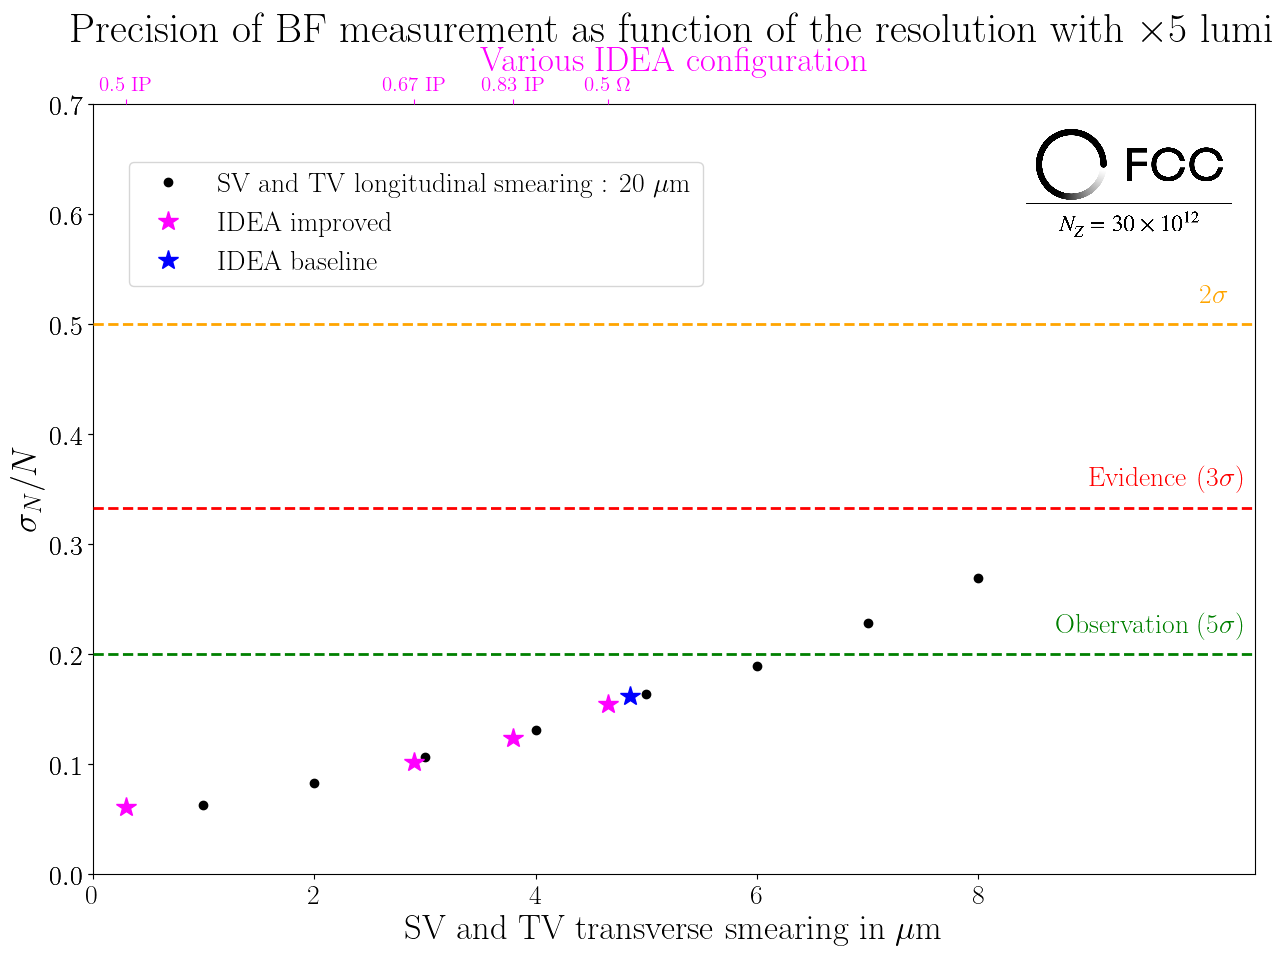

In [68]:
im2 = image.imread('fcclogos2.png')

n_sig_fit_IDEA_time_5=np.loadtxt(f'yield_fit_time_5/IDEA_n_sig_fit.txt')
n_sig_expec_IDEA_time_5=np.loadtxt(f'yield_fit_time_5/IDEA_n_sig_expected.txt')
sigma_n_sig_fit_IDEA_time_5=np.loadtxt(f'yield_fit_time_5/IDEA_sigma_n_sig_fit.txt')
n_sig_fit_IDEA_omega_50_time_5=np.loadtxt(f'yield_fit_time_5/IDEA_omega_50_n_sig_fit.txt')
n_sig_expec_IDEA_omega_50_time_5=np.loadtxt(f'yield_fit_time_5/IDEA_omega_50_n_sig_expected.txt')
sigma_n_sig_fit_IDEA_omega_50_time_5=np.loadtxt(f'yield_fit_time_5/IDEA_omega_50_sigma_n_sig_fit.txt')
n_sig_fit_IDEA_d0z0_83_time_5=np.loadtxt(f'yield_fit_time_5/IDEA_d0z0_83_n_sig_fit.txt')
n_sig_expec_IDEA_d0z0_83_time_5=np.loadtxt(f'yield_fit_time_5/IDEA_d0z0_83_n_sig_expected.txt')
sigma_n_sig_fit_IDEA_d0z0_83_time_5=np.loadtxt(f'yield_fit_time_5/IDEA_d0z0_83_sigma_n_sig_fit.txt')
n_sig_fit_IDEA_d0z0_67_time_5=np.loadtxt(f'yield_fit_time_5/IDEA_d0z0_67_n_sig_fit.txt')
n_sig_expec_IDEA_d0z0_67_time_5=np.loadtxt(f'yield_fit_time_5/IDEA_d0z0_67_n_sig_expected.txt')
sigma_n_sig_fit_IDEA_d0z0_67_time_5=np.loadtxt(f'yield_fit_time_5/IDEA_d0z0_67_sigma_n_sig_fit.txt')
n_sig_fit_IDEA_d0z0_50_time_5=np.loadtxt(f'yield_fit_time_5/IDEA_d0z0_50_n_sig_fit.txt')
n_sig_expec_IDEA_d0z0_50_time_5=np.loadtxt(f'yield_fit_time_5/IDEA_d0z0_50_n_sig_expected.txt')
sigma_n_sig_fit_IDEA_d0z0_50_time_5=np.loadtxt(f'yield_fit_time_5/IDEA_d0z0_50_sigma_n_sig_fit.txt')

precision_fit_IDEA_time_5=sigma_n_sig_fit_IDEA_time_5/n_sig_fit_IDEA_time_5
precision_expec_IDEA_time_5=sigma_n_sig_fit_IDEA_time_5/n_sig_expec_IDEA_time_5
precision_fit_IDEA_omega_50_time_5=sigma_n_sig_fit_IDEA_omega_50_time_5/n_sig_fit_IDEA_omega_50_time_5
precision_expec_IDEA_omega_50_time_5=sigma_n_sig_fit_IDEA_omega_50_time_5/n_sig_expec_IDEA_omega_50_time_5
precision_fit_IDEA_d0z0_83_time_5=sigma_n_sig_fit_IDEA_d0z0_83_time_5/n_sig_fit_IDEA_d0z0_83_time_5
precision_expec_IDEA_d0z0_83_time_5=sigma_n_sig_fit_IDEA_d0z0_83_time_5/n_sig_expec_IDEA_d0z0_83_time_5
precision_fit_IDEA_d0z0_67_time_5=sigma_n_sig_fit_IDEA_d0z0_67_time_5/n_sig_fit_IDEA_d0z0_67_time_5
precision_expec_IDEA_d0z0_67_time_5=sigma_n_sig_fit_IDEA_d0z0_67_time_5/n_sig_expec_IDEA_d0z0_67_time_5
precision_fit_IDEA_d0z0_50_time_5=sigma_n_sig_fit_IDEA_d0z0_50_time_5/n_sig_fit_IDEA_d0z0_50_time_5
precision_expec_IDEA_d0z0_50_time_5=sigma_n_sig_fit_IDEA_d0z0_50_time_5/n_sig_expec_IDEA_d0z0_50_time_5


transverse_smearing_modify_IDEA=[0.5,2.8,3.9,4.7]
prec_fit_IDEA_time_5=[precision_fit_IDEA_d0z0_50_time_5,precision_fit_IDEA_d0z0_67_time_5,precision_fit_IDEA_d0z0_83_time_5,precision_fit_IDEA_omega_50_time_5]
prec_expec_IDEA_time_5=[precision_expec_IDEA_d0z0_50_time_5,precision_expec_IDEA_d0z0_67_time_5,precision_expec_IDEA_d0z0_83_time_5,precision_expec_IDEA_omega_50_time_5]
transverse_smearing_modify_IDEA=[0.3,2.9,3.8,4.65]

fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False,sharey=ax)
L20_line=ax.plot(transverse_smearing, precision_expec_time_5, 'o', color='black', label=f'SV and TV longitudinal smearing : 20 $\mu$m')
ax.set_xlabel('SV and TV transverse smearing in $\mu$m')
ax.set_ylabel('$\\sigma_{N}/N$')
ax.set_xticks([0,2,4,6,8])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
ax.tick_params(axis='x', colors="black")
ax.tick_params(axis='y', colors="black")
ax.set_xlim(0.,10.5)
IDEA_line=ax2.plot(transverse_smearing_modify_IDEA, prec_expec_IDEA_time_5, '*', color='magenta', markersize=15, label='IDEA improved')
IDEA_baseline=ax2.plot(4.85, precision_expec_IDEA_time_5, '*', color='blue', markersize=15, label='IDEA baseline')
ax2.xaxis.tick_top()
ax2.set_xticks(transverse_smearing_modify_IDEA,['0.5 IP','0.67 IP','0.83 IP','0.5 $\\Omega$'])
ax2.set_xlabel('Various IDEA configuration', color="magenta")     
ax2.xaxis.set_label_position('top') 
ax2.tick_params(axis='x', colors="magenta",labelsize=15)
ax2.set_xlim(0.,10.5)
xmin, xmax = ax2.get_xlim()
ax2.hlines(y=1./2.,xmin=xmin, xmax=xmax,color='orange',linestyle='--',lw=2)
ax2.text(10.,1./2+0.02,'2$\\sigma$', color='orange', size=20.)
ax2.hlines(y=1./3.,xmin=xmin, xmax=xmax,color='red',linestyle='--',lw=2)
ax2.text(9.,1./3+0.02,'Evidence (3$\\sigma$)', color='red', size=20.)
ax2.hlines(y=1./5.,xmin=xmin, xmax=xmax,color='green',linestyle='--',lw=2)
ax2.text(8.7,1./5+0.02,'Observation (5$\\sigma$)', color='green', size=20.)
ax2.set_title("Precision of BF measurement as function of the resolution with $\\times 5$ lumi")
# Create the legend
line_labels=["SV and TV longitudinal smearing : 20 $\mu$m","IDEA improved","IDEA baseline"]
fig.legend([L20_line, IDEA_line, IDEA_baseline],     # The line objects
           labels=line_labels,   # The labels for each line
           loc=(0.1,0.7),   # Position of legend
           )
x_im=0.83
y_im=0.82
imagebox = OffsetImage(im2, zoom = 0.1)
imagebox.image.axes = ax2
ab = AnnotationBbox(imagebox, (x_im + 0.06, y_im + 0.072), xycoords='axes fraction', frameon = False)
ax2.add_artist(ab)
ax.set_ylim(0.,0.7)

In [19]:
print(sigma_n_sig_fit_10)

[21.99050797 24.57317642 28.55074947 31.86995485 34.70695076 40.90874527
 41.94165249 45.60222127]


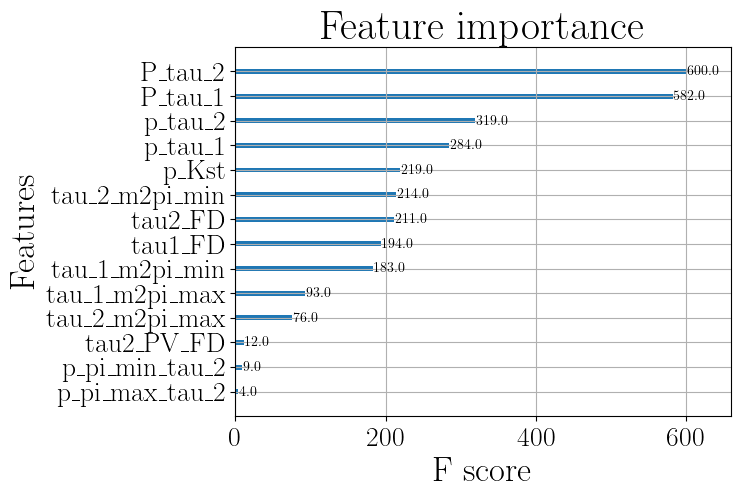

In [8]:
xgb.plot_importance(model_xgboost_fin);

Creation of LaTeX results tables:

In [108]:
table_5=np.array([["L-T smearing configuration",r"$\rm{N_{sig}}$",r"$\sigma_{\rm{N_{sig}}}$","Precision"]])
transverse_list=[1,2,3,4,5,6,7,8]
for Tsmear in transverse_list:
    config=f"5-{Tsmear}"+r"$\SI{}{\micro\meter}$"
    Nsig_expec=np.loadtxt(f'yield_fit/5-{Tsmear}_n_sig_expected.txt')
    Nsig_err=np.loadtxt(f'yield_fit/5-{Tsmear}_sigma_n_sig_fit.txt')
    preci=Nsig_err/Nsig_expec
    res=np.array([[config,f"{Nsig_expec:.2f}",f"{Nsig_err:.2f}",f"{preci:.2f}"]])
    table_5=np.concatenate((table_5,res),axis=0)
table_5pd = pd.DataFrame(table_5.T[1:],columns=table_5.T[0])
with open(f'tables_txt/table_result_L5.txt', "w") as f:
    print(table_5pd.to_latex(index=False,escape=False,column_format="lcccccccc"), file=f)

/var/folders/hc/7r1d6y954cscdrl_dhs2jt_w0000gn/T/ipykernel_2438/407117792.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table_5pd.to_latex(index=False,escape=False,column_format="lcccccccc"), file=f)


In [109]:
table_10=np.array([["L-T smearing configuration",r"$\rm{N_{signal}}$",r"$\sigma_{\rm{N_{signal}}}$","Precision"]])
transverse_list=[1,2,3,4,5,6,7,8]
for Tsmear in transverse_list:
    config=f"10-{Tsmear}"+r"$\SI{}{\micro\meter}$"
    Nsig_expec=np.loadtxt(f'yield_fit/10-{Tsmear}_n_sig_expected.txt')
    Nsig_err=np.loadtxt(f'yield_fit/10-{Tsmear}_sigma_n_sig_fit.txt')
    preci=Nsig_err/Nsig_expec
    res=np.array([[config,f"{Nsig_expec:.2f}",f"{Nsig_err:.2f}",f"{preci:.2f}"]])
    table_10=np.concatenate((table_10,res),axis=0)
table_10pd = pd.DataFrame(table_10.T[1:],columns=table_10.T[0])
with open(f'tables_txt/table_result_L10.txt', "w") as f:
    print(table_10pd.to_latex(index=False,escape=False,column_format="lcccccccc"), file=f)

/var/folders/hc/7r1d6y954cscdrl_dhs2jt_w0000gn/T/ipykernel_2438/2736803479.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table_10pd.to_latex(index=False,escape=False,column_format="lcccccccc"), file=f)


In [110]:
table_20=np.array([["L-T smearing configuration",r"$\rm{N_{signal}}$",r"$\sigma_{\rm{N_{signal}}}$","Precision"]])
transverse_list=[1,2,3,4,5,6,7,8]
for Tsmear in transverse_list:
    config=f"20-{Tsmear}"+r"$\SI{}{\micro\meter}$"
    Nsig_expec=np.loadtxt(f'yield_fit/20-{Tsmear}_n_sig_expected.txt')
    Nsig_err=np.loadtxt(f'yield_fit/20-{Tsmear}_sigma_n_sig_fit.txt')
    preci=Nsig_err/Nsig_expec
    res=np.array([[config,f"{Nsig_expec:.2f}",f"{Nsig_err:.2f}",f"{preci:.2f}"]])
    table_20=np.concatenate((table_20,res),axis=0)
table_20pd = pd.DataFrame(table_20.T[1:],columns=table_20.T[0])
with open(f'tables_txt/table_result_L20.txt', "w") as f:
    print(table_20pd.to_latex(index=False,escape=False,column_format="lcccccccc"), file=f)

/var/folders/hc/7r1d6y954cscdrl_dhs2jt_w0000gn/T/ipykernel_2438/1939820927.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table_20pd.to_latex(index=False,escape=False,column_format="lcccccccc"), file=f)


In [111]:
table_20pd

,L-T smearing configuration,20-1$\SI{}{\micro\meter}$,20-2$\SI{}{\micro\meter}$,20-3$\SI{}{\micro\meter}$,20-4$\SI{}{\micro\meter}$,20-5$\SI{}{\micro\meter}$,20-6$\SI{}{\micro\meter}$,20-7$\SI{}{\micro\meter}$,20-8$\SI{}{\micro\meter}$
0,$\rm{N_{signal}}$,117.79,100.27,86.02,75.70,66.79,59.69,53.62,48.32
1,$\sigma_{\rm{N_{signal}}}$,16.55,17.97,20.12,22.09,24.14,24.95,27.76,29.21
2,Precision,0.14,0.18,0.23,0.29,0.36,0.42,0.52,0.60


In [112]:
table_IDEA=np.array([["IDEA smearing configuration",r"$\rm{N_{signal}}$",r"$\sigma_{\rm{N_{signal}}}$","Precision"]])
IDEA_list=["IDEA","IDEA_omega_50","IDEA_d0z0_83", "IDEA_d0z0_67","IDEA_d0z0_50"]
IDEA_config_dict={"IDEA":"IDEA baseline","IDEA_omega_50":r"IDEA $2\times\Omega$","IDEA_d0z0_83":r"IDEA $1.2\times\rm{IP}$", "IDEA_d0z0_67":r"IDEA $1.5\times\rm{IP}$","IDEA_d0z0_50":r"IDEA $2\times\rm{IP}$"}
for IDEAsmear in IDEA_list:
    config=IDEA_config_dict[IDEAsmear]
    Nsig_expec=np.loadtxt(f'yield_fit/{IDEAsmear}_n_sig_expected.txt')
    Nsig_err=np.loadtxt(f'yield_fit/{IDEAsmear}_sigma_n_sig_fit.txt')
    preci=Nsig_err/Nsig_expec
    res=np.array([[config,f"{Nsig_expec:.2f}",f"{Nsig_err:.2f}",f"{preci:.2f}"]])
    table_IDEA=np.concatenate((table_IDEA,res),axis=0)
table_IDEApd = pd.DataFrame(table_IDEA.T[1:],columns=table_IDEA.T[0])
with open(f'tables_txt/table_result_IDEA.txt', "w") as f:
    print(table_IDEApd.to_latex(index=False,escape=False,column_format="lccccc"), file=f)

/var/folders/hc/7r1d6y954cscdrl_dhs2jt_w0000gn/T/ipykernel_2438/1431708165.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table_IDEApd.to_latex(index=False,escape=False,column_format="lccccc"), file=f)
